# Some maybe usefull stuff:
- Lets keep all the question to Antonio to trello
- The code to mark text: $**<code style="background:yellow;color:blue"> text</code>**$

# Credit card fraud detection

- __1. Introduction to the project__
- __2. Importing dependencies and data__
    - 2.1 Classes and functions used in the project
- __3. Sanity checking the full dataset__
    - 3.1 Target feature: Class
    - 3.2 Duplicates
    - 3.3 Summary
- __4. Splitting the data into training, validation and test set__
- __5. EDA__
    - 5.1 Are there alternative missing values?
    - 5.2 Analysis of numeric data
        - 5.2.1 Feature distributions
        - 5.2.2 Distribution of 'Amount' feature
        - 5.2.3 Logarithmic transformation of 'Amount'
        - 5.2.4 Outliers
        - 5.2.5 Removing outliers?
        - 5.2.6 Correlation between features (Spearman)
    - 5.3 Analysis of balanced dataset
        - 5.3.1 RandomOverSampler
        - 5.3.2 SMOTE
        - 5.3.3 Visual demonstration of the two oversampling strategies
    - 5.4 Analysis of 'Time' feature
        - 5.4.1 'Time' distribution of fraudulent transactions
        - 5.4.2 'Time' variable to 'hours'
    - 5.5 Summary of EDA
- __6. Exploring dataset preparation options__
    - 6.1 Basic dataset
    - 6.2 'Time' → 'hours'
    - 6.3 'Amount' → log1p('Amount')
    - 6.4 'Time' → MinMaxScaler('Time') / 'Amount' → RobustScaler('Amount')
    - 6.5 'Time' → 'hours' / 'Amount' → RobustScaler('Amount')
    - 6.6 'Time' → 'hours' / 'Amount' → RobustScaler(log1p('Amount'))
    - 6.7 Mutual information of the transformed features
    - 6.8 Summary of exploring dataset preparation options
- __7. Model selection__
    - 7.1 Basic model validating
    - 7.2 Models with class_weight hyperparameter
    - 7.3 Basic model validating with balanced datasets
        - 7.3.1 RandomOverSampler strategy
        - 7.3.2 SMOTECNC strategy
    - 7.4 Summary of model selection
- __8. Hyperparameter tuning__
    - 8.1 Summary
- __9. Model testing__
    - 9.1 Results and project evaluation
- __10. Decision threshold tuning__
    - 10.1 Summary


# 1. Introduction to the project

### "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

# 2. Importing dependencies and data

In [229]:
# pip install -U imbalanced-learn
# pip install -U joblib
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
#import streamlit as st
import os
import time

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,\
cross_val_score, cross_validate, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_curve,\
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, make_scorer, auc, fbeta_score,\
classification_report

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbalanced_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC

from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from scipy.stats import randint, uniform

from joblib import dump, load

### 2.1 Classes and functions used in the project

In [313]:
from sklearn.base import BaseEstimator, TransformerMixin

#######################################################################################################################
#####   Class used to pre-process the raw dataset 
#######################################################################################################################

class DataCleaner(BaseEstimator, TransformerMixin):
    '''The DataCleaner class is a custom transformer that can be used to clean and preprocess data in a machine learning pipeline.

    The class has several parameters:
        - hour: a boolean parameter that indicates whether to convert the Time feature to hours and one-hot-encode the resulting hour feature (default True)
        - feature_to_drop: a list of feature names to drop from the DataFrame (default [])
        - labels: a boolean parameter that indicates whether to split the Class feature (if it exists) from the other features and store it separately (default True)
        - imputer: an imputer object from scikit-learn to use for imputing missing values in the DataFrame (default None)
        - scaler: a scaler object from scikit-learn to use for scaling the numerical features in the DataFrame (default None)

    
    The class implements two methods, fit and transform. The functions takes data argument which must be a DataFrame'''

    def __init__(self, hour:bool =True, feature_to_drop:list =[], labels:bool =True, imputer:str = None, \
                 amount_scaler:str = None, time_scaler:str = None, amount_log:bool = False):
        self.hour = hour
        self.feature_to_drop = feature_to_drop
        self.labels = labels
        self.imputer = imputer
        self.amount_scaler = amount_scaler
        self.time_scaler = time_scaler
        #self.labels_data = None
        self.time = ['Time']
        self.amount = ['Amount']
        self.amount_log = amount_log
#         self.data_num = ['Amount'] # other columns have been already scaled.
        
        
    def fit(self, data, y=None):
        if self.imputer:
            self.imputer.fit(data)
        
        if self.amount_scaler:
            self.amount_scaler.fit(data.loc[:,self.amount])
            
        if self.time_scaler:
            self.time_scaler.fit(data.loc[:,self.time])
           
        
        return self 
    
    
    def transform(self, data, y=None):
        # make a copy of the input data
        data = data.copy()
        
        # Dropping all the rows where "Class" is missing
        if 'Class' in data.columns:
            data = data.dropna(axis=0, subset = 'Class')
        
       
        #Imputing missing_values 
        if data.isnull().values.any() or data.isna().values.any():
            data = pd.DataFrame(self.imputer.transform(data), columns=data.columns)
       
         # log transform amount
        if self.amount_log == True:
            data['Amount'] = np.log1p(data['Amount'])
            
       
        # Spliting labels from other features (if the data includes column 'Class'):
        labels_data = None
        if self.labels:
            if 'Class' in data.columns:
                labels_data = data['Class']
                data = data.drop('Class', axis=1)
                
            else:
                raise ValueError("No target variable 'Class' found in the dataset")
        

        if self.amount_scaler:
            data_amount_scaled = self.amount_scaler.transform(data.loc[:,self.amount])
            data.loc[:,self.amount] = data_amount_scaled
            
        if self.time_scaler:
            data_time_scaled = self.time_scaler.transform(data.loc[:,self.time])
            data.loc[:,self.time] = data_time_scaled


        # Converting 'Time' to 'hours':
        if self.hour:
            if 'Time' in data.columns:
                data['hour'] = ((((data['Time']) // (60 * 60)) % 24) + 1)
                data['hour'] = data['hour'].astype(int)
                data = data.drop('Time', axis=1)
            
                # one-hot-encoded dataset
                data = pd.get_dummies(data, columns=['hour'], prefix='hour')
            else:
                print("No 'Time' variable in the dataset")

        # Dropping not needed features based on the feature_to_drop list
        if self.feature_to_drop:
            data = data.drop(self.feature_to_drop, axis=1)
        
        
        return data, labels_data


#######################################################################################################################
#####   Class used to pre-process the raw dataset, only using X (used later in the project)
#######################################################################################################################   
    
class DataCleaner1(BaseEstimator, TransformerMixin):
    '''takes X as an argument'''
    
    
    def __init__(self, hour:bool =True, feature_to_drop:list =[], imputer:str = None, \
                 amount_scaler:str = None, time_scaler:str = None, amount_log:bool = False):
        self.hour = hour
        self.feature_to_drop = feature_to_drop
        self.imputer = imputer
        self.amount_scaler = amount_scaler
        self.time_scaler = time_scaler
        self.time = ['Time']
        self.amount = ['Amount']
        self.amount_log = amount_log

        
        
    def fit(self, data, y = None):
        if self.imputer:
            self.imputer.fit(data)
        
        if self.amount_scaler:
            self.amount_scaler.fit(data.loc[:,self.amount])
            
        if self.time_scaler:
            self.time_scaler.fit(data.loc[:,self.time])
           
        return self 
    
    
    def transform(self, data, y = None):
        # make a copy of the input data
        data = data.copy()
        
               
        #Imputing missing_values 
        if data.isnull().values.any() or data.isna().values.any():
            data = pd.DataFrame(self.imputer.transform(data), columns=data.columns)
       
        # log transform amount
        if self.amount_log == True:
            data['Amount'] = np.log1p(data['Amount'])
                

        if self.amount_scaler:
            data_amount_scaled = self.amount_scaler.transform(data.loc[:,self.amount])
            data.loc[:,self.amount] = data_amount_scaled
            
        if self.time_scaler:
            data_time_scaled = self.time_scaler.transform(data.loc[:,self.time])
            data.loc[:,self.time] = data_time_scaled


        # Converting 'Time' to 'hours':
        if self.hour:
            if 'Time' in data.columns:
                data['hour'] = ((((data['Time']) // (60 * 60)) % 24) + 1)
                data['hour'] = data['hour'].astype(int)
                data = data.drop('Time', axis=1)
            
                # one-hot-encoded dataset
                data = pd.get_dummies(data, columns=['hour'], prefix='hour')
            else:
                print("No 'Time' variable in the dataset")

        # Dropping not needed features based on the feature_to_drop list
        if self.feature_to_drop:
            data = data.drop(self.feature_to_drop, axis=1)
        
        
        return data
#######################################################################################################################
#####   Function to detect outliers in the dataset
#######################################################################################################################
    
def detect_outliers(data):
    outlier_info = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_info[column] = {"Outlier_percentage": outlier_percentage, "Total_count_of_outliers": len(outliers)}
                         
            outlier_dataframe = pd.DataFrame(outlier_info).T
                                                
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)    
    

#######################################################################################################################
#####   Function to detect the top X% of outliers in the dataset
#######################################################################################################################    
    
def detect_outliers_limit(data, limit, cols):
    outlier_percents = {}
    rows_to_remove = []
    for column in cols:
        if data[column].dtype != object:
            # quantiles
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            # inter quantile range
            iqr = q3 - q1

            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            # all the outliers
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            # select top limit%
            abs_sorted_outliers = abs(outliers).sort_values()
            threshold = abs_sorted_outliers.quantile(1-limit)
            top_percent = abs_sorted_outliers[abs_sorted_outliers >= threshold]
            top_percent_index = top_percent.index
            [rows_to_remove.append(n) for n in top_percent_index]
            
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])

    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False), set(rows_to_remove)



#######################################################################################################################
#####   Function to plot the ROC curve
#######################################################################################################################

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

    
    
#######################################################################################################################
#####   Function used to test different models
#######################################################################################################################

def model_tester(X_train, y_train, X_val, y_val):
    
    
    rf_clf = RandomForestClassifier()
    brf_clf = BalancedRandomForestClassifier()
    lr_clf = LogisticRegression()
    svc_rbf_clf = SVC(kernel='rbf', probability=True)
    svc_ploy_clf = SVC(kernel='poly', probability=True)
    knn_clf = KNeighborsClassifier()
    gnb_clf = GaussianNB()
    ada_clf = AdaBoostClassifier()
    qda_clf = QuadraticDiscriminantAnalysis()
    mlp_clf = MLPClassifier()
    xgb_clf = xgb.XGBClassifier()
    xgbrf_clf = xgb.XGBRFClassifier()

    model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
    
    models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, \
              xgb_clf, xgbrf_clf]
    
    eval_dict_out = dict()

    for i, clf in enumerate(models):
        print(f'============ {model_names[i]} ============')
    
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        try:
            feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
            print(feature_importances.sort_values('importance', ascending=False, inplace=True))
        except Exception as e: 
            print(e)
            print(f'The {model_names[i]} model does not have a feature importance parameter')
            
        try:
            coefs = pd.DataFrame({'feature': X_train.columns, 'coef': clf.coef_})
            print(coefs.sort_values('coef', ascending=False, inplace=True))
        except Exception as e: 
            print(e)
            print(f'The {model_names[i]} model does not have a coef parameter')
        
        start_time = time.time()
        y_pred = clf.predict(X_val)
        test_time = time.time() - start_time
        
        # Precision and recall to include in the results
        precision_real = precision_score(y_val, y_pred)
        recall_real = recall_score(y_val, y_pred)
        
        print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
        bal_acc_score = balanced_accuracy_score(y_val, y_pred)
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        y_prob = clf.predict_proba(X_val)[:,1]
        fpr, tpr, thresholds = roc_curve(y_val, y_prob)
        plot_roc_curve(fpr,tpr)
        plt.show()
        rocauc_score = roc_auc_score(y_val, y_prob)
        print(f'ROC AUC score: {rocauc_score}', end='\n\n===============================================\n')
        conf_mtr = confusion_matrix(y_val, y_pred)
        print(conf_mtr, end='\n\n===============================================\n')
        
        eval_dict_out[model_names[i]] = [bal_acc_score,precision_real, recall_real, f1, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time]
    return eval_dict_out



#######################################################################################################################
#####   Function used to test different models Version 2 - fbeta_score used added as new metric
#######################################################################################################################

beta = 5

def model_tester2(X_train, y_train, X_val, y_val):
    
    rf_clf = RandomForestClassifier()
    brf_clf = BalancedRandomForestClassifier()
    lr_clf = LogisticRegression()
    knn_clf = KNeighborsClassifier()
    gnb_clf = GaussianNB()
    ada_clf = AdaBoostClassifier()
    qda_clf = QuadraticDiscriminantAnalysis()
    mlp_clf = MLPClassifier()
    xgb_clf = xgb.XGBClassifier()
    xgbrf_clf = xgb.XGBRFClassifier()

    model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
    
    models = [rf_clf, brf_clf, lr_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, \
              xgb_clf, xgbrf_clf]
    
    eval_dict_out = dict()
    
    
    for i, clf in enumerate(models):
        print(f'============ {model_names[i]} ============')
        
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        start_time = time.time()
        y_pred = clf.predict(X_val)
        test_time = time.time() - start_time
        
        print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
        
        # balanced accuracy score
        bal_acc_score = balanced_accuracy_score(y_val, y_pred)
        
        # Recall -Precision plot
        y_prob = clf.predict_proba(X_val)[:, 1]
        precision_prob, recall_prob, threshold_prob = precision_recall_curve(y_val, y_prob)
        plt.plot(recall_prob, precision_prob)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()
        
        # Precision and recall to include in the results
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)    
    
        # Fbeta metric    
        fbeta =fbeta_score(y_val, y_pred, average='binary', beta=beta, pos_label=1)
        print('fbeta: %.4f' % fbeta, end='\n')
        
        # AUC under the Recall-Precision 
        auc_score = auc(recall_prob, precision_prob)
        print('AUC: %.3f' % auc_score, end='\n')
    
        conf_mtr = confusion_matrix(y_val, y_pred)
        print(conf_mtr, end='\n\n===============================================\n')
        
        eval_dict_out[model_names[i]] = [fbeta, bal_acc_score, precision, recall, auc_score, conf_mtr[0,1], conf_mtr[1,0],\
                                         train_time, test_time, precision_prob, recall_prob, threshold_prob, y_prob]
        
    return eval_dict_out



#######################################################################################################################
#####   Function used to test different models Version 3 - models with class_weight
#######################################################################################################################

def model_tester3(X_train, y_train, X_val, y_val):
    
    class_weight_10_1 = {0 : 10, 1 : 1}
    class_weight_1_10 = {0 : 1, 1 : 10}
    class_weight_09_01 = {0 : 0.9, 1 : 0.1}
    class_weight_01_09 = {0 : 0.1, 1 : 0.9}
    
    weights = [class_weight_10_1, class_weight_1_10, class_weight_09_01, class_weight_01_09]
       
    eval_dict_out = dict()
    
    for j, weight in enumerate(weights):
        print(f'============ {weights[j]} ============')
        
        rf_clf = RandomForestClassifier(class_weight=weight)
        brf_clf = BalancedRandomForestClassifier(class_weight=weight)
        lr_clf = LogisticRegression(class_weight=weight)
    
        
        
        model_names = ['rf_clf', 'brf_clf', 'lr_clf']
    
        models = [rf_clf, brf_clf, lr_clf]
        
        for i, clf in enumerate(models):
            print(f'============ {model_names[i]} ============')    

            start_time = time.time()
            clf.fit(X_train, y_train)
            train_time = time.time() - start_time
        
            start_time = time.time()
            y_pred = clf.predict(X_val)
            test_time = time.time() - start_time
            
            print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
            
            # balanced accuracy score
            bal_acc_score = balanced_accuracy_score(y_val, y_pred)
            
            # Recall -Precision plot
            y_prob = clf.predict_proba(X_val)[:, 1]
            precision_prob, recall_prob, threshold_prob = precision_recall_curve(y_val, y_prob)
            plt.plot(recall_prob, precision_prob)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.show()
            
            # Precision and recall to include in the results
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)    
        
            # Fbeta metric    
            fbeta = fbeta_score(y_val, y_pred, average='binary', beta=beta, pos_label=1)
            print('fbeta: %.4f' % fbeta, end='\n')
            
            # AUC under the Recall-Precision 
            auc_score = auc(recall_prob, precision_prob)
            print('AUC: %.3f' % auc_score, end='\n')
        
            conf_mtr = confusion_matrix(y_val, y_pred)
            print(conf_mtr, end='\n\n===============================================\n')
        
            eval_dict_out[model_names[i]+' 0: ' + str(weights[j][0])+'/ 1: ' + str(weights[j][1])] = [fbeta, bal_acc_score, precision, recall, auc_score, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time, precision_prob, recall_prob, threshold_prob, y_prob]
        
    return eval_dict_out

#######################################################################################################################
#####   Functions used to calculate and plot mutual information scores
#######################################################################################################################
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.columns:
        mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
#######################################################################################################################
#####   Function used to calculate the threshold which results the highest FBeta score
#######################################################################################################################
    
def model_threshold_finder(y_val, y_prob):

    # keep probabilities for the positive outcome only
    yhat = y_prob[:, 1]
    
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y_val, yhat)

    # convert to fbeta scorea
    beta=5
    fbeta = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)

    # locate the index of the largest f score
    ix_fbeta = argmax(fbeta)

    
    print('Best Fbeta Threshold=%f, F-Score=%.3f' % (thresholds[ix_fbeta], fbeta[ix_fbeta]), end='\n\n================================================\n\n')

    # make predictions from probabilities based on the optimal threshold
    ypred_from_prob = np.where(yhat>=thresholds[ix_fbeta], 1, 0)

    # evaluations
    print(classification_report(y_val, ypred_from_prob), end='\n\n================================================\n\n')

    print(confusion_matrix(y_val, ypred_from_prob), end='\n\n================================================\n\n')

    return thresholds[ix_fbeta], fbeta[ix_fbeta], yhat

In [231]:
#Getting the data

# raw_data = pd.read_csv(r"C:\Users\katar\OneDrive\Dokumenty\Edukacja\Data Science\6_DS_Project\Project\03_Coding\Cards_data\creditcard.csv")

raw_data = pd.read_csv(r"D:\06_projekt_i_data_science\coding ground\raw data\creditcard.csv")

# 3. Sanity checking the full dataset

In [4]:
raw_data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [14]:
raw_data.shape

(283726, 31)

In [15]:
raw_data.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     28

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The dataset has 31 features
- The dataset has 284807 observations in total
- The dataset has no missing values
- The target feature is Class
- Except for Time, Amount and Class features, all other features are unnamed, which is a result of PCA dimension reduction and also serves as a way to anonymize the data
- All the features have numeric data, except Time and Class
- Class is Nominal Categoric data
- Time could be Ordinal Categoric data

### 3.1 Target feature: Class

In [324]:
raw_data.Class.value_counts(normalize=True)

0    0.998333
1    0.001667
Name: Class, dtype: float64

In [17]:
raw_data.Class.value_counts(normalize=False)

0    283253
1       473
Name: Class, dtype: int64

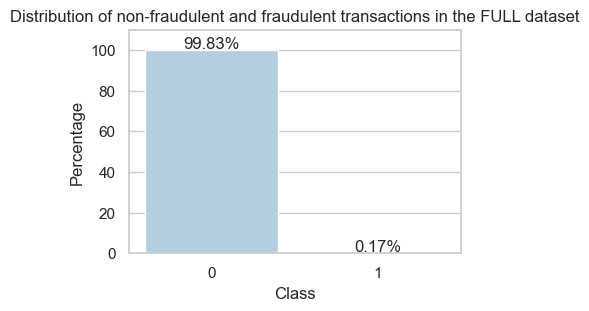

In [338]:
classes_count_normalized = raw_data.Class.value_counts(normalize=True)
data = {'Class':[0,1],'Percentage':[classes_count_normalized[0]*100, classes_count_normalized[1]*100]}
sns.set_style('whitegrid')
plt.figure(figsize=(4,3), layout='constrained')
ax = sns.barplot(x='Class', y='Percentage', data=data, palette='Blues')
ax.set_title('Distribution of non-fraudulent and fraudulent transactions in the FULL dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_ylim([0, 110])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1, '{:.2f}%'.format(height), ha="center")
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The overwhelming amount of transactions 99.8%, are not fraudulent
- This higly unbalanced representation of the tagret feature makes the accuracy metric unusable. We will need to use other classification metrics such as: __Precision, Recall, F1 score, ROC AUC score__
- Why? Only by predicting all transactions as non fraud -> the accuracy will be over 0,99!

### 3.2 Duplicates

In [9]:
raw_data[raw_data.duplicated(keep=False)]

Time        V1        V2        V3        V4        V5        V6  \
32          26.0 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
33          26.0 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
34          26.0 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
35          26.0 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
112         74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
...          ...       ...       ...       ...       ...       ...       ...   
283485  171627.0 -1.457978  1.378203  0.811515 -0.603760 -0.711883 -0.471672   
284190  172233.0 -2.667936  3.160505 -3.355984  1.007845 -0.377397 -0.109730   
284191  172233.0 -2.667936  3.160505 -3.355984  1.007845 -0.377397 -0.109730   
284192  172233.0 -2.691642  3.123168 -3.339407  1.017018 -0.293095 -0.167054   
284193  172233.0 -2.691642  3.123168 -3.339407  1.017018 -0.293095 -0.167054   

              V7        V8        V9  ...       V21       V22       V23  \
32      0.711206  0.176066 -0.286717  ...  0.046949  0.208105 -0.185548   
33      0.711206  0.176066 -0.286717  ...  0.046949  0.208105 -0.185548   
34      0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -0.187108   
35      0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -0.187108   
112    -0.036715  0.350995  0.118950  ...  0.102520  0.605089  0.023092   
...          ...       ...       ...  ...       ...       ...       ...   
283485 -0.282535  0.880654  0.052808  ...  0.284205  0.949659 -0.216949   
284190 -0.667233  2.309700 -1.639306  ...  0.391483  0.266536 -0.079853   
284191 -0.667233  2.309700 -1.639306  ...  0.391483  0.266536 -0.079853   
284192 -0.745886  2.325616 -1.634651  ...  0.402639  0.259746 -0.086606   
284193 -0.745886  2.325616 -1.634651  ...  0.402639  0.259746 -0.086606   

             V24       V25       V26       V27       V28  Amount  Class  
32      0.001031  0.098816 -0.552904 -0.073288  0.023307    6.14      0  
33      0.001031  0.098816 -0.552904 -0.073288  0.023307    6.14      0  
34      0.000753  0.098117 -0.553471 -0.078306  0.025427    1.77      0  
35      0.000753  0.098117 -0.553471 -0.078306  0.025427    1.77      0  
112    -0.626463  0.479120 -0.166937  0.081247  0.001192    1.18      0  
...          ...       ...       ...       ...       ...     ...    ...  
283485  0.083250  0.044944  0.639933  0.219432  0.116772   11.93      0  
284190 -0.096395  0.086719 -0.451128 -1.183743 -0.222200   55.66      0  
284191 -0.096395  0.086719 -0.451128 -1.183743 -0.222200   55.66      0  
284192 -0.097597  0.083693 -0.453584 -1.205466 -0.213020   36.74      0  
284193 -0.097597  0.083693 -0.453584 -1.205466 -0.213020   36.74      0  

[1854 rows x 31 columns]

In [4]:
num_duplicates = raw_data.duplicated(keep=False).sum()

print(f"There are {num_duplicates} duplicates in the data.")

There are 1854 duplicates in the data.


In [232]:
print(f'Dataset shape before dropping duplicates: {raw_data.shape}')

num_duplicates_to_drop = raw_data.duplicated(keep='first').sum()
raw_data = raw_data.drop_duplicates(keep='first')

print(f'Dropped {num_duplicates_to_drop} duplicate rows from the dataset')
print(f'Dataset shape after dropping duplicates: {raw_data.shape}')

Dataset shape before dropping duplicates: (284807, 31)
Dropped 1081 duplicate rows from the dataset
Dataset shape after dropping duplicates: (283726, 31)


### 3.3 Summary -------------- IF NEEDED

# 4. Splitting the data into training, validation and test set

In [233]:
# spliting the data into train and test set
raw_train, raw_valid_test = train_test_split(raw_data, test_size=0.4, random_state = 42, shuffle=True, stratify=raw_data["Class"])
# spliting the test set into validation and test set
raw_val, raw_test = train_test_split(raw_valid_test, test_size=0.5, random_state = 42, shuffle=True, stratify=raw_valid_test["Class"])

In [8]:
print("Training set dimensions: ", raw_train.shape)#, 'amd training lagels:', y_train.shape,)
print("Test set dimensions: ", raw_test.shape)#, 'and test labels:', y_test.shape)
print("Validation dataset dimensions: ", raw_val.shape)#, 'and validation labels:', y_val.shape)

Training set dimensions:  (170235, 31)
Test set dimensions:  (56746, 31)
Validation dataset dimensions:  (56745, 31)


# 5. EDA

### WHAT ARE WE CURIOUS ABOUT IN THE EDA???

In [12]:
raw_train.head()

Time        V1        V2        V3        V4        V5        V6  \
109011   71174.0 -2.108259  1.173406  1.614294  0.482867  0.067209 -0.191013   
280683  169683.0  2.313997 -1.311064 -1.421228 -1.724356 -1.003480 -0.912621   
158318  111127.0  2.104946  0.155284 -1.402870  0.311489  0.504248 -0.690870   
243733  152052.0  2.072408 -0.015687 -1.310880  0.373435 -0.063476 -1.380722   
177016  123008.0  2.046409  0.156335 -2.006987  0.384525  0.604029 -0.756561   

              V7        V8        V9  ...       V21       V22       V23  \
109011  0.191246 -1.705859 -0.177615  ...  1.520624 -0.388595  0.260114   
280683 -0.898765 -0.221952 -1.658076  ...  0.089446  0.664605  0.029245   
158318  0.138943 -0.417801  1.894584  ...  0.107745  0.759527 -0.022144   
243733  0.243699 -0.394350  0.631048  ...  0.243262  0.858393  0.003403   
177016  0.232367 -0.230789  0.072474  ...  0.326565  1.165945 -0.109465   

             V24       V25       V26       V27       V28  Amount  Class  
109011  0.340667  0.400474 -0.413089 -0.348291  0.215298   19.99      0  
280683 -0.347503  0.069152  0.074159 -0.024483 -0.076422   15.00      0  
158318  0.465282  0.402861 -0.478955 -0.016524 -0.053868    1.00      0  
243733  0.077370  0.259102 -0.110464 -0.021166 -0.058972    1.99      0  
177016  0.793698  0.377195  0.837559 -0.075171 -0.053246    1.57      0  

[5 rows x 31 columns]

In [13]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### 5.1 Are there alternative missing values?

In [14]:
# Checking if there is any zero values in the training dataset (there is no Nan, but maybe they had 0 as missing value...)
# Excluding Class in this check as >99% of the data has Class = 0
raw_train[raw_train.iloc[:,0:30] == 0].dropna(how='all')

Time  V1  V2  V3  V4  V5  V6  V7  V8  V9  ...  V21  V22  V23  V24  \
215250   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
143435   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
199399   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
65356    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
79512    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   
183106   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
256028   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
176142   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
161304   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
95146    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

        V25  V26  V27  V28  Amount  Class  
215250  NaN  NaN  NaN  NaN     0.0    NaN  
143435  NaN  NaN  NaN  NaN     0.0    NaN  
199399  NaN  NaN  NaN  NaN     0.0    NaN  
65356   NaN  NaN  NaN  NaN     0.0    NaN  
79512   NaN  NaN  NaN  NaN     0.0    NaN  
...     ...  ...  ...  ...     ...    ...  
183106  NaN  NaN  NaN  NaN     0.0    NaN  
256028  NaN  NaN  NaN  NaN     0.0    NaN  
176142  NaN  NaN  NaN  NaN     0.0    NaN  
161304  NaN  NaN  NaN  NaN     0.0    NaN  
95146   NaN  NaN  NaN  NaN     0.0    NaN  

[1070 rows x 31 columns]

In [15]:
# All the amounts are zero or positive
print(f'Is any amount 0? --> {any(raw_train.Amount== 0)}')
print(f'Are all amounts bigger than or equal to 0? --> {all(raw_train.Amount>= 0)}')

Is any amount 0? --> True
Are all amounts bigger than or equal to 0? --> True


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There seems to be no missing values in the dataset
- There are 1070 observations where Amount = 0
- There are 2 observations where Time = 0 (we know this from Chapter 2. Sanity checking the WHOLE dataset, but these observations are not present in the training set)
- We assume that the transactions where Amount = 0 are valid tranactions. These could be transactions where a person needs to "pay a deposit" in order to register to a page, but real money is drawn after the trial period is over.
- There are no transactions with a negative Amount

### 5.2 Analysis of numeric data

In [16]:
raw_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Time            V1            V2            V3            V4  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean    94939.37288       0.00197      -0.00445      -0.00249       0.00011   
std     47506.71221       1.95921       1.65161       1.51925       1.41495   
min         0.00000     -46.85505     -63.34470     -48.32559      -5.68317   
25%     54277.75000      -0.91788      -0.60133      -0.89262      -0.84617   
50%     84907.50000       0.02251       0.06266       0.17883      -0.02059   
75%    139422.25000       1.31587       0.80114       1.02332       0.74360   
max    172792.00000       2.45189      22.05773       9.38256      16.87534   

                 V5            V6            V7            V8            V9  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean        0.00041      -0.00079      -0.00178      -0.00014       0.00331   
std         1.38177       1.33247       1.24667       1.19175       1.09781   
min      -113.74331     -21.92931     -43.55724     -73.21672     -13.43407   
25%        -0.69185      -0.76804      -0.55509      -0.20791      -0.63949   
50%        -0.05647      -0.27367       0.03973       0.02256      -0.04798   
75%         0.61078       0.39721       0.57156       0.32606       0.60140   
max        32.91146      73.30163     120.58949      20.00721      15.59499   

       ...           V21           V22           V23           V24  \
count  ...  170884.00000  170884.00000  170884.00000  170884.00000   
mean   ...       0.00140       0.00034       0.00064       0.00026   
std    ...       0.73926       0.72656       0.62725       0.60509   
min    ...     -34.83038     -10.93314     -44.80774      -2.83663   
25%    ...      -0.22780      -0.54198      -0.16219      -0.35470   
50%    ...      -0.02868       0.00674      -0.01065       0.04137   
75%    ...       0.18644       0.52834       0.14776       0.43952   
max    ...      27.20284      10.50309      22.08354       4.58455   

                V25           V26           V27           V28        Amount  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean       -0.00090       0.00025      -0.00050       0.00012      88.42941   
std         0.52206       0.48256       0.40685       0.31471     255.43632   
min       -10.29540      -2.60455     -22.56568     -15.43008       0.00000   
25%        -0.31706      -0.32719      -0.07069      -0.05296       5.74000   
50%         0.01640      -0.05211       0.00122       0.01116      22.05000   
75%         0.34958       0.24210       0.09084       0.07782      77.50000   
max         6.07085       3.51735      31.61220      15.87047   25691.16000   

              Class  
count  170884.00000  
mean        0.00173  
std         0.04151  
min         0.00000  
25%         0.00000  
50%         0.00000  
75%         0.00000  
max         1.00000  

[8 rows x 31 columns]

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Time: time is represented in seconds. 0 is when the observations started, and 172792 is the second count for the last observation. This equals roughly a 48 day period.
- Amount: the smallest transfer amount was 0 (possible explanation in previous observation), and the biggest transaction amount was 25691. The average transaction amount is ~88.5, but we can see that 50% of the transactions were under 22.05, which means that the distribution of the Amount is strongly skewed and has a right tail.
- Class: we can see that only 0.173% of the transactions were fraud.
- As we don't have names for the majority of the features, it is unlikely that we can get out meaningful observations 

#### 5.2.1 Feature distributions

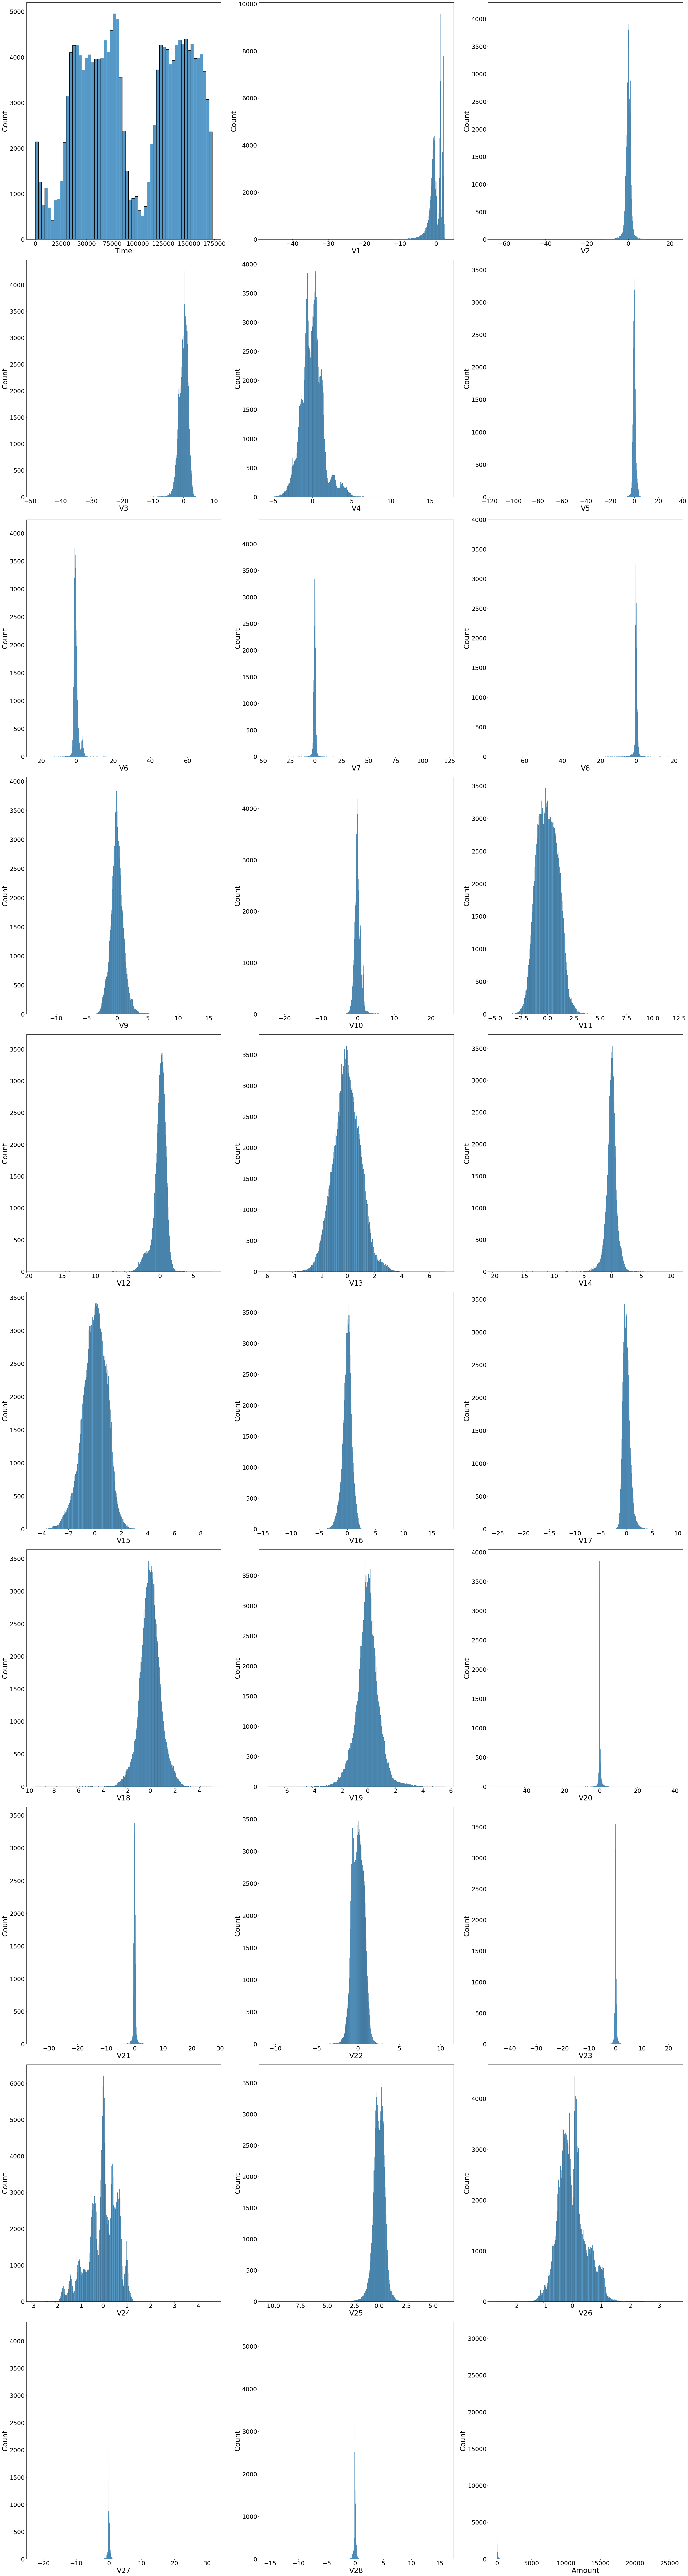

In [17]:
fig, axes = plt.subplots(len(raw_train.columns)//3, 3, figsize=(40,150), layout='constrained')
axes = axes.ravel()

for k, ax in enumerate(axes):
    p = sns.histplot(data=raw_train, x=raw_train.columns[k], ax=ax)
#     p.axes.set_title(raw_train.columns[k],fontsize=50)
    p.set_xlabel(raw_train.columns[k],fontsize=30)
    p.set_ylabel("Count",fontsize=30)
    p.tick_params(labelsize=25)
    p

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- The features (except Time, Amount and Class) seem to be standardised, as their location is around 0.
- Most of the featres distribution vaguely resemble normal distribution, but with very high curtosis

#### 5.2.2 Distribution of 'Amount' feature

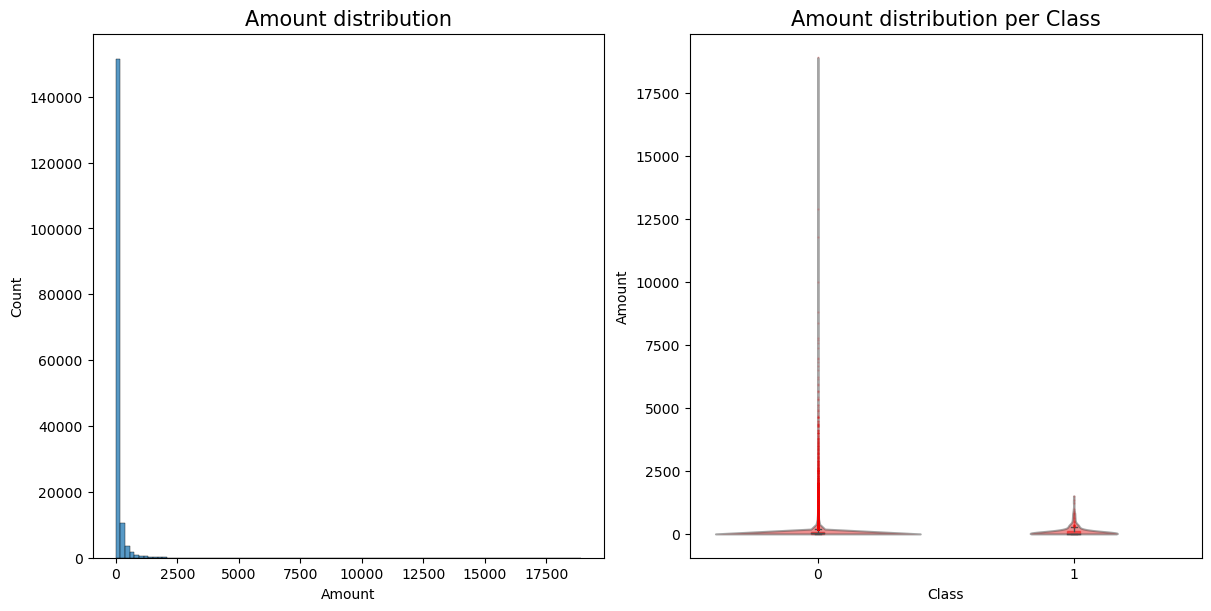

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), layout='constrained')
cols = [0, -2]

p1 = sns.histplot(data=raw_train, x='Amount', bins=100, ax=axes[0])
p1.axes.set_title('Amount distribution',fontsize=15)

p2 = sns.violinplot(data=raw_train, y=raw_train.Amount, x='Class', ax=axes[1], color='red', cut=0, inner=None)
boxprops = dict(color='r', alpha=0.5)
flierprops = dict(marker='o', markeredgecolor='r', markersize=0.5, alpha=0.2)
sns.boxplot(data = raw_train, y=raw_train.Amount, x='Class', ax=axes[1], color='red', width=0.05, fliersize=0.5,\
            linewidth=1, whis=1.5, boxprops=boxprops, flierprops=flierprops)
p2.axes.set_title('Amount distribution per Class',fontsize=15)
p2.tick_params(labelsize=10)
plt.setp(axes[1].collections, alpha=.5)

plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- We can see that the $Amount$ variable is strongly skewed to the right. 
- The Amount feature seems to have numerous outliers, some of them are quite extreme

#### 5.2.3 Logarithmic transformation of 'Amount'

In [43]:
raw_train_log = raw_train.copy()
raw_train_log['Amount_log'] = np.log1p(raw_train_log['Amount'])

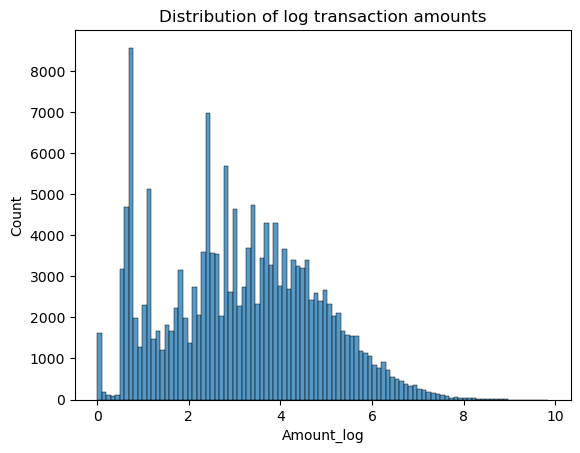

In [52]:
sns.histplot(data=raw_train_log, x='Amount_log', bins=100)
plt.title('Distribution of log transaction amounts')
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- It can be worth checking how models deal with logaritmicaly transformed $Amount$. 

In [23]:
# Ratio of transactions under 100
len(raw_train[raw_train.Amount<100])/len(raw_train)

0.7978336181269166

In [24]:
# Maximum fraud amount
raw_train[raw_train.Class==1]['Amount'].max()

2125.87

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- Almost 80% of all transactions are under 100
- The maximum fraud amount is 2125.87

#### 5.2.4 Outliers

In [54]:
detect_outliers(raw_train)

Outlier_percentage  Total_count_of_outliers
V27              13.614709                  23177.0
Amount           11.189238                  19048.0
V28              10.503715                  17881.0
V20               9.748877                  16596.0
V8                8.360208                  14232.0
V6                8.128763                  13838.0
V23               6.557406                  11163.0
V12               5.371986                   9145.0
V21               5.031280                   8565.0
V14               4.983699                   8484.0
V2                4.724645                   8043.0
V5                4.324023                   7361.0
V4                3.943372                   6713.0
V19               3.548037                   6040.0
V10               3.241402                   5518.0
V7                3.106882                   5289.0
V9                2.885423                   4912.0
V16               2.851353                   4854.0
V17               2.626957                   4472.0
V18               2.626957                   4472.0
V1                2.441331                   4156.0
V26               2.001351                   3407.0
V25               1.847446                   3145.0
V24               1.685905                   2870.0
V13               1.168385                   1989.0
V3                1.158399                   1972.0
V15               1.027991                   1750.0
V22               0.452903                    771.0
V11               0.248480                    423.0
Class             0.166828                    284.0
Time              0.000000                      0.0

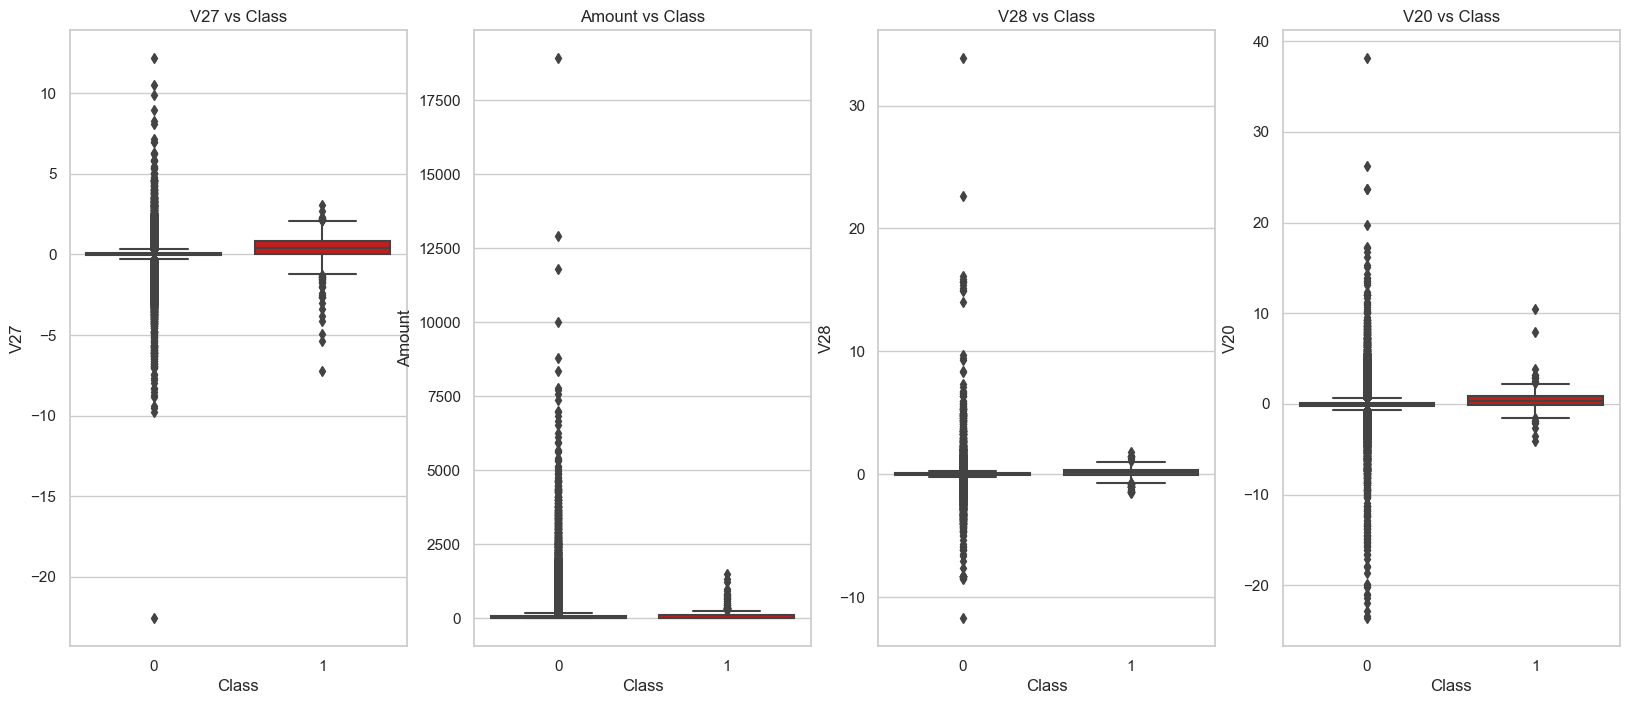

In [261]:
# Further examples of outliers
f, axes = plt.subplots(ncols=4, figsize=(20,8))
colors = ["#0101DF", "#DF0101"]

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V27", data=raw_train, palette=colors, ax=axes[0])
axes[0].set_title('V27 vs Class')

sns.boxplot(x="Class", y="Amount", data=raw_train, palette=colors, ax=axes[1])
axes[1].set_title('Amount vs Class')


sns.boxplot(x="Class", y="V28", data=raw_train, palette=colors, ax=axes[2])
axes[2].set_title('V28 vs Class')


sns.boxplot(x="Class", y="V20", data=raw_train, palette=colors, ax=axes[3])
axes[3].set_title('V20 vs Class')

plt.show()

#### 5.2.5 Removing outliers?

In [57]:
indexes_to_remove = detect_outliers_limit(raw_train_log, 0.1, ['V17', 'V14', 'V12', 'V10'])[1]

In [58]:
# indexes_to_remove
print(f'raw_train original length: {len(raw_train_log)}')
print(f'Number of indexes to remove: {len(indexes_to_remove)}')
raw_train_minus_outliers = raw_train_log.drop(index=indexes_to_remove)
print(f'length of dataset after removal: {len(raw_train_minus_outliers)}')

raw_train original length: 170235
Number of indexes to remove: 2010
length of dataset after removal: 168225


In [60]:
# Class ditribution in original train dataset
raw_train.Class.value_counts(normalize=False)

0    169951
1       284
Name: Class, dtype: int64

In [61]:
# Class ditribution in train dataset after removing the top 10% of 'V17', 'V14', 'V12', 'V10' column outliers
raw_train_minus_outliers.Class.value_counts(normalize=False)

0    168184
1        41
Name: Class, dtype: int64

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- 11.71% of the Amount are outliers
- Removing only the top 10% of 'V17', 'V14', 'V12', 'V10' column outliers results in losing a huge majority of the fraudulent transactions
- We decided to leave the outliers in the dataset, as the removal of them would result in losing the fraudulent observations

#### 5.2.6 Correlation between features (Spearman)

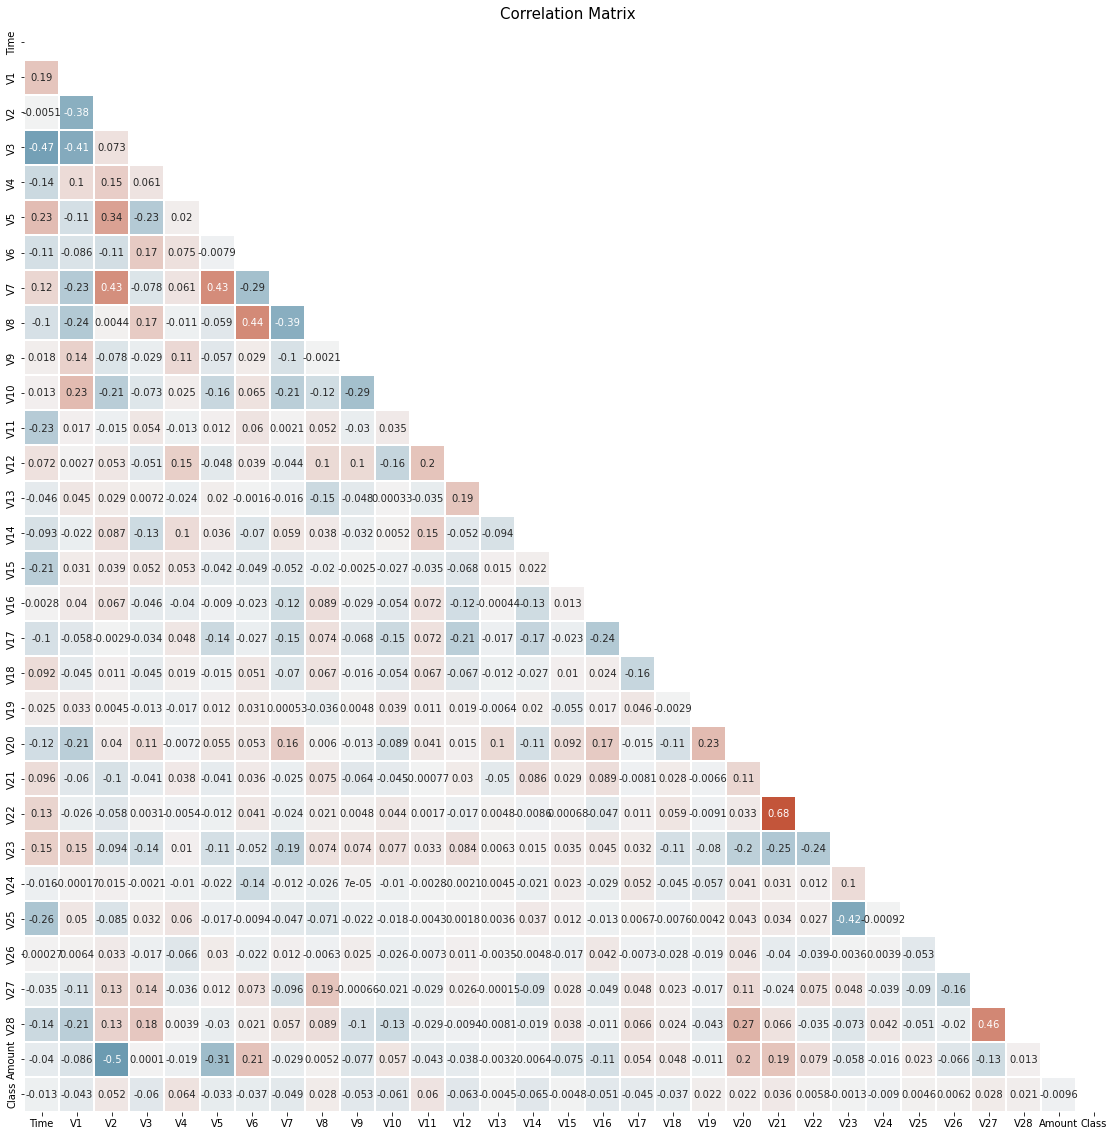

In [30]:
features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = raw_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

Note:
The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- 

### 5.3 Analysis of balanced dataset

# !!!! MAYBE A BIT OF TEXT HERE? !!!!!

#### 5.3.1 RandomOverSampler

The most naive strategy. $RandomOverSampler()$ generates new samples by randomly sampling with replacement the current available samples.

(If repeating samples is an issue, the parameter shrinkage allows to create a smoothed bootstrap. However, the original data needs to be numerical.) 

In [257]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

# WE need to split labels form the rest of the features before we can continue with the sampler
clean_data = DataCleaner(hour=False, labels=True)
X_train_raw, y_train_raw = clean_data.fit_transform(raw_train)

# Now we can fit the sampler
X_ros_train, y_ros_train = ros.fit_resample(X_train_raw, y_train_raw)
from collections import Counter
print(sorted(Counter(y_ros_train).items()))

[(0, 169951), (1, 169951)]


In [259]:
ros_train = pd.concat([X_ros_train, y_ros_train], axis=1)
ros_train.head()

Time        V1        V2        V3        V4        V5        V6  \
0  67428.0  0.545137 -1.382002  0.808039  0.325749 -1.216218  0.520418   
1  80288.0  1.274782  0.239294  0.126050  0.981467  0.308615  0.288049   
2  92736.0 -2.442663 -3.250807 -1.081487  0.276296  0.401510 -0.383979   
3  57773.0 -2.086922 -6.322946 -2.168681  0.926756 -2.522653 -0.144318   
4  67862.0 -0.873372 -0.381341  3.111317 -1.452125 -1.447693  0.795084   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -0.404707  0.236356  0.843181  ...  0.032340 -0.309100 -0.173193  0.119002   
1  0.070181 -0.096043  0.315763  ... -0.321162 -0.676714 -0.175115 -0.975418   
2  0.261438  0.486404  1.891807  ...  0.851970  0.984857  1.307229 -1.158888   
3  2.146822 -0.703704 -0.883657  ...  0.617022 -1.792547 -1.668460  0.008613   
4 -1.041973  0.765762  0.220466  ...  0.205009  0.861046 -0.342198  0.231057   

        V25       V26       V27       V28   Amount  Class  
0 -0.062738  0.921664 -0.074989  0.053908   309.00      0  
1  0.762622 -0.446555  0.045943  0.018644    18.07      0  
2 -1.705672 -0.959345  0.149654 -0.049546   506.00      0  
3 -0.191875  0.930436 -0.418456  0.309412  1832.55      0  
4  0.342896 -0.105434  0.345348  0.113345     1.00      0  

[5 rows x 31 columns]

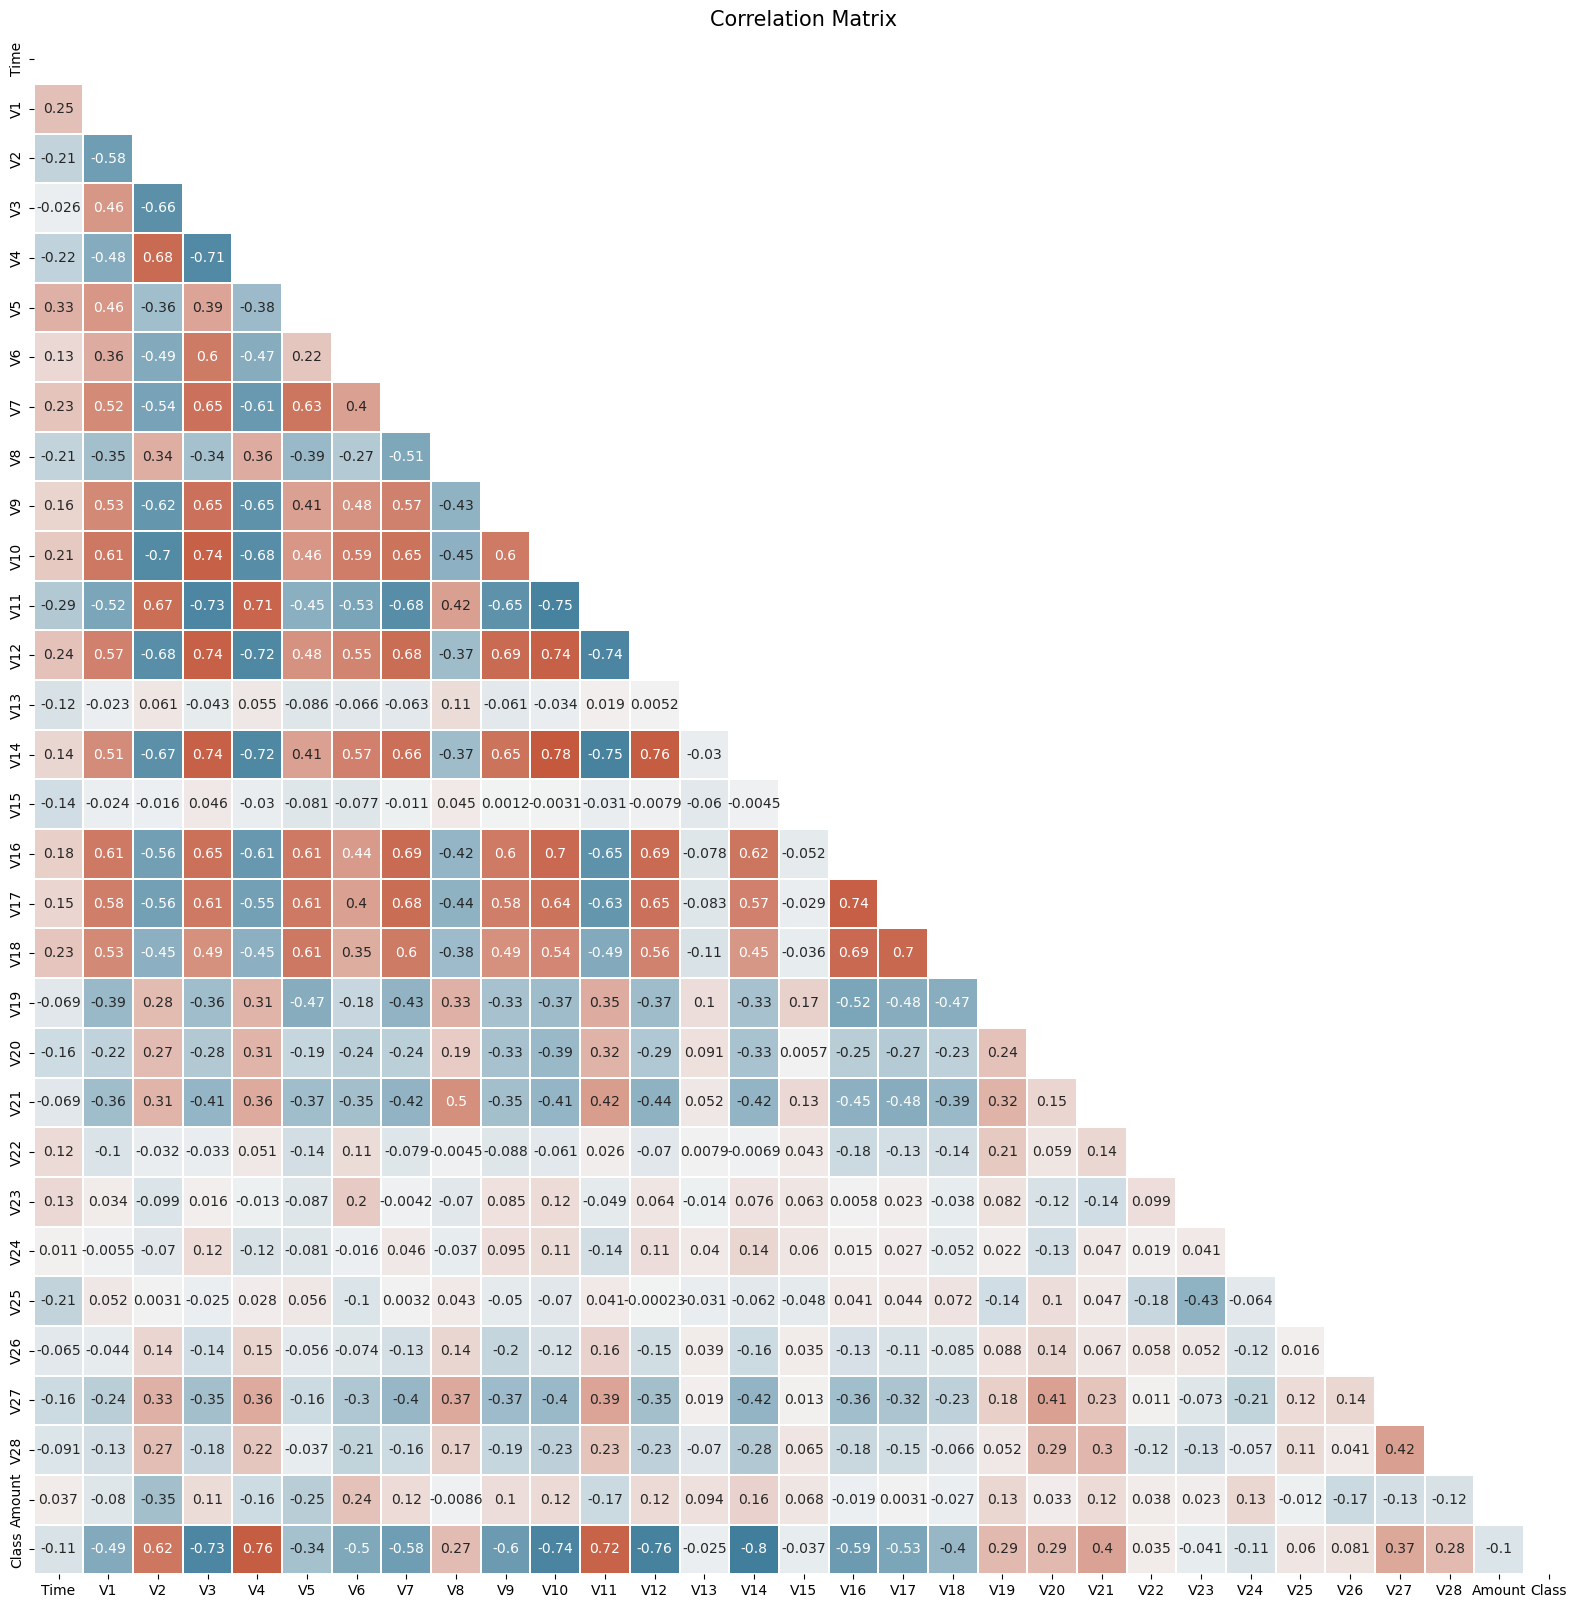

In [69]:
# Feature correlation matrix on the dataset balanced with RandomOverSample

features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = ros_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [70]:
# Feature correlations on the dataset balanced with RandomOVerSampler

correlations = ros_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.755933
V11       0.723874
V2        0.620637
V21       0.399055
V27       0.372803
V19       0.287149
V20       0.285585
V28       0.279427
V8        0.272337
V26       0.081320
V25       0.060464
V22       0.035146
V13      -0.024850
V15      -0.037287
V23      -0.040544
Amount   -0.101579
Time     -0.112785
V24      -0.113769
V5       -0.337576
V18      -0.401846
V1       -0.489724
V6       -0.504431
V17      -0.525553
V7       -0.579414
V16      -0.590356
V9       -0.597208
V3       -0.731430
V10      -0.742166
V12      -0.762038
V14      -0.796815
Name: Class, dtype: float64


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- After balancing training dataset with RandomOverSampler() we've got much stronger correlations between 'Class' and other features,
- On the scatterplot we can see that RandomOverSamler() copied instances of fraud transactions. 

### 5.3.3 SMOTE

OBS: I go with standard one (all variables are presented as numbers). In case we decide that $Time$ variable is categorical we should choose $SMOTENC$.

In [263]:
from imblearn.over_sampling import SMOTE
X_smote_train, y_smote_train = SMOTE().fit_resample(X_train_raw, y_train_raw)
print(sorted(Counter(y_smote_train).items()))

[(0, 169951), (1, 169951)]


In [264]:
smote_train = pd.concat([X_smote_train, y_smote_train], axis=1)
smote_train.shape

(339902, 31)

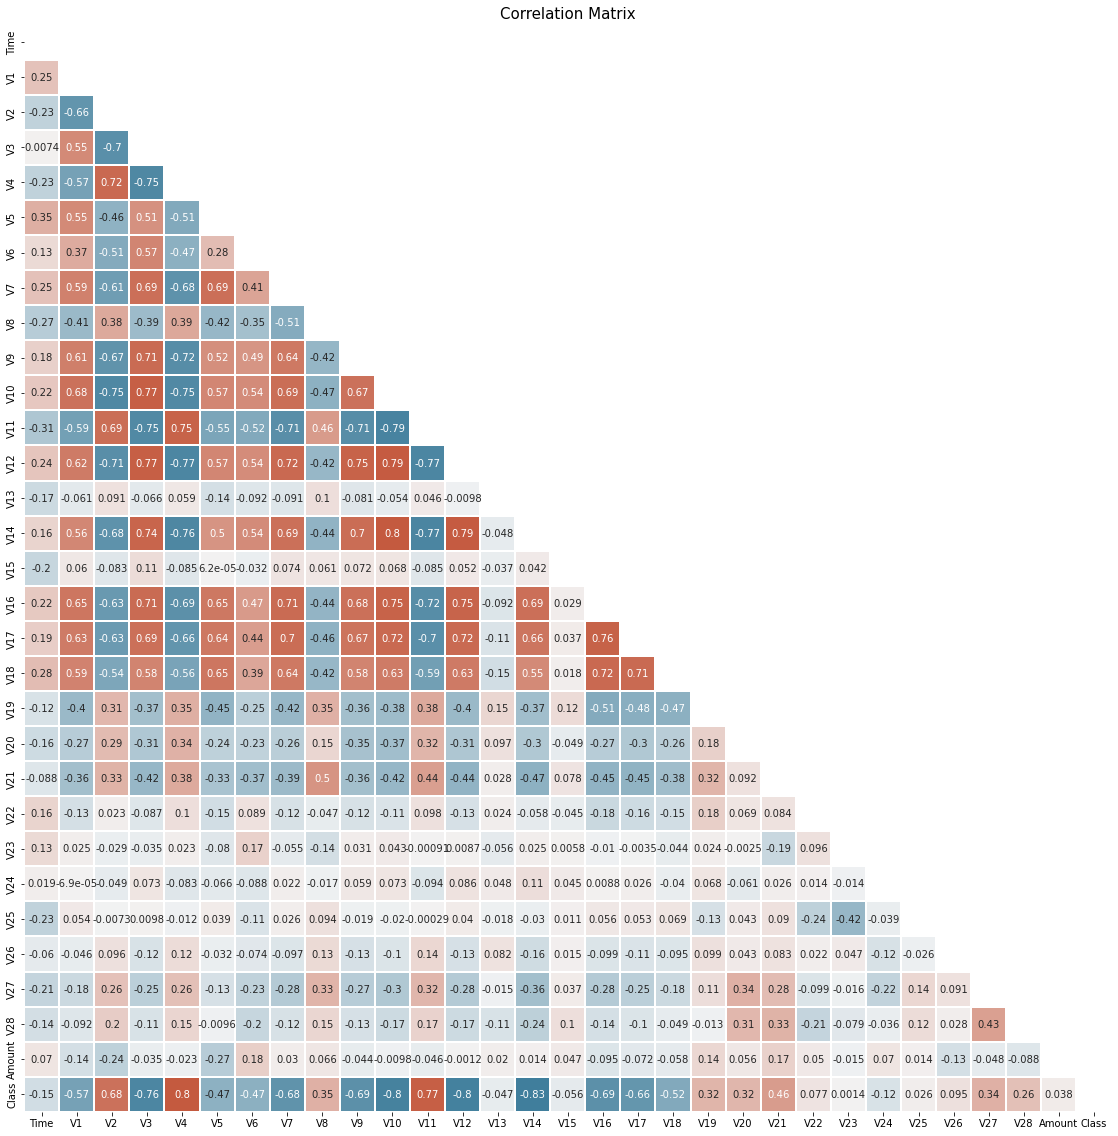

In [41]:
# Feature correlation matrix on the dataset balanced with SMOTEC

correlation_matrix = smote_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [42]:
# Feature correlations on the dataset balanced with SMOTEC

correlations = smote_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.801351
V11       0.770982
V2        0.678397
V21       0.456155
V8        0.345607
V27       0.342064
V19       0.318464
V20       0.315372
V28       0.260340
V26       0.095147
V22       0.076907
Amount    0.037866
V25       0.026498
V23       0.001373
V13      -0.046803
V15      -0.056281
V24      -0.116331
Time     -0.149551
V5       -0.465245
V6       -0.473672
V18      -0.515744
V1       -0.573731
V17      -0.655824
V7       -0.675581
V16      -0.693469
V9       -0.693883
V3       -0.763225
V10      -0.800580
V12      -0.804531
V14      -0.832736
Name: Class, dtype: float64


#### 5.3.2 Visual demonstration of the two oversampling strategies

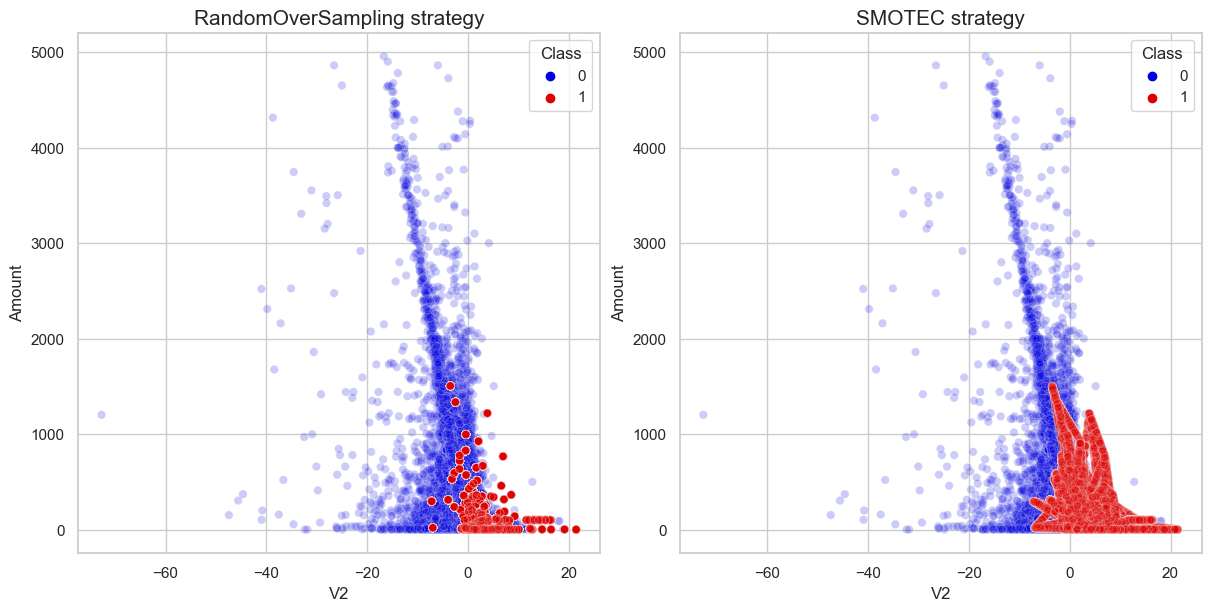

In [267]:
colors = ["#0101DF", "#DF0101"]
fig, axes = plt.subplots(1, 2, figsize=(12,6), layout='constrained')

g1 = sns.scatterplot(x=ros_train['V2'], y=ros_train[ros_train['Amount']<5000]['Amount'], hue=ros_train['Class'], palette=colors, alpha = 0.2, ax=axes[0])
g1.axes.set_title('RandomOverSampling strategy',fontsize=15)

g2 = sns.scatterplot(x=smote_train['V2'], y=smote_train[smote_train['Amount']<5000]['Amount'], hue=smote_train['Class'], palette=colors, alpha = 0.2, ax=axes[1])
g2.axes.set_title('SMOTEC strategy',fontsize=15)

plt.show()

### 5.4 Analysis of 'Time' feature

In [44]:
raw_train.Time.describe()

count    170884.000000
mean      94939.372885
std       47506.712210
min           0.000000
25%       54277.750000
50%       84907.500000
75%      139422.250000
max      172792.000000
Name: Time, dtype: float64

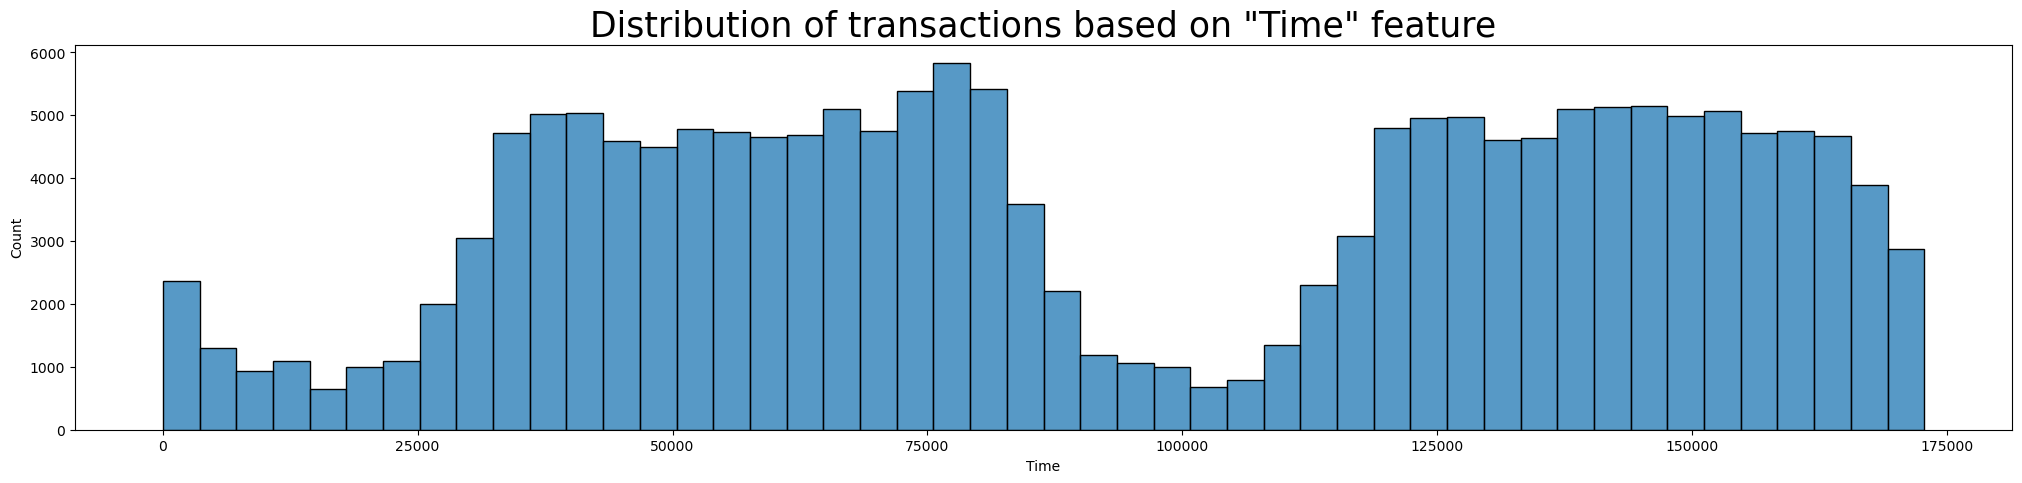

In [81]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(raw_train['Time'], bins = 48)
plt.title('Distribution of transactions based on "Time" feature', fontsize=25)
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are two periods when there is much more transactions done.
- $Time$ is in seconds from 0 to 172792 (so it is 2879,8 min -> about 48hours)
- We can assume that the modes are daytimes and the dataset describes two days

#### 5.4.1 'Time' distribution of fraudulent transactions

In [83]:
df_fraud = raw_train[raw_train['Class'] == 1]
df_fraud.head()

Time         V1        V2         V3         V4        V5  \
146790   87883.0  -1.360293 -0.458069  -0.700404   2.737229 -1.005106   
281144  169966.0  -3.113832  0.585864  -5.399730   1.817092 -0.840618   
69980    53658.0  -1.739341  1.344521  -0.534379   3.195291 -0.416196   
30442    35926.0  -3.896583  4.518355  -4.454027   5.547453 -4.121459   
11710    20011.0 -14.724627  7.875157 -21.872317  11.906170 -8.348734   

              V6         V7        V8        V9  ...       V21       V22  \
146790  2.891399   5.802537 -1.933197 -1.017717  ... -0.936990 -0.053812   
281144 -2.943548  -2.208002  1.058733 -1.632333  ...  0.583276 -0.269209   
69980  -1.261961  -2.340991  0.713004 -1.416265  ...  0.383180 -0.213952   
30442  -1.163407  -6.805053  2.928356 -4.917130  ...  1.691042  0.920021   
11710  -2.262846 -15.833443  0.077874 -6.356833  ... -2.362345  1.099557   

             V23       V24       V25       V26       V27       V28  Amount  \
146790  0.580106  0.216927  0.151643 -0.332115 -0.469800 -1.495006  829.41   
281144 -0.456108 -0.183659 -0.328168  0.606116  0.884876 -0.253700  245.00   
69980  -0.336640  0.237076  0.246003 -0.044228  0.510729  0.220952    0.00   
30442  -0.151104  0.011007  0.080303  0.412191  0.635789  0.501050    4.56   
11710   1.037199 -1.036359 -0.254777  0.642343  2.161129 -1.401282    1.00   

        Class  
146790      1  
281144      1  
69980       1  
30442       1  
11710       1  

[5 rows x 31 columns]

In [48]:
len(df_fraud)

295

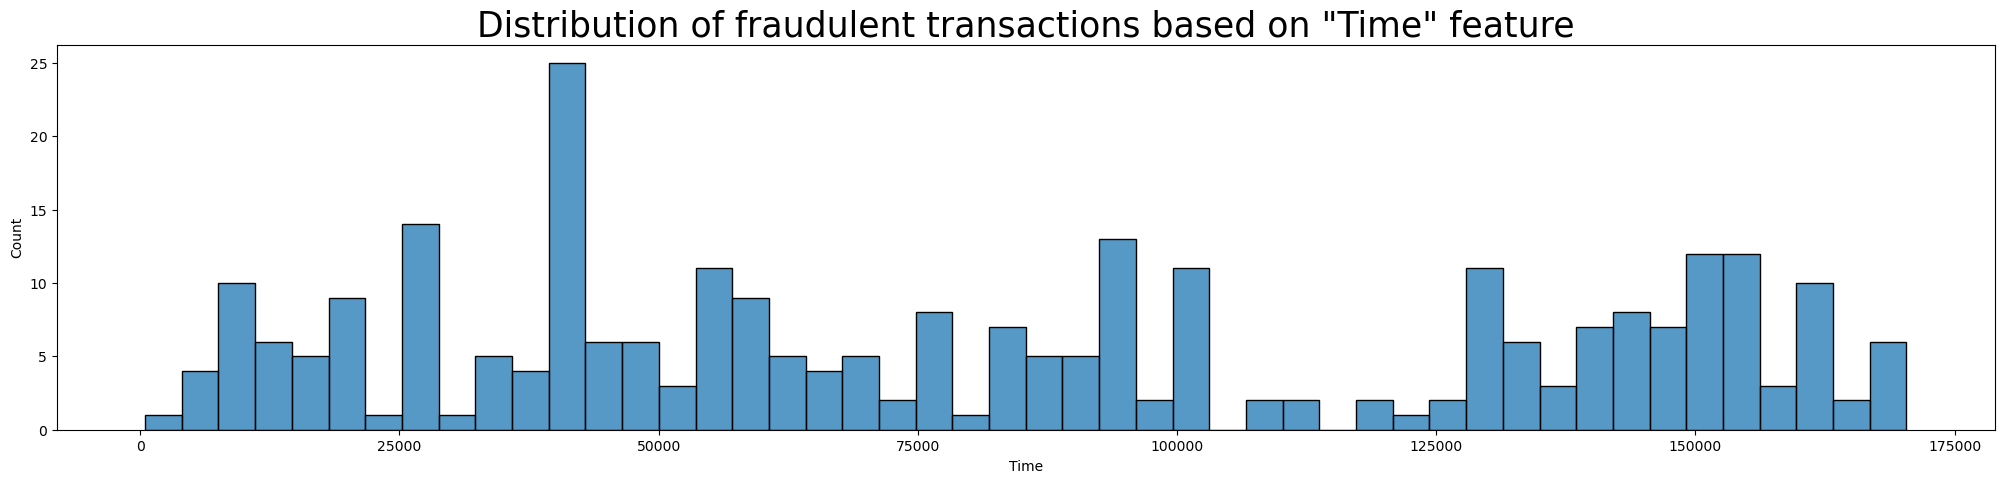

In [84]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(df_fraud['Time'], bins = 48)
plt.title('Distribution of fraudulent transactions based on "Time" feature', fontsize=25)
plt.show()

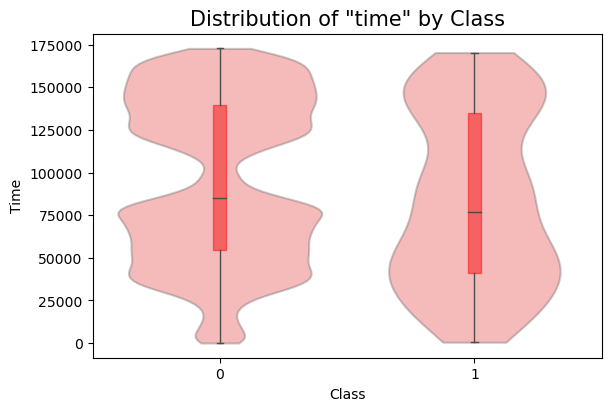

In [91]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

p = sns.violinplot(data=raw_train, y=raw_train.Time, x='Class', color='red', cut=0, inner=None)
boxprops = dict(color='r', alpha=0.5)
flierprops = dict(marker='o', markeredgecolor='r', markersize=0.5, alpha=0.2)
sns.boxplot(data = raw_train, y=raw_train.Time, x='Class', color='red', width=0.05,\
            fliersize=0.5, linewidth=1, whis=1.5, boxprops=boxprops, flierprops=flierprops)

p.axes.set_title('Distribution of "time" by Class',fontsize=15)
p.tick_params(labelsize=10)
plt.setp(ax.collections, alpha=.3)
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are 295 fraudulent transactions in the training set
- There seems to be no real time pattern for the fraudulent transactions
- There seems to be a slight pattern when we look at fraudulent transaction as a function of the time variable, but this pattern is not substantial, or eventually we would need more data to see if the pattern is strong enough.

#### 5.4.2 'Time' variable to 'hours'

In [87]:
# calculate the hour for each value in 'Time'
# // - Floor Division	9//2 = 4

train_t = raw_train
train_t['hour'] = ((((train_t['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
train_t['hour'] = train_t['hour'].astype(int)
print(f"Minimum and maximum value for 'hour' feature\nMinimum: {train_t['hour'].min()}\nMaximum: {train_t['hour'].max()}")

Minimum and maximum value for 'hour' feature
Minimum: 1
Maximum: 24


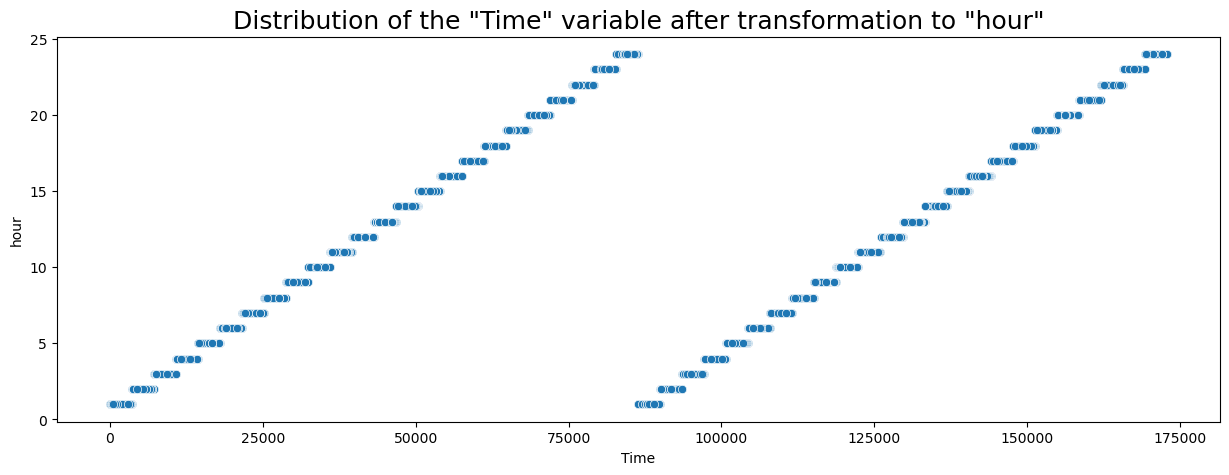

In [94]:
f, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=train_t['Time'], y=train_t['hour'], data=train_t)
plt.title('Distribution of the "Time" variable after transformation to "hour"', fontsize=18)
plt.show()

### 5.5 Summary of EDA 

# !!!! MAYBE PUTTING ALL THE OBSERVATIONS HERE?
# OR MAKE A SUMMARY

# 6. Exploring dataset preparation options

# !!! TEXT ABOUT OUR STRATEGY (ex. which models we use, why, and why we try different datasets)

### 6.1 Basic dataset
- Time variable scaled with MinMaxScaler()
- Amount variable scaled with MinMaxScaler()

In [30]:
imputer = SimpleImputer(strategy='most_frequent')
scaler_amount = MinMaxScaler()
scaler_time = MinMaxScaler()

In [31]:
clean_train_out = DataCleaner(hour=False, feature_to_drop=[], labels=True, imputer=imputer, amount_scaler=scaler_amount, time_scaler=scaler_time)

X_train_out, y_train_out = clean_train_out.fit_transform(raw_train)
X_val_out, y_val_out = clean_train_out.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9324    0.7340    0.8214        94

    accuracy                         0.9995     56745
   macro avg     0.9660    0.8670    0.9106     56745
weighted avg     0.9994    0.9995    0.9994     56745




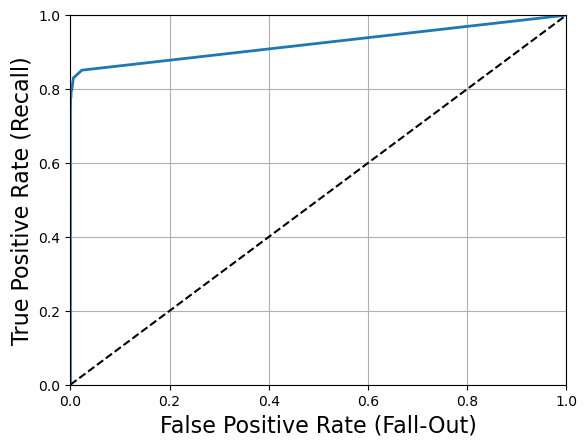

ROC AUC score: 0.9233154698213811

[[56646     5]
 [   25    69]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9771    0.9883     56651
           1     0.0573    0.8404    0.1073        94

    accuracy                         0.9768     56745
   macro avg     0.5285    0.9087    0.5478     56745
weighted avg     0.9982    0.9768    0.9868     56745




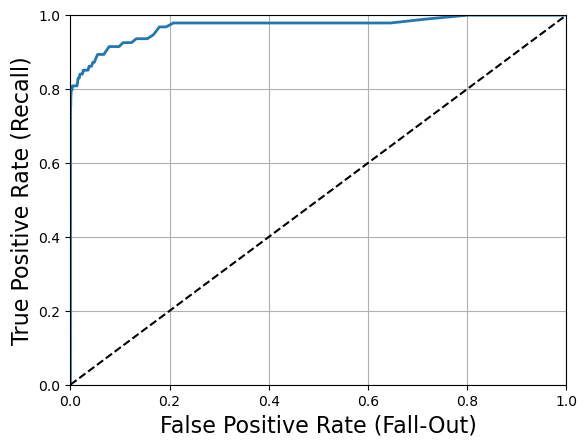

ROC AUC score: 0.9702507551837548

[[55351  1300]
 [   15    79]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9992    0.9999    0.9995     56651
           1     0.8621    0.5319    0.6579        94

    accuracy                         0.9991     56745
   macro avg     0.9306    0.7659    0.8287     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


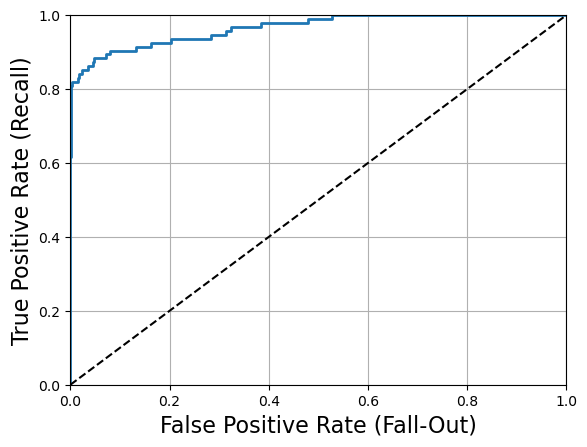

ROC AUC score: 0.9663929614583056

[[56643     8]
 [   44    50]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.9500    0.6064    0.7403        94

    accuracy                         0.9993     56745
   macro avg     0.9747    0.8032    0.8700     56745
weighted avg     0.9993    0.9993    0.9992     56745




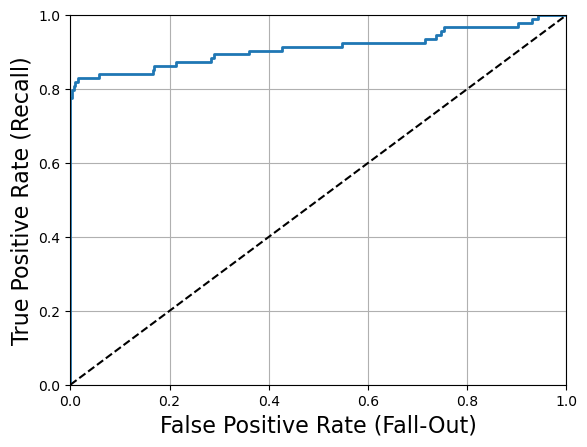

ROC AUC score: 0.9118824591179213

[[56648     3]
 [   37    57]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9286    0.6915    0.7927        94

    accuracy                         0.9994     56745
   macro avg     0.9640    0.8457    0.8962     56745
weighted avg     0.9994    0.9994    0.9994     56745




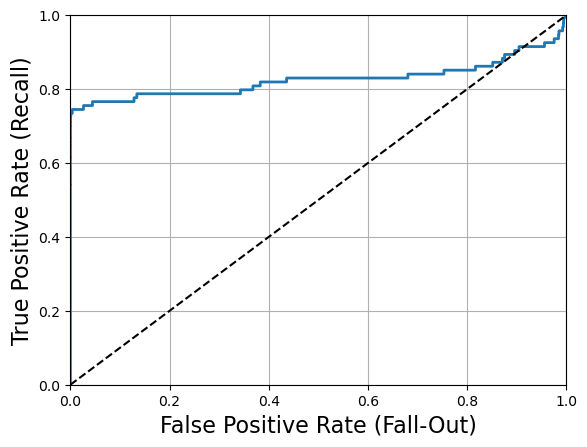

ROC AUC score: 0.8255903916364361

[[56646     5]
 [   29    65]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




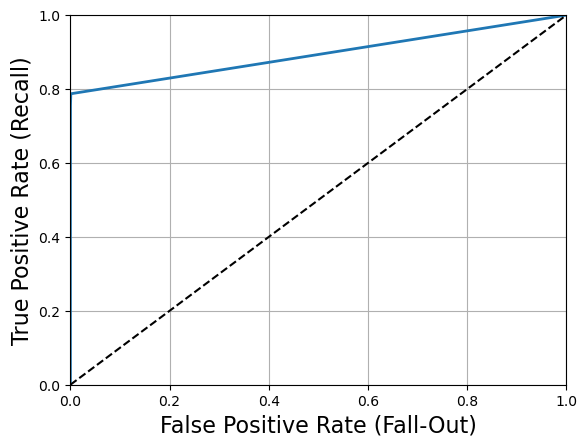

ROC AUC score: 0.8934885752519064

[[56645     6]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9788    0.9891     56651
           1     0.0580    0.7872    0.1081        94

    accuracy                         0.9785     56745
   macro avg     0.5288    0.8830    0.5486     56745
weighted avg     0.9981    0.9785    0.9877     56745




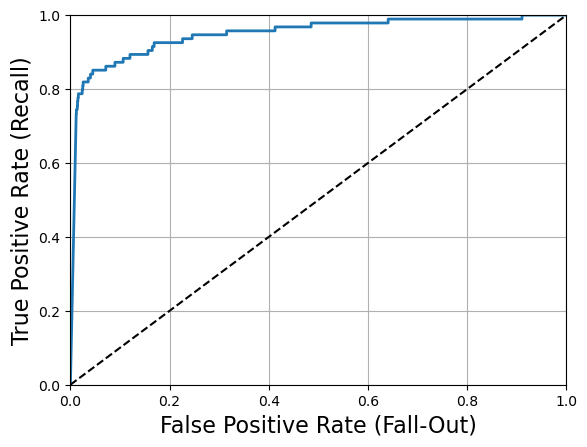

ROC AUC score: 0.9490880520033637

[[55450  1201]
 [   20    74]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8493    0.6596    0.7425        94

    accuracy                         0.9992     56745
   macro avg     0.9244    0.8297    0.8711     56745
weighted avg     0.9992    0.9992    0.9992     56745




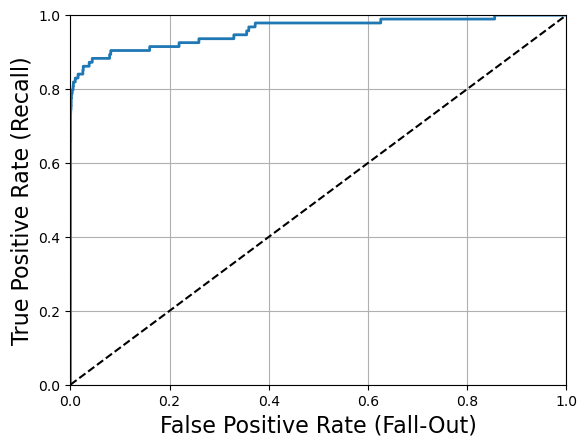

ROC AUC score: 0.9586892984556055

[[56640    11]
 [   32    62]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9762    0.9878     56651
           1     0.0534    0.8085    0.1001        94

    accuracy                         0.9759     56745
   macro avg     0.5265    0.8924    0.5440     56745
weighted avg     0.9981    0.9759    0.9863     56745




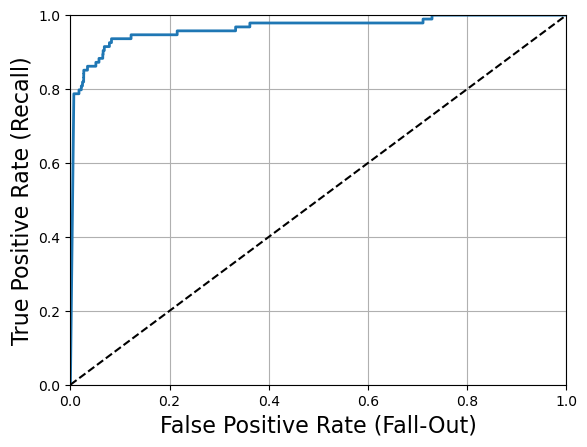

ROC AUC score: 0.9640726704041205

[[55303  1348]
 [   18    76]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9265    0.6702    0.7778        94

    accuracy                         0.9994     56745
   macro avg     0.9630    0.8351    0.8887     56745
weighted avg     0.9993    0.9994    0.9993     56745




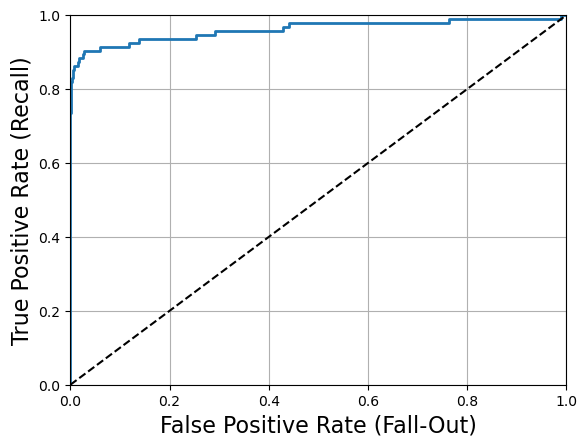

ROC AUC score: 0.9617424266608878

[[56646     5]
 [   31    63]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




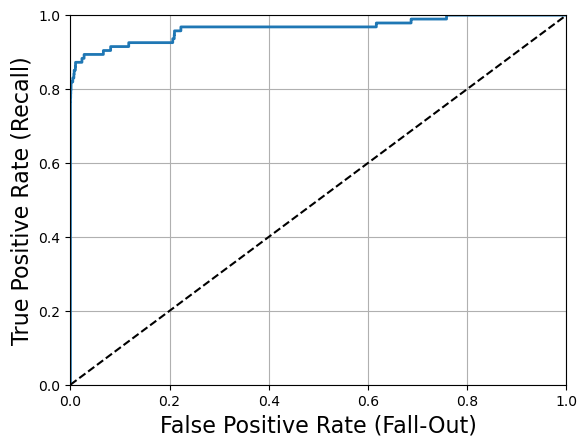

ROC AUC score: 0.9651948830408807

[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9296    0.7021    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9645    0.8510    0.8999     56745
weighted avg     0.9994    0.9994    0.9994     56745




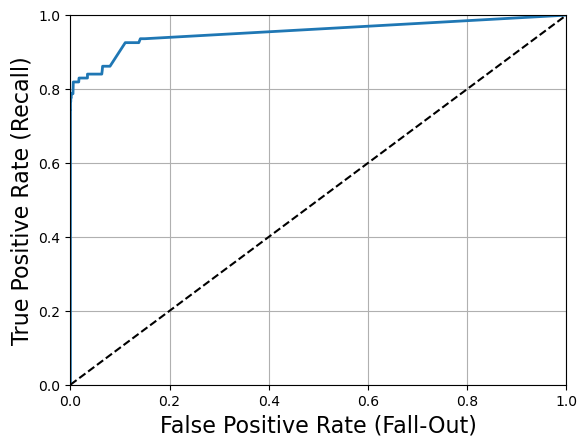

ROC AUC score: 0.9535932399833695

[[56646     5]
 [   28    66]]

Stored 'eval_dict_out' (dict)


In [32]:
eval_dict_out = model_tester(X_train_out, y_train_out, X_val_out, y_val_out)
%store eval_dict_out

In [33]:
eval_df_out = pd.DataFrame(data=eval_dict_out.values(), index=eval_dict_out.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_out

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.866977    0.932432  0.734043  0.821429                5   
brf_clf            0.908739    0.057288  0.840426  0.107264             1300   
lr_clf             0.765887    0.862069  0.531915  0.657895                8   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.845701    0.928571  0.691489  0.792683                5   
knn_clf            0.851011    0.916667  0.702128  0.795181                6   
gnb_clf            0.883017    0.058039  0.787234  0.108108             1201   
ada_clf            0.829690    0.849315  0.659574  0.742515               11   
qda_clf            0.892358    0.053371  0.808511  0.100132             1348   
mlp_clf            0.835062    0.926471  0.670213  0.777778                5   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851020    0.929577  0.702128  0.800000                5   

              false_negatives  train_time  test_time  
rf_clf                     25  129.442852   0.356081  
brf_clf                    15    2.903974   0.270059  
lr_clf                     44    0.979223   0.003001  
svc_rbf_clf                37  733.801017  10.659637  
svc_ploy_clf               29  523.344405   0.593134  
knn_clf                    28    0.034009   7.104128  
gnb_clf                    20    0.106024   0.032008  
ada_clf                    32   46.881333   0.428098  
qda_clf                    18    0.273061   0.051013  
mlp_clf                    31   17.249069   0.030006  
xgb_clf                    28    8.701999   0.024005  
xgbrf_clf                  28    9.791755   0.022004

### 6.2 'Time' → 'hours'
- Time variable transformed to categorical variable hour (example: hour_1)
- Amount variable scaled with MinMaxScaler()

In [35]:
clean_train_h = DataCleaner(hour=True, feature_to_drop=[], labels=True, amount_scaler=scaler_amount)

X_train_h, y_train_h = clean_train_h.fit_transform(raw_train)
X_val_h, y_val_h = clean_train_h.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




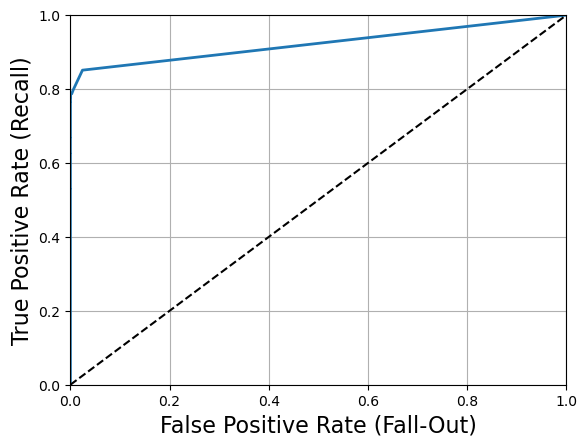

ROC AUC score: 0.9228537026068909

[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9767    0.9881     56651
           1     0.0565    0.8404    0.1060        94

    accuracy                         0.9765     56745
   macro avg     0.5281    0.9086    0.5470     56745
weighted avg     0.9982    0.9765    0.9866     56745




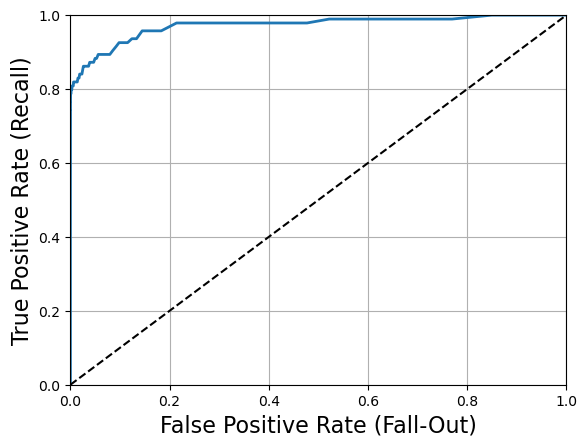

ROC AUC score: 0.9722519968286603

[[55333  1318]
 [   15    79]]

============ lr_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     56651
           1     0.8548    0.5638    0.6795        94

    accuracy                         0.9991     56745
   macro avg     0.9271    0.7818    0.8395     56745
weighted avg     0.9990    0.9991    0.9990     56745




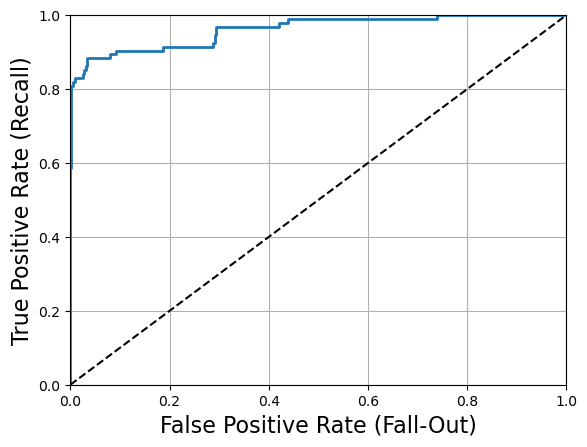

ROC AUC score: 0.9618006405024868

[[56642     9]
 [   41    53]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.9500    0.6064    0.7403        94

    accuracy                         0.9993     56745
   macro avg     0.9747    0.8032    0.8700     56745
weighted avg     0.9993    0.9993    0.9992     56745




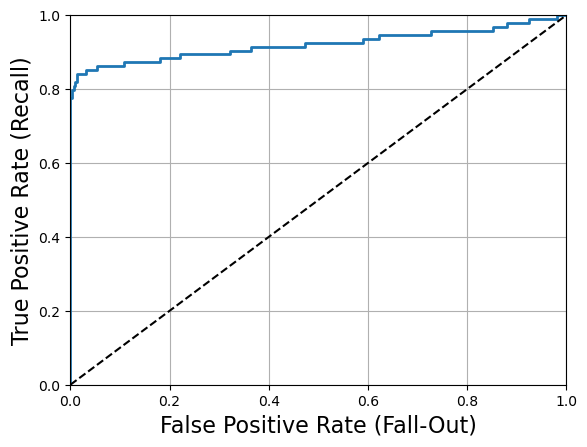

ROC AUC score: 0.9214809826646692

[[56648     3]
 [   37    57]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9178    0.7128    0.8024        94

    accuracy                         0.9994     56745
   macro avg     0.9587    0.8563    0.9011     56745
weighted avg     0.9994    0.9994    0.9994     56745




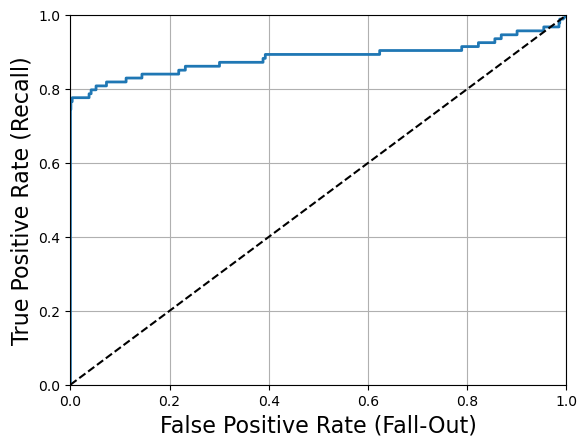

ROC AUC score: 0.8852957281931888

[[56645     6]
 [   27    67]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




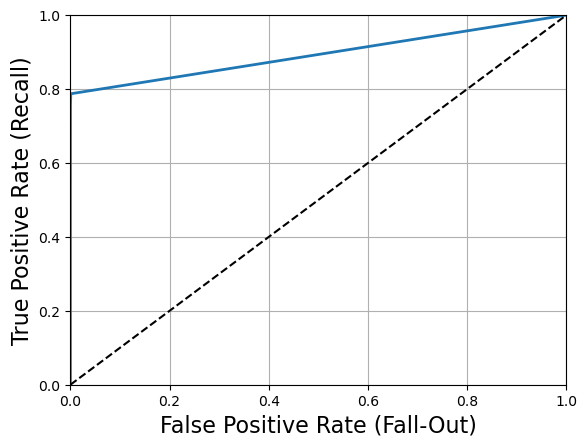

ROC AUC score: 0.8934950538891164

[[56645     6]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9531    0.9758     56651
           1     0.0267    0.7766    0.0517        94

    accuracy                         0.9528     56745
   macro avg     0.5132    0.8648    0.5138     56745
weighted avg     0.9980    0.9528    0.9743     56745




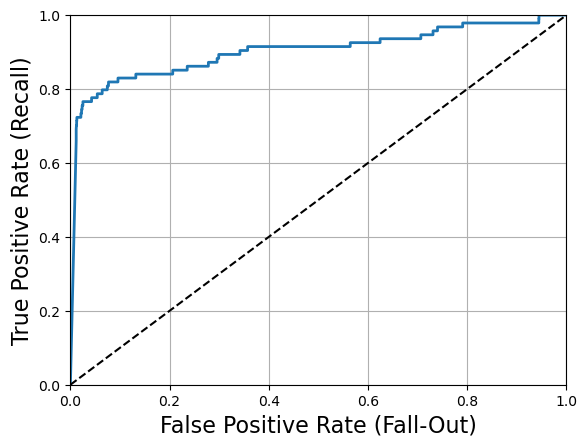

ROC AUC score: 0.9029025984781023

[[53994  2657]
 [   21    73]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8267    0.6596    0.7337        94

    accuracy                         0.9992     56745
   macro avg     0.9131    0.8297    0.8667     56745
weighted avg     0.9991    0.9992    0.9992     56745




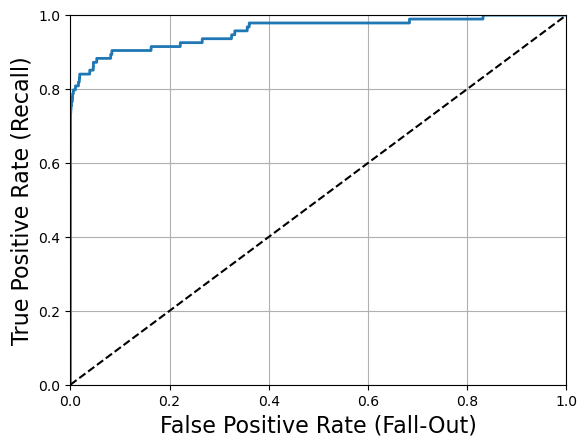

ROC AUC score: 0.9576944990173129

[[56638    13]
 [   32    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9704    0.9848     56651
           1     0.0418    0.7766    0.0793        94

    accuracy                         0.9701     56745
   macro avg     0.5207    0.8735    0.5320     56745
weighted avg     0.9980    0.9701    0.9833     56745




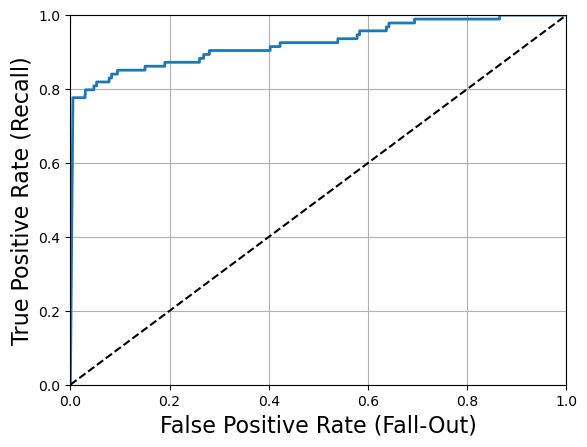

ROC AUC score: 0.9243734594457969

[[54976  1675]
 [   21    73]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8846    0.7340    0.8023        94

    accuracy                         0.9994     56745
   macro avg     0.9421    0.8669    0.9010     56745
weighted avg     0.9994    0.9994    0.9994     56745




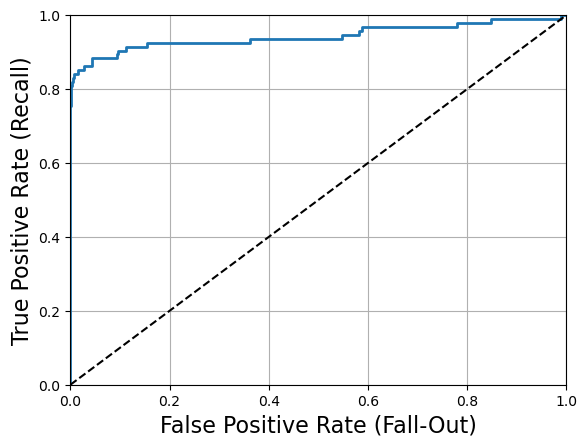

ROC AUC score: 0.9435725721917361

[[56642     9]
 [   25    69]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




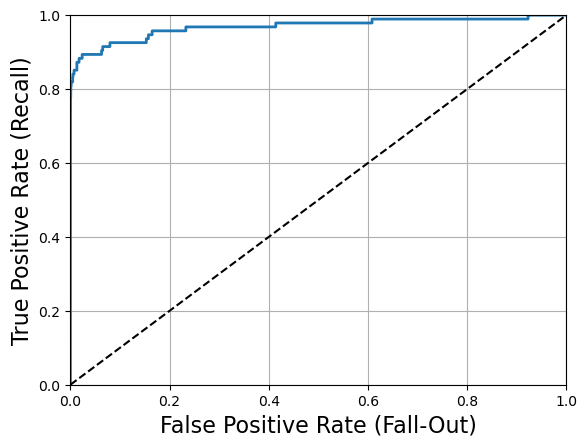

ROC AUC score: 0.9686105332500563

[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




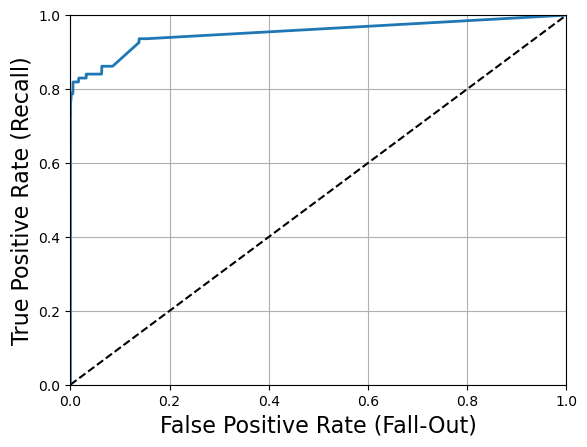

ROC AUC score: 0.9525569397096143

[[56645     6]
 [   28    66]]

Stored 'eval_dict_h' (dict)


In [36]:
eval_dict_h = model_tester(X_train_h, y_train_h, X_val_h, y_val_h )
%store eval_dict_h

In [37]:
eval_df_h = pd.DataFrame(data=eval_dict_h.values(), index=eval_dict_h.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_h

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.861658    0.931507  0.723404  0.814371                5   
brf_clf            0.908580    0.056550  0.840426  0.105969             1318   
lr_clf             0.781835    0.854839  0.563830  0.679487                9   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.856330    0.917808  0.712766  0.802395                6   
knn_clf            0.851011    0.916667  0.702128  0.795181                6   
gnb_clf            0.864847    0.026740  0.776596  0.051700             2657   
ada_clf            0.829672    0.826667  0.659574  0.733728               13   
qda_clf            0.873514    0.041762  0.776596  0.079262             1675   
mlp_clf            0.866942    0.884615  0.734043  0.802326                9   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851011    0.916667  0.702128  0.795181                6   

              false_negatives  train_time  test_time  
rf_clf                     26  120.884212   0.486110  
brf_clf                    15    3.407775   0.363083  
lr_clf                     41    2.255514   0.019004  
svc_rbf_clf                37  842.866665  10.495330  
svc_ploy_clf               27  133.112205   0.838191  
knn_clf                    28    0.053012   7.073777  
gnb_clf                    21    0.138032   0.064014  
ada_clf                    32   44.154064   0.529121  
qda_clf                    21    0.319072   0.080018  
mlp_clf                    25   20.909339   0.039008  
xgb_clf                    28    8.443921   0.036008  
xgbrf_clf                  28    9.153083   0.032007

### 6.3 'Amount' → log1p('Amount')
As distribution of 𝐴𝑚𝑜𝑢𝑛𝑡 is skewed we test whether transforming the variable with logaritmic function will have any positive effect on the models results.
- Time variable transformed to categorical variable hour
- 𝐴𝑚𝑜𝑢𝑛𝑡 log transformed and scaled with MinMaxScaler()

In [38]:
clean_train_log = DataCleaner(hour=True,feature_to_drop=['Amount'], labels=True, amount_scaler=scaler_amount, amount_log = True)

X_train_log, y_train_log = clean_train_log.fit_transform(raw_train)
X_val_log, y_val_log = clean_train_log.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




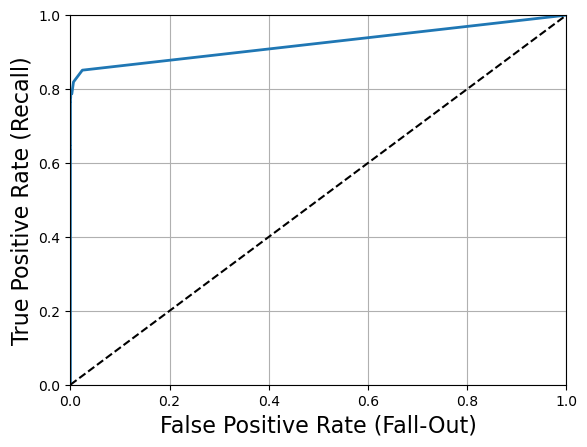

ROC AUC score: 0.9230843045342574

[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9770    0.9882     56651
           1     0.0578    0.8511    0.1083        94

    accuracy                         0.9768     56745
   macro avg     0.5288    0.9140    0.5483     56745
weighted avg     0.9982    0.9768    0.9868     56745




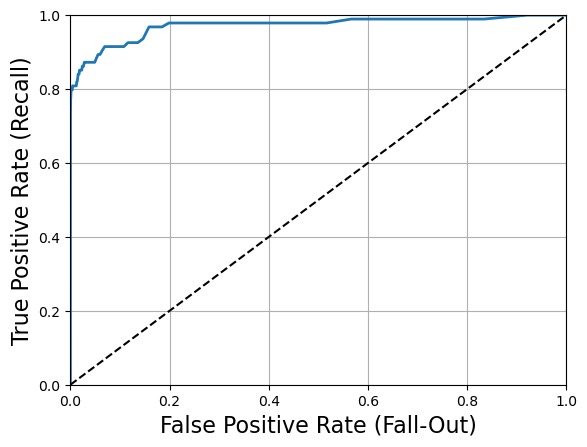

ROC AUC score: 0.9714975642201956

[[55348  1303]
 [   14    80]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.8689    0.5638    0.6839        94

    accuracy                         0.9991     56745
   macro avg     0.9341    0.7818    0.8417     56745
weighted avg     0.9991    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


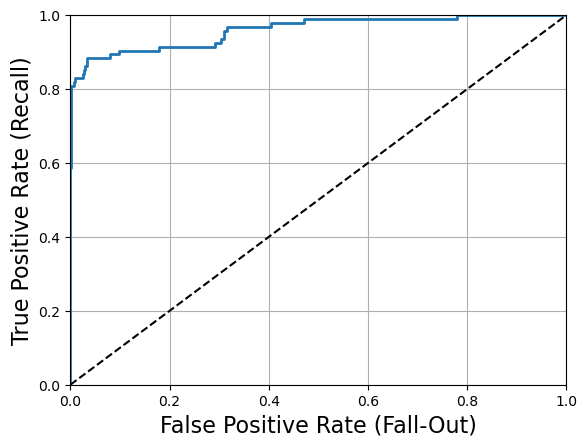

ROC AUC score: 0.9604190945907323

[[56643     8]
 [   41    53]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.9500    0.6064    0.7403        94

    accuracy                         0.9993     56745
   macro avg     0.9747    0.8032    0.8700     56745
weighted avg     0.9993    0.9993    0.9992     56745




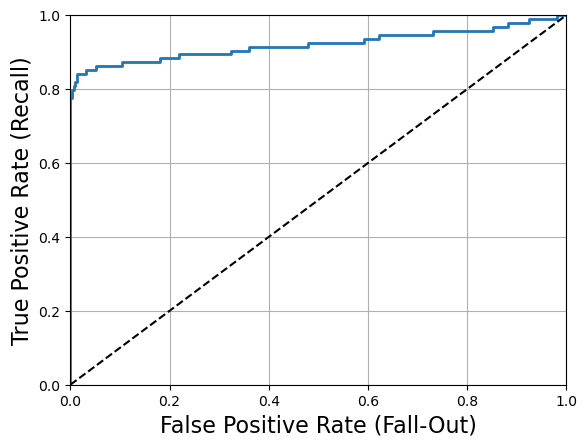

ROC AUC score: 0.9214015489388743

[[56648     3]
 [   37    57]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9178    0.7128    0.8024        94

    accuracy                         0.9994     56745
   macro avg     0.9587    0.8563    0.9011     56745
weighted avg     0.9994    0.9994    0.9994     56745




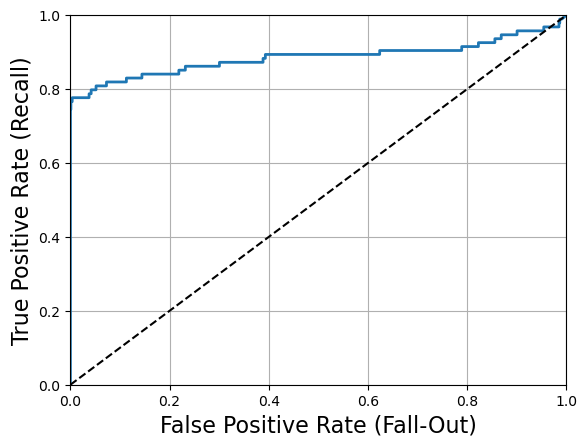

ROC AUC score: 0.8852986388852686

[[56645     6]
 [   27    67]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




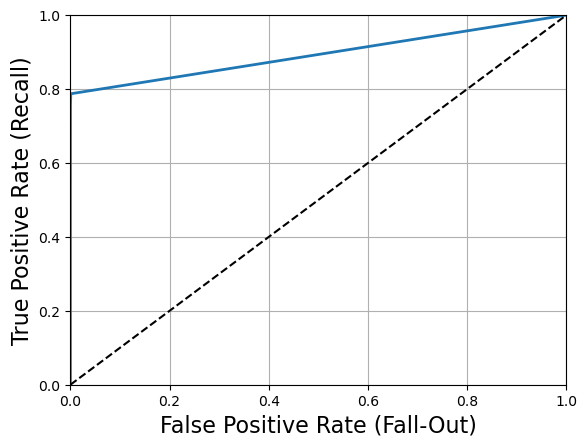

ROC AUC score: 0.8934950538891164

[[56645     6]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9527    0.9756     56651
           1     0.0265    0.7766    0.0512        94

    accuracy                         0.9524     56745
   macro avg     0.5131    0.8646    0.5134     56745
weighted avg     0.9980    0.9524    0.9740     56745




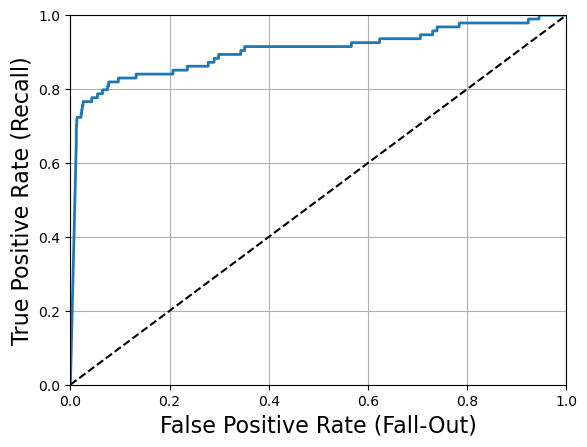

ROC AUC score: 0.9031712271890938

[[53969  2682]
 [   21    73]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9997     56651
           1     0.8571    0.7021    0.7719        94

    accuracy                         0.9993     56745
   macro avg     0.9283    0.8510    0.8858     56745
weighted avg     0.9993    0.9993    0.9993     56745




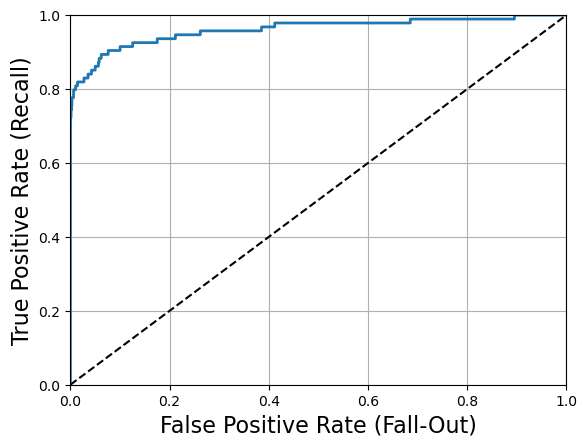

ROC AUC score: 0.9604906412799233

[[56640    11]
 [   28    66]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9610    0.9799     56651
           1     0.0320    0.7766    0.0614        94

    accuracy                         0.9607     56745
   macro avg     0.5158    0.8688    0.5207     56745
weighted avg     0.9980    0.9607    0.9784     56745




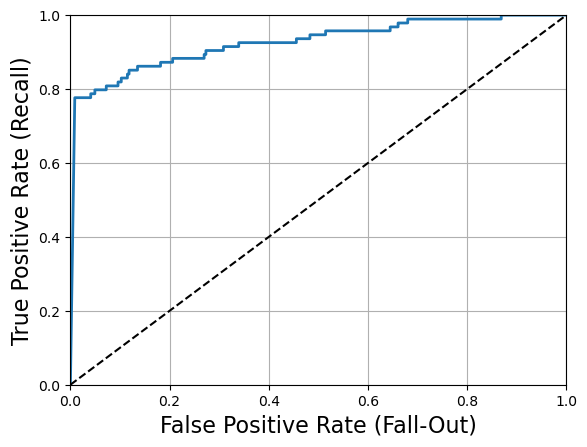

ROC AUC score: 0.9261976183402896

[[54441  2210]
 [   21    73]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.8904    0.6915    0.7784        94

    accuracy                         0.9993     56745
   macro avg     0.9449    0.8457    0.8891     56745
weighted avg     0.9993    0.9993    0.9993     56745




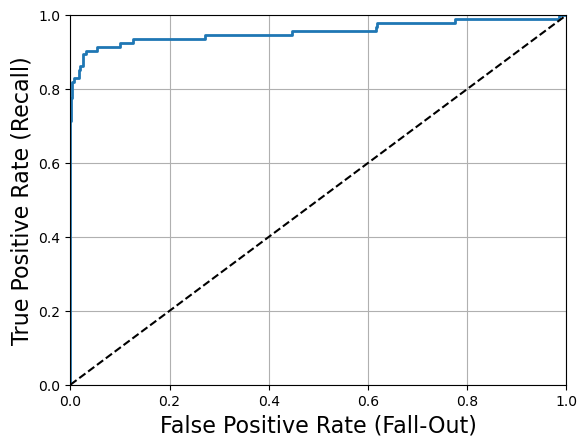

ROC AUC score: 0.9555234982988413

[[56643     8]
 [   29    65]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9559    0.6915    0.8025        94

    accuracy                         0.9994     56745
   macro avg     0.9777    0.8457    0.9011     56745
weighted avg     0.9994    0.9994    0.9994     56745




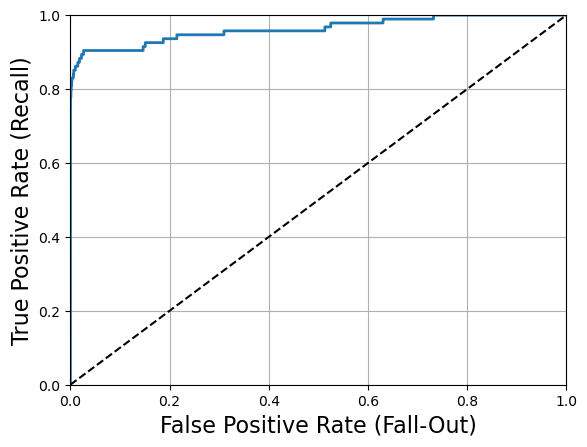

ROC AUC score: 0.9624929157510506

[[56648     3]
 [   29    65]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




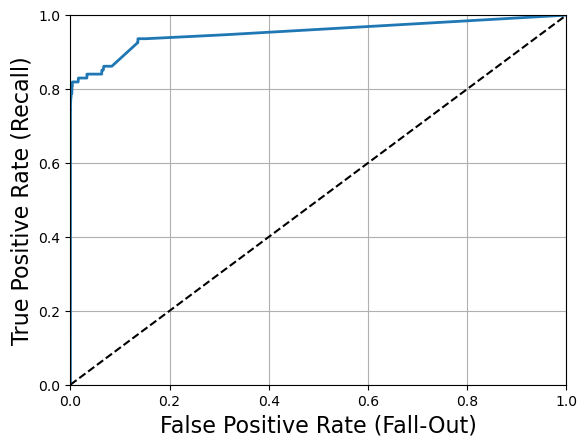

ROC AUC score: 0.9521761085136052

[[56645     6]
 [   28    66]]

Stored 'eval_dict_log' (dict)


In [39]:
eval_dict_log = model_tester(X_train_log, y_train_log, X_val_log, y_val_log)
%store eval_dict_log

In [40]:
eval_df_log = pd.DataFrame(data=eval_dict_log.values(), index=eval_dict_log.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_log

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.861658    0.931507  0.723404  0.814371                5   
brf_clf            0.914032    0.057845  0.851064  0.108328             1303   
lr_clf             0.781844    0.868852  0.563830  0.683871                8   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.856330    0.917808  0.712766  0.802395                6   
knn_clf            0.851011    0.916667  0.702128  0.795181                6   
gnb_clf            0.864627    0.026497  0.776596  0.051246             2682   
ada_clf            0.850967    0.857143  0.702128  0.771930               11   
qda_clf            0.868792    0.031975  0.776596  0.061422             2210   
mlp_clf            0.845674    0.890411  0.691489  0.778443                8   
xgb_clf            0.845718    0.955882  0.691489  0.802469                3   
xgbrf_clf          0.851011    0.916667  0.702128  0.795181                6   

              false_negatives  train_time  test_time  
rf_clf                     26  102.447843   0.397090  
brf_clf                    14    2.973676   0.292066  
lr_clf                     41    1.373312   0.011003  
svc_rbf_clf                37  802.551641  10.276432  
svc_ploy_clf               27  130.974354   0.768175  
knn_clf                    28    0.055012   7.044604  
gnb_clf                    21    0.140032   0.053012  
ada_clf                    28   43.089685   0.514117  
qda_clf                    21    0.285064   0.075016  
mlp_clf                    29   16.091227   0.038009  
xgb_clf                    29    8.103350   0.029006  
xgbrf_clf                  28    9.218862   0.032007

### 6.4 'Time' → MinMaxScaler('Time') / 'Amount' → RobustScaler('Amount')
- Time variable scaled with MinMaxScaler()
- Amount variable scaled with RobustScaler()

In [41]:
amount_scaler = RobustScaler()
time_scaler = MinMaxScaler(feature_range=(0,1))

In [43]:
clean_train_r = DataCleaner(hour=False, feature_to_drop=[], labels=True, amount_scaler=amount_scaler, time_scaler=time_scaler)

X_train_time_amt_robust, y_train = clean_train_r.fit_transform(raw_train)
X_val_time_amt_robust, y_val = clean_train_r.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




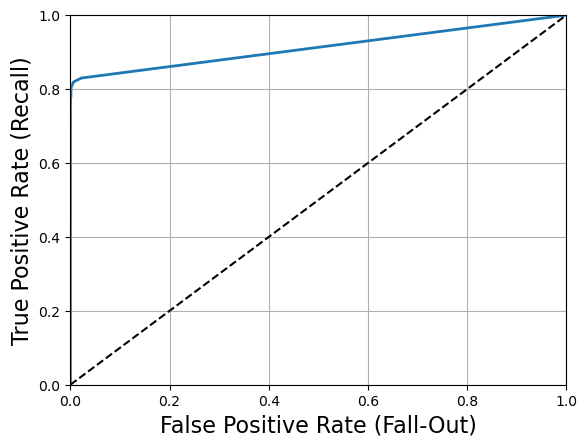

ROC AUC score: 0.9127567934614212

[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9762    0.9878     56651
           1     0.0553    0.8404    0.1037        94

    accuracy                         0.9759     56745
   macro avg     0.5275    0.9083    0.5458     56745
weighted avg     0.9982    0.9759    0.9863     56745




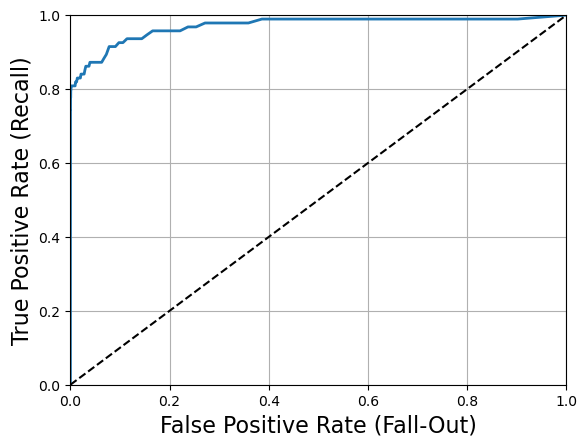

ROC AUC score: 0.9705821985076976

[[55301  1350]
 [   15    79]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9992    0.9999    0.9995     56651
           1     0.8621    0.5319    0.6579        94

    accuracy                         0.9991     56745
   macro avg     0.9306    0.7659    0.8287     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


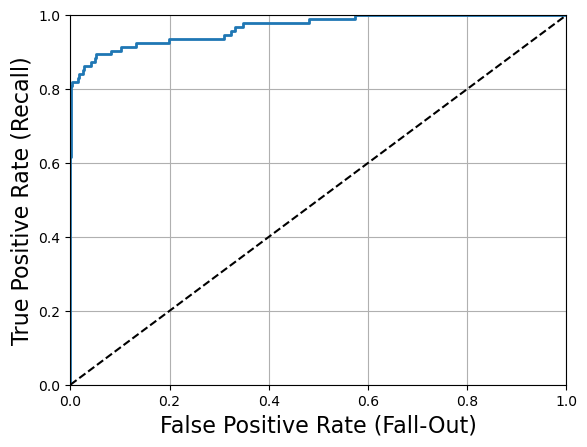

ROC AUC score: 0.9667351086176392

[[56643     8]
 [   44    50]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56651
           1     0.9524    0.6383    0.7643        94

    accuracy                         0.9993     56745
   macro avg     0.9759    0.8191    0.8820     56745
weighted avg     0.9993    0.9993    0.9993     56745




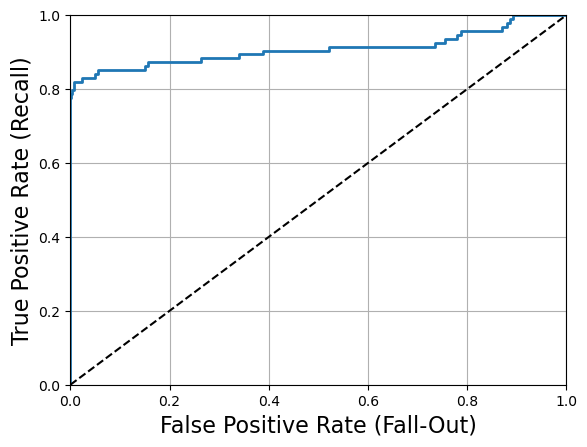

ROC AUC score: 0.9090051930502439

[[56648     3]
 [   34    60]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9420    0.6915    0.7975        94

    accuracy                         0.9994     56745
   macro avg     0.9708    0.8457    0.8986     56745
weighted avg     0.9994    0.9994    0.9994     56745




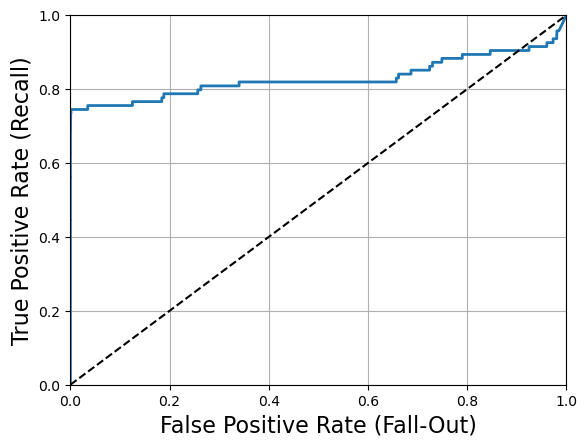

ROC AUC score: 0.8294593586637408

[[56647     4]
 [   29    65]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9429    0.7021    0.8049        94

    accuracy                         0.9994     56745
   macro avg     0.9712    0.8510    0.9023     56745
weighted avg     0.9994    0.9994    0.9994     56745




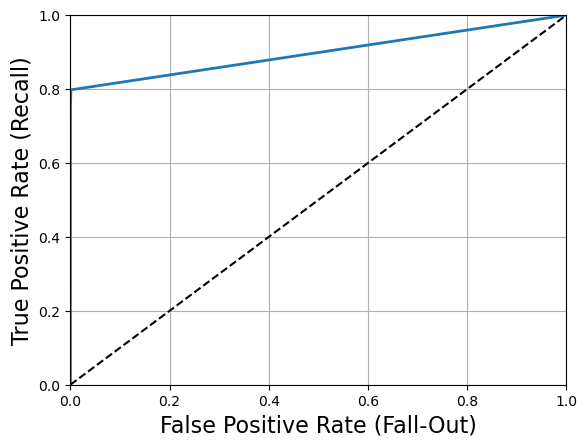

ROC AUC score: 0.8988019028039167

[[56647     4]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9788    0.9891     56651
           1     0.0580    0.7872    0.1081        94

    accuracy                         0.9785     56745
   macro avg     0.5288    0.8830    0.5486     56745
weighted avg     0.9981    0.9785    0.9877     56745




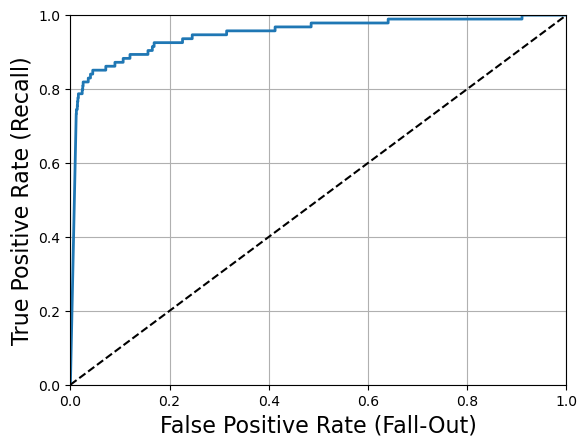

ROC AUC score: 0.9490815733661535

[[55450  1201]
 [   20    74]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8493    0.6596    0.7425        94

    accuracy                         0.9992     56745
   macro avg     0.9244    0.8297    0.8711     56745
weighted avg     0.9992    0.9992    0.9992     56745




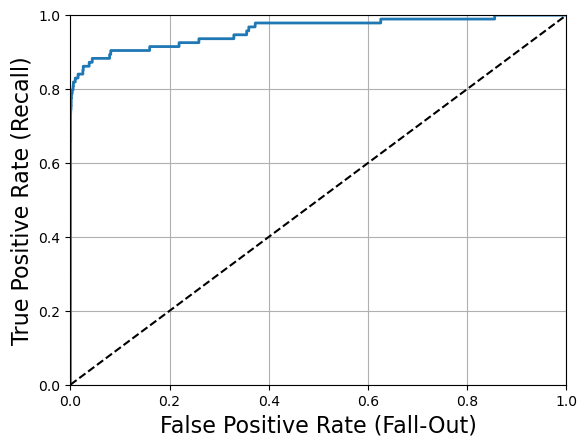

ROC AUC score: 0.9586892984556055

[[56640    11]
 [   32    62]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9762    0.9878     56651
           1     0.0534    0.8085    0.1001        94

    accuracy                         0.9759     56745
   macro avg     0.5265    0.8924    0.5440     56745
weighted avg     0.9981    0.9759    0.9863     56745




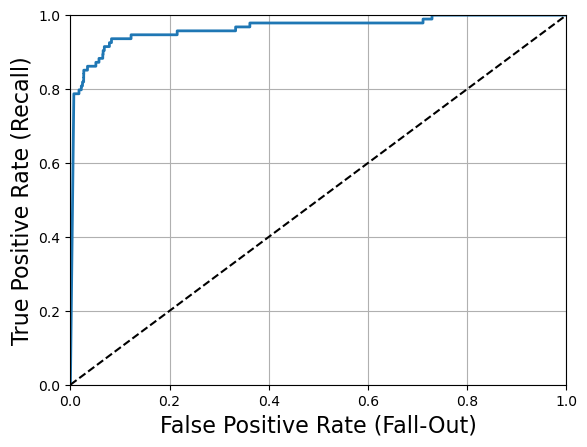

ROC AUC score: 0.9640726704041205

[[55303  1348]
 [   18    76]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.8919    0.7021    0.7857        94

    accuracy                         0.9994     56745
   macro avg     0.9457    0.8510    0.8927     56745
weighted avg     0.9993    0.9994    0.9993     56745




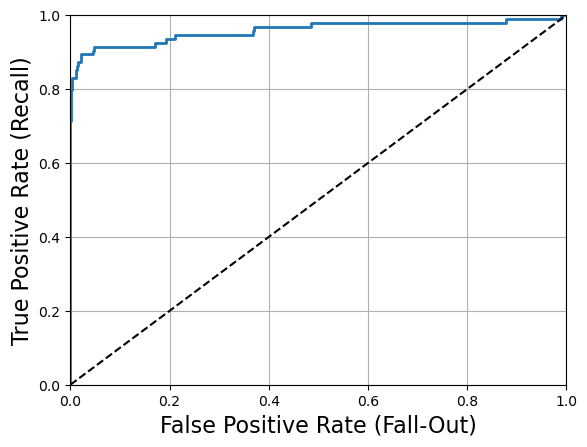

ROC AUC score: 0.9588707941907842

[[56643     8]
 [   28    66]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




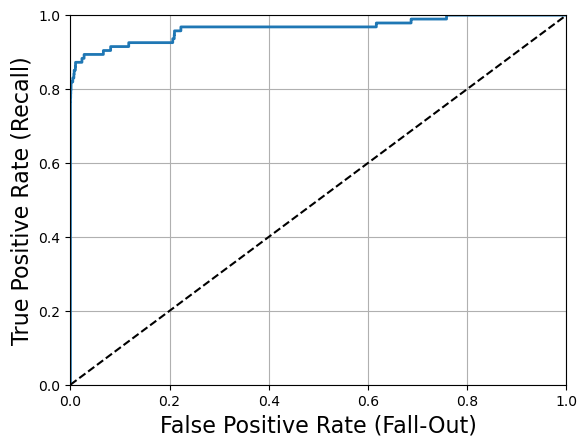

ROC AUC score: 0.9651948830408807

[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9296    0.7021    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9645    0.8510    0.8999     56745
weighted avg     0.9994    0.9994    0.9994     56745




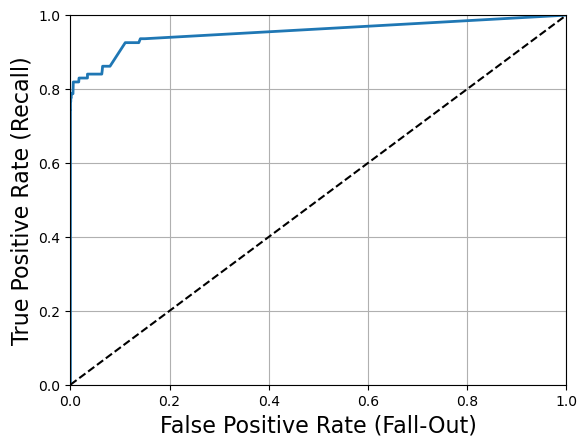

ROC AUC score: 0.9535932399833695

[[56646     5]
 [   28    66]]

Stored 'eval_dict_time' (dict)


In [44]:
eval_dict_time = model_tester(X_train=X_train_time_amt_robust, y_train=y_train,\
                                             X_val=X_val_time_amt_robust, y_val=y_val)
%store eval_dict_time

In [45]:
eval_df_time = pd.DataFrame(data=eval_dict_time.values(), index=eval_dict_time.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_time

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.861658    0.931507  0.723404  0.814371                5   
brf_clf            0.908298    0.055283  0.840426  0.103743             1350   
lr_clf             0.765887    0.862069  0.531915  0.657895                8   
svc_rbf_clf        0.819122    0.952381  0.638298  0.764331                3   
svc_ploy_clf       0.845709    0.942029  0.691489  0.797546                4   
knn_clf            0.851029    0.942857  0.702128  0.804878                4   
gnb_clf            0.883017    0.058039  0.787234  0.108108             1201   
ada_clf            0.829690    0.849315  0.659574  0.742515               11   
qda_clf            0.892358    0.053371  0.808511  0.100132             1348   
mlp_clf            0.850993    0.891892  0.702128  0.785714                8   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851020    0.929577  0.702128  0.800000                5   

              false_negatives   train_time  test_time  
rf_clf                     26   131.248532   0.359080  
brf_clf                    15     2.899661   0.274062  
lr_clf                     44     0.983223   0.003000  
svc_rbf_clf                34  1054.901815   9.216419  
svc_ploy_clf               29    62.233958   0.518118  
knn_clf                    28     0.025005   6.566495  
gnb_clf                    20     0.077017   0.030007  
ada_clf                    32    44.078664   0.368084  
qda_clf                    18     0.164036   0.038009  
mlp_clf                    28    15.787645   0.034008  
xgb_clf                    28     7.489306   0.018004  
xgbrf_clf                  28     8.857136   0.019004

### 6.5 'Time' → 'hours' / 'Amount' → RobustScaler('Amount')
- Time variable transformed to categorical variable hour
- Amount variable scaled with RobustScaler()

In [46]:
clean_train_hour = DataCleaner(hour=True, feature_to_drop=[], labels=True, amount_scaler=amount_scaler, time_scaler=None)

X_train_hour_amt_robust, y_train = clean_train_hour.fit_transform(raw_train)
X_val_hour_amt_robust, y_val = clean_train_hour.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9324    0.7340    0.8214        94

    accuracy                         0.9995     56745
   macro avg     0.9660    0.8670    0.9106     56745
weighted avg     0.9994    0.9995    0.9994     56745




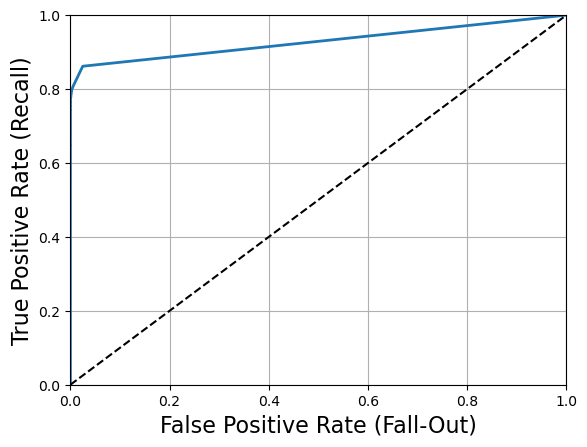

ROC AUC score: 0.9282180142169467

[[56646     5]
 [   25    69]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9766    0.9880     56651
           1     0.0562    0.8404    0.1053        94

    accuracy                         0.9764     56745
   macro avg     0.5280    0.9085    0.5467     56745
weighted avg     0.9982    0.9764    0.9866     56745




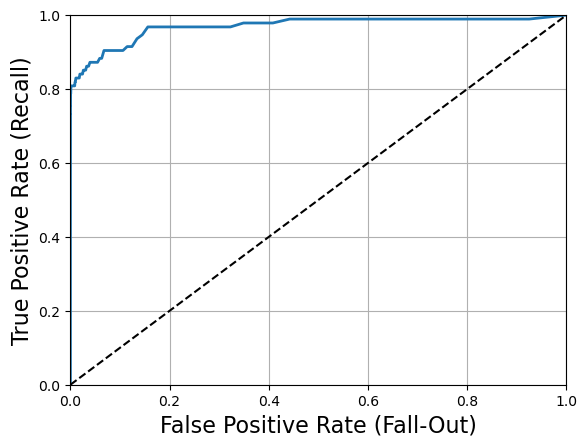

ROC AUC score: 0.9695515318315163

[[55324  1327]
 [   15    79]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     56651
           1     0.8548    0.5638    0.6795        94

    accuracy                         0.9991     56745
   macro avg     0.9271    0.7818    0.8395     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


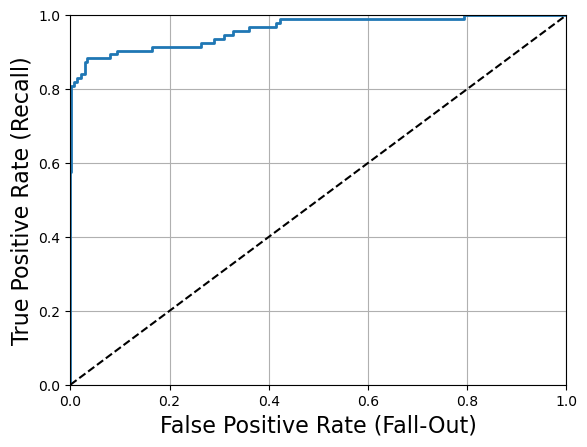

ROC AUC score: 0.9607188019816744

[[56642     9]
 [   41    53]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56651
           1     0.9524    0.6383    0.7643        94

    accuracy                         0.9993     56745
   macro avg     0.9759    0.8191    0.8820     56745
weighted avg     0.9993    0.9993    0.9993     56745




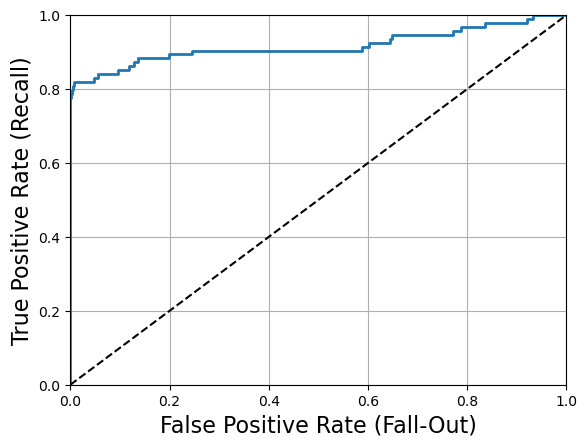

ROC AUC score: 0.917305360142748

[[56648     3]
 [   34    60]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9306    0.7128    0.8072        94

    accuracy                         0.9994     56745
   macro avg     0.9650    0.8563    0.9035     56745
weighted avg     0.9994    0.9994    0.9994     56745




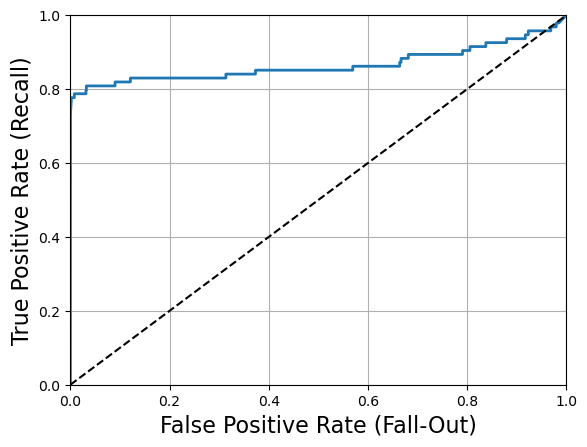

ROC AUC score: 0.8655068716745343

[[56646     5]
 [   27    67]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9296    0.7021    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9645    0.8510    0.8999     56745
weighted avg     0.9994    0.9994    0.9994     56745




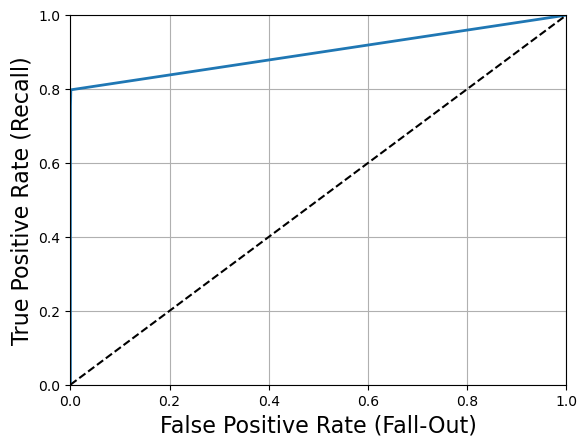

ROC AUC score: 0.898807160828319

[[56646     5]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9531    0.9758     56651
           1     0.0267    0.7766    0.0517        94

    accuracy                         0.9528     56745
   macro avg     0.5132    0.8648    0.5138     56745
weighted avg     0.9980    0.9528    0.9743     56745




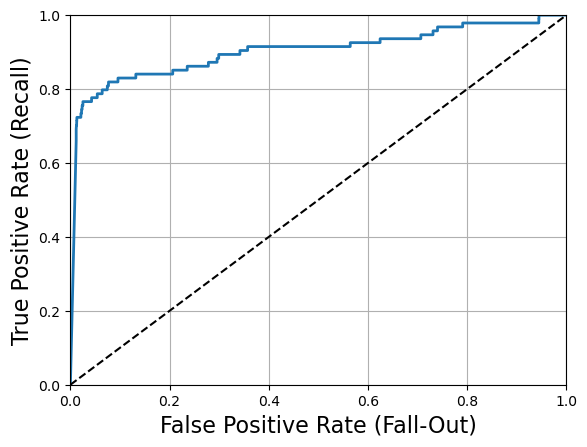

ROC AUC score: 0.902902974051274

[[53994  2657]
 [   21    73]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8267    0.6596    0.7337        94

    accuracy                         0.9992     56745
   macro avg     0.9131    0.8297    0.8667     56745
weighted avg     0.9991    0.9992    0.9992     56745




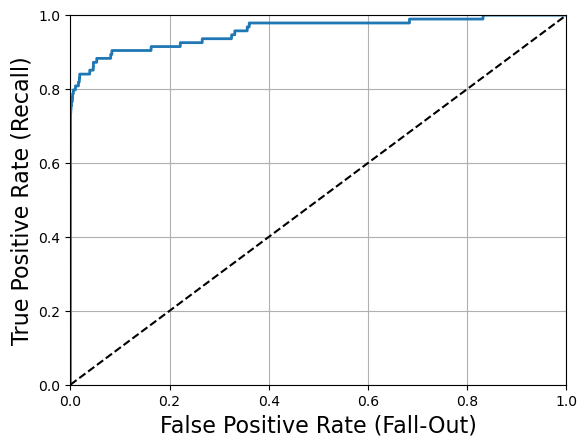

ROC AUC score: 0.9576944990173129

[[56638    13]
 [   32    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9651    0.9821     56651
           1     0.0361    0.7872    0.0691        94

    accuracy                         0.9648     56745
   macro avg     0.5179    0.8762    0.5256     56745
weighted avg     0.9980    0.9648    0.9806     56745




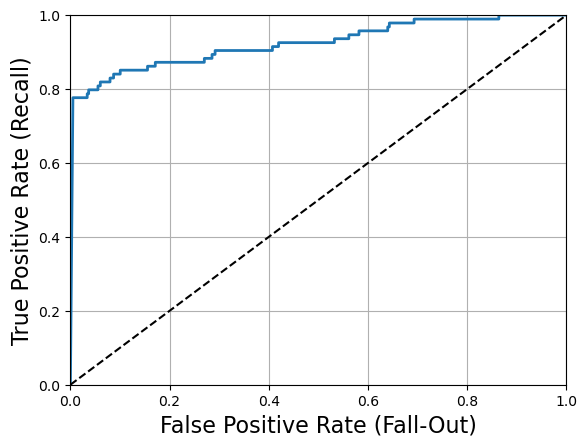

ROC AUC score: 0.923967558740583

[[54676  1975]
 [   20    74]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9143    0.6809    0.7805        94

    accuracy                         0.9994     56745
   macro avg     0.9569    0.8404    0.8901     56745
weighted avg     0.9993    0.9994    0.9993     56745




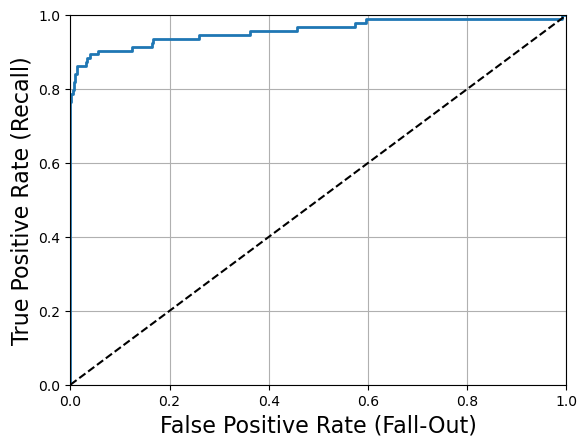

ROC AUC score: 0.9582877168418653

[[56645     6]
 [   30    64]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




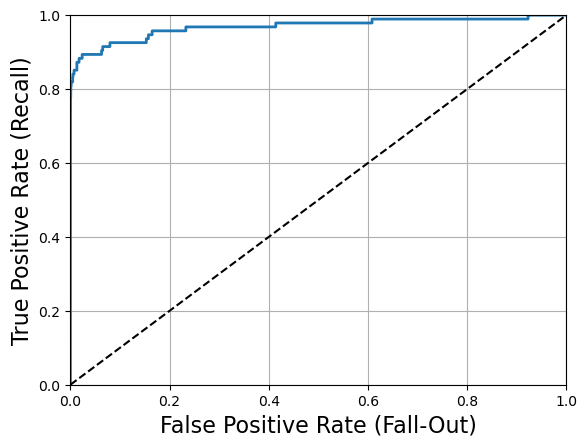

ROC AUC score: 0.9686105332500563

[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




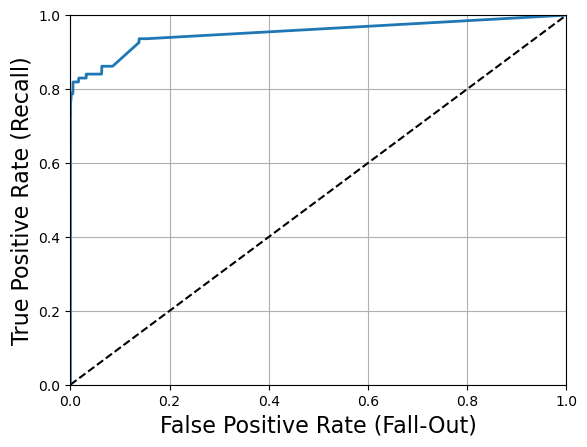

ROC AUC score: 0.9525569397096143

[[56645     6]
 [   28    66]]

Stored 'eval_dict_rob' (dict)


In [47]:
eval_dict_rob = model_tester(X_train=X_train_hour_amt_robust, y_train=y_train,\
                                             X_val=X_val_hour_amt_robust, y_val=y_val)

%store eval_dict_rob

In [48]:
eval_df_rob = pd.DataFrame(data=eval_dict_rob.values(), index=eval_dict_rob.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_rob

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.866977    0.932432  0.734043  0.821429                5   
brf_clf            0.908501    0.056188  0.840426  0.105333             1327   
lr_clf             0.781835    0.854839  0.563830  0.679487                9   
svc_rbf_clf        0.819122    0.952381  0.638298  0.764331                3   
svc_ploy_clf       0.856339    0.930556  0.712766  0.807229                5   
knn_clf            0.851020    0.929577  0.702128  0.800000                5   
gnb_clf            0.864847    0.026740  0.776596  0.051700             2657   
ada_clf            0.829672    0.826667  0.659574  0.733728               13   
qda_clf            0.876186    0.036115  0.787234  0.069062             1975   
mlp_clf            0.840373    0.914286  0.680851  0.780488                6   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851011    0.916667  0.702128  0.795181                6   

              false_negatives  train_time  test_time  
rf_clf                     25  103.687859   0.379086  
brf_clf                    15    2.938669   0.296067  
lr_clf                     41    1.469485   0.013003  
svc_rbf_clf                34  694.852048   9.023567  
svc_ploy_clf               27   85.501182   0.730166  
knn_clf                    28    0.055013   7.087612  
gnb_clf                    21    0.137032   0.058014  
ada_clf                    32   43.953234   0.527120  
qda_clf                    20    0.315071   0.080018  
mlp_clf                    30   18.027004   0.039009  
xgb_clf                    28    8.382908   0.032007  
xgbrf_clf                  28    9.161778   0.031007

### 6.6 'Time' → 'hours' / 'Amount' → RobustScaler(log1p('Amount'))
- Time variable transformed to categorical variable hour
- Amount variable log transformed and scaled with RobustScaler()

In [240]:
clean_train_hour_log = DataCleaner(hour=True, feature_to_drop=[], labels=True,\
                                   amount_scaler=amount_scaler, time_scaler=None, amount_log=True)

X_train_hour_amt_robust_log, y_train = clean_train_hour_log.fit_transform(raw_train)
X_val_hour_amt_robust_log, y_val = clean_train_hour_log.transform(raw_val)

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9333    0.7447    0.8284        94

    accuracy                         0.9995     56745
   macro avg     0.9665    0.8723    0.9141     56745
weighted avg     0.9995    0.9995    0.9995     56745




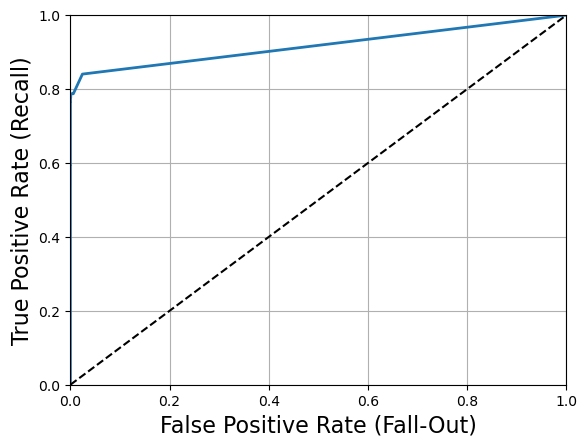

ROC AUC score: 0.917458781783349

[[56646     5]
 [   24    70]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9765    0.9880     56651
           1     0.0561    0.8404    0.1051        94

    accuracy                         0.9763     56745
   macro avg     0.5279    0.9085    0.5466     56745
weighted avg     0.9982    0.9763    0.9865     56745




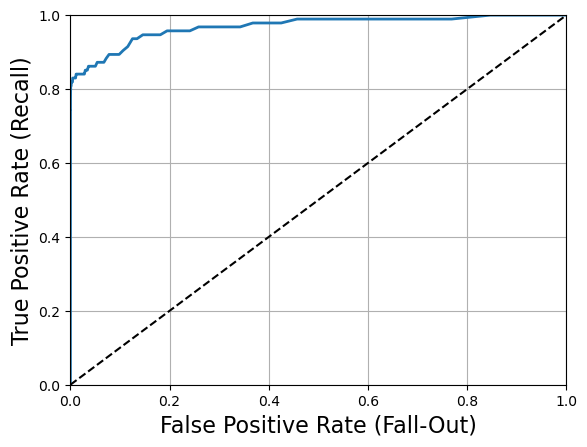

ROC AUC score: 0.9689063910159893

[[55321  1330]
 [   15    79]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     56651
           1     0.8438    0.5745    0.6835        94

    accuracy                         0.9991     56745
   macro avg     0.9215    0.7871    0.8416     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


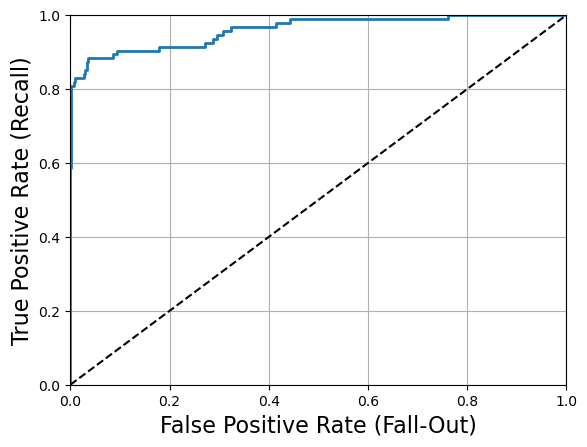

ROC AUC score: 0.9611071446411154

[[56641    10]
 [   40    54]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.9500    0.6064    0.7403        94

    accuracy                         0.9993     56745
   macro avg     0.9747    0.8032    0.8700     56745
weighted avg     0.9993    0.9993    0.9992     56745




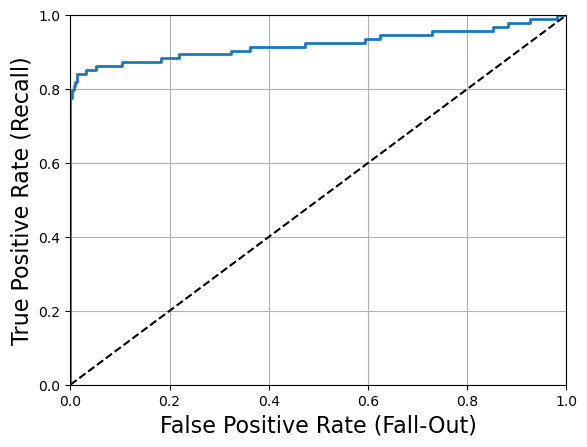

ROC AUC score: 0.9214167596523245

[[56648     3]
 [   37    57]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9178    0.7128    0.8024        94

    accuracy                         0.9994     56745
   macro avg     0.9587    0.8563    0.9011     56745
weighted avg     0.9994    0.9994    0.9994     56745




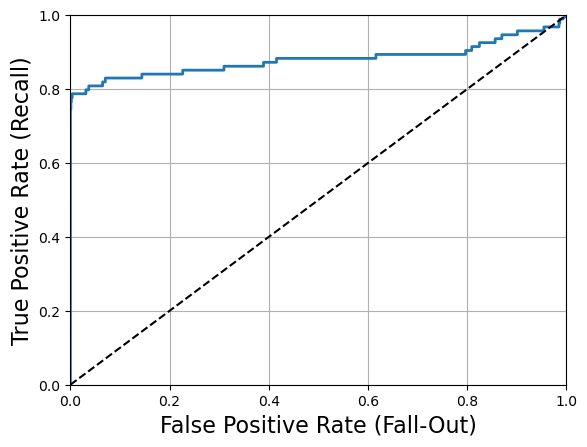

ROC AUC score: 0.8798500110981873

[[56645     6]
 [   27    67]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




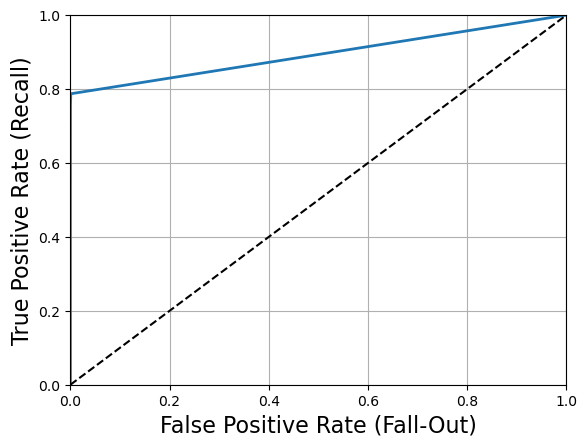

ROC AUC score: 0.8934950538891164

[[56645     6]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9528    0.9756     56651
           1     0.0266    0.7766    0.0514        94

    accuracy                         0.9525     56745
   macro avg     0.5131    0.8647    0.5135     56745
weighted avg     0.9980    0.9525    0.9741     56745




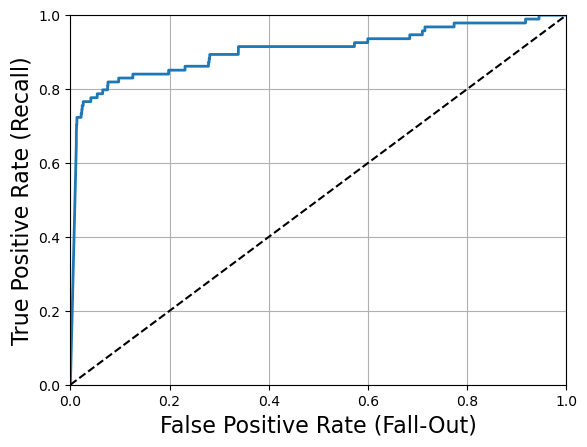

ROC AUC score: 0.9048874087967499

[[53976  2675]
 [   21    73]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8267    0.6596    0.7337        94

    accuracy                         0.9992     56745
   macro avg     0.9131    0.8297    0.8667     56745
weighted avg     0.9991    0.9992    0.9992     56745




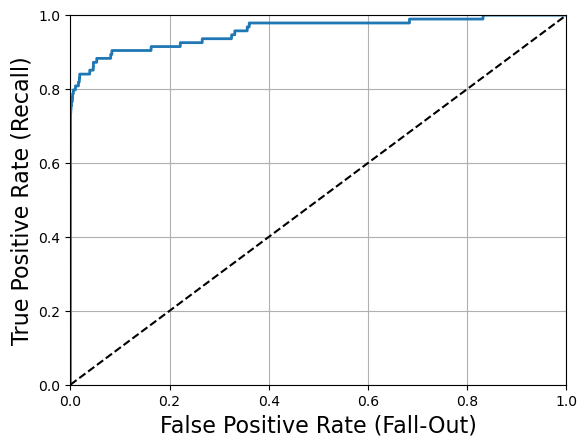

ROC AUC score: 0.9576944990173129

[[56638    13]
 [   32    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9588    0.9788     56651
           1     0.0307    0.7872    0.0592        94

    accuracy                         0.9585     56745
   macro avg     0.5152    0.8730    0.5190     56745
weighted avg     0.9980    0.9585    0.9773     56745




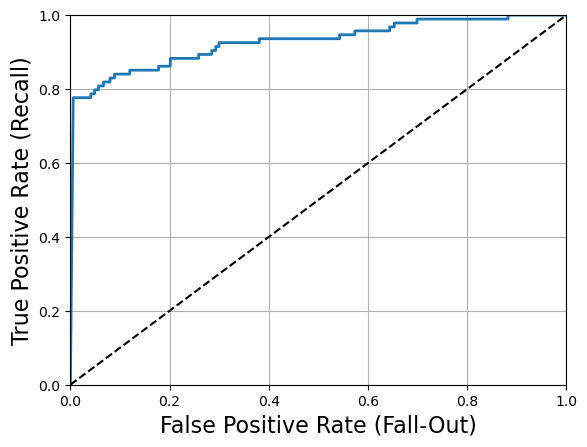

ROC AUC score: 0.92773014466703

[[54317  2334]
 [   20    74]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8642    0.7447    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9319    0.8722    0.8998     56745
weighted avg     0.9994    0.9994    0.9994     56745




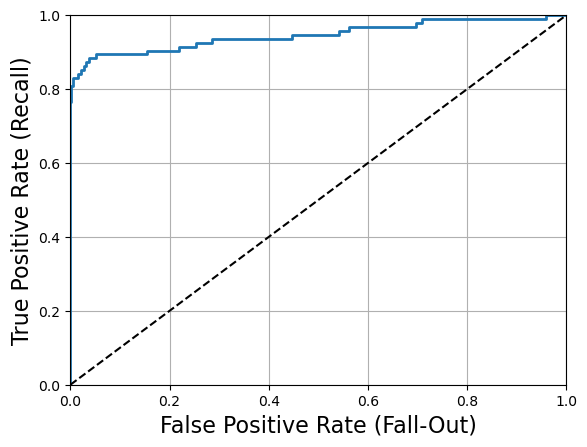

ROC AUC score: 0.9465157513510306

[[56640    11]
 [   24    70]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




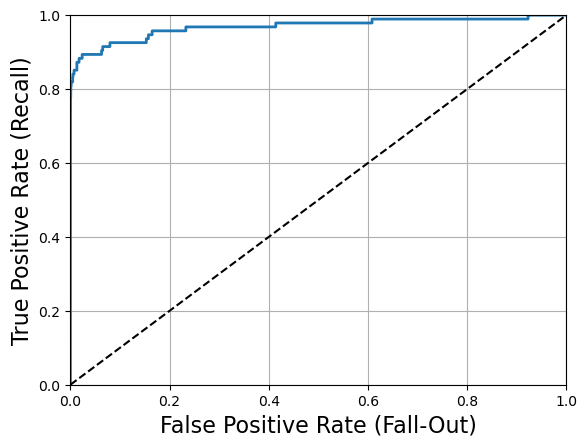

ROC AUC score: 0.9686105332500563

[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




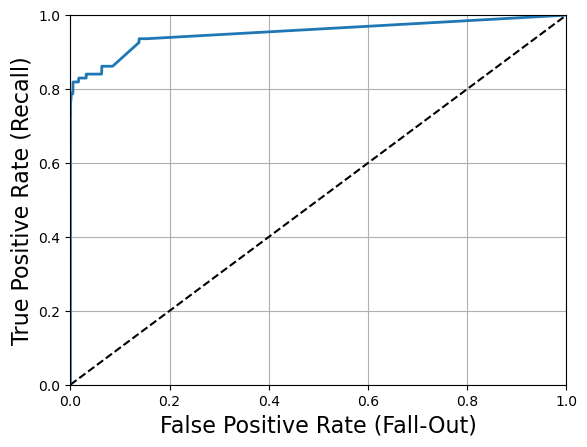

ROC AUC score: 0.9525569397096143

[[56645     6]
 [   28    66]]

Stored 'eval_dict_hours_log' (dict)


In [50]:
eval_dict_hours_log = model_tester(X_train=X_train_hour_amt_robust_log, y_train=y_train,\
                                                       X_val=X_val_hour_amt_robust_log, y_val=y_val) 
%store eval_dict_hours_log

In [51]:
eval_df_hour_log = pd.DataFrame(data=eval_dict_hours_log.values(), index=eval_dict_hours_log.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_hour_log

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.872296    0.933333  0.744681  0.828402                5   
brf_clf            0.908474    0.056068  0.840426  0.105123             1330   
lr_clf             0.787146    0.843750  0.574468  0.683544               10   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.856330    0.917808  0.712766  0.802395                6   
knn_clf            0.851011    0.916667  0.702128  0.795181                6   
gnb_clf            0.864688    0.026565  0.776596  0.051372             2675   
ada_clf            0.829672    0.826667  0.659574  0.733728               13   
qda_clf            0.873017    0.030731  0.787234  0.059153             2334   
mlp_clf            0.872243    0.864198  0.744681  0.800000               11   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851011    0.916667  0.702128  0.795181                6   

              false_negatives  train_time  test_time  
rf_clf                     24  101.066854   0.385088  
brf_clf                    15    2.920665   0.289066  
lr_clf                     40    1.444329   0.011003  
svc_rbf_clf                37  857.983541  10.541399  
svc_ploy_clf               27  114.864241   0.852195  
knn_clf                    28    0.054012   6.974096  
gnb_clf                    21    0.149034   0.057013  
ada_clf                    32   44.179768   0.526120  
qda_clf                    20    0.315071   0.082019  
mlp_clf                    24   23.149606   0.043010  
xgb_clf                    28    8.571658   0.044010  
xgbrf_clf                  28    9.147081   0.034008

In [52]:
default_model_evals = pd.concat([eval_df_out, eval_df_h, eval_df_log, eval_df_time, eval_df_rob, eval_df_hour_log], axis=0)
default_model_evals

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.866977    0.932432  0.734043  0.821429                5   
brf_clf            0.908739    0.057288  0.840426  0.107264             1300   
lr_clf             0.765887    0.862069  0.531915  0.657895                8   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.845701    0.928571  0.691489  0.792683                5   
...                     ...         ...       ...       ...              ...   
ada_clf            0.829672    0.826667  0.659574  0.733728               13   
qda_clf            0.873017    0.030731  0.787234  0.059153             2334   
mlp_clf            0.872243    0.864198  0.744681  0.800000               11   
xgb_clf            0.851037    0.956522  0.702128  0.809816                3   
xgbrf_clf          0.851011    0.916667  0.702128  0.795181                6   

              false_negatives  train_time  test_time  
rf_clf                     25  129.442852   0.356081  
brf_clf                    15    2.903974   0.270059  
lr_clf                     44    0.979223   0.003001  
svc_rbf_clf                37  733.801017  10.659637  
svc_ploy_clf               29  523.344405   0.593134  
...                       ...         ...        ...  
ada_clf                    32   44.179768   0.526120  
qda_clf                    20    0.315071   0.082019  
mlp_clf                    24   23.149606   0.043010  
xgb_clf                    28    8.571658   0.044010  
xgbrf_clf                  28    9.147081   0.034008  

[72 rows x 8 columns]

### 6.7 Feature selection

# Needs more details (example, why we didnt do feature selection in the end)
- Random Forest feature importance
- Logistic Regression with Lasso loss function
- Mutual information
- Forward selection
- Backward selection
- Best subset selection

#### 6.7.1 Mutual information of the transformed features 
'Time' → 'hours' / 'Amount' → RobustScaler(log1p('Amount'))

Mutual information describes relationships in terms of uncertainty.\
The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.\
If you knew the value of a feature, how much more confident would you be about the target?\
(source: https://www.kaggle.com/code/ryanholbrook/mutual-information)

More easy definition:\
Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

In [53]:
mi_scores_hour_rob_log = make_mi_scores(X=X_train_hour_amt_robust_log, y=y_train)
%store mi_scores_hour_rob_log

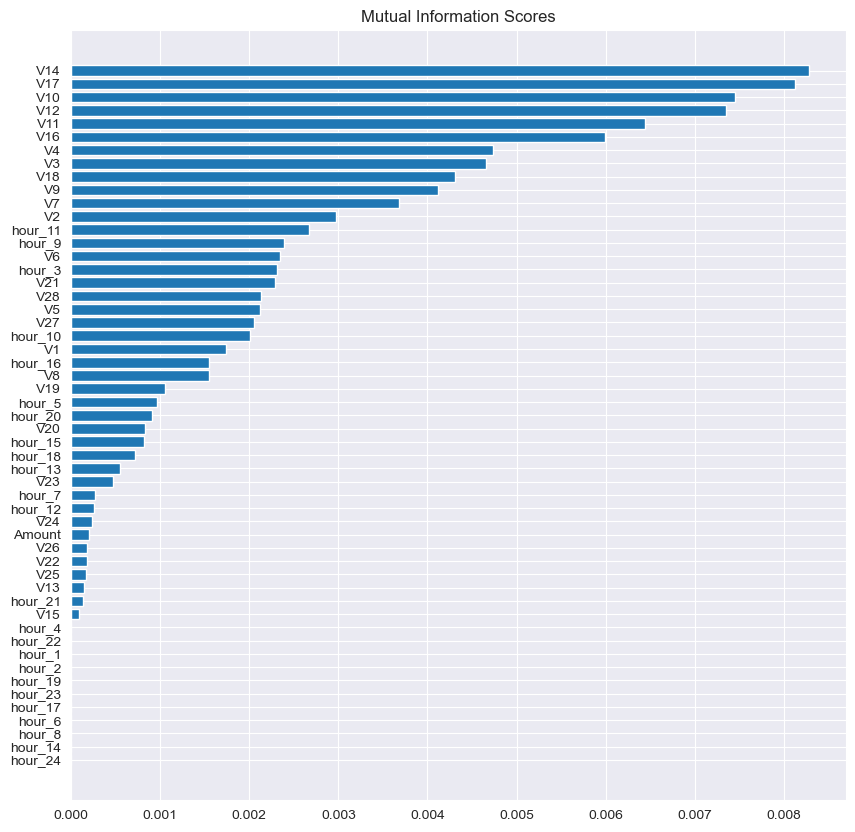

In [54]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores_hour_rob_log)

##### Features with 0 mutual information removed

In [56]:
features_with_zero_mutual_info = mi_scores_hour_rob_log[~(mi_scores_hour_rob_log>0)].index

In [57]:
X_train_pruned = X_train_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_val_pruned = X_val_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_train_pruned

V1        V2        V3        V4        V5        V6        V7  \
100143  0.545137 -1.382002  0.808039  0.325749 -1.216218  0.520418 -0.404707   
133205  1.274782  0.239294  0.126050  0.981467  0.308615  0.288049  0.070181   
150177 -2.442663 -3.250807 -1.081487  0.276296  0.401510 -0.383979  0.261438   
78925  -2.086922 -6.322946 -2.168681  0.926756 -2.522653 -0.144318  2.146822   
101526 -0.873372 -0.381341  3.111317 -1.452125 -1.447693  0.795084 -1.041973   
...          ...       ...       ...       ...       ...       ...       ...   
53696  -8.892289 -8.930986  0.520090  1.901172  1.892386 -1.638803  0.395668   
265101 -2.249534  2.863445 -2.585840 -1.118908 -0.261445 -1.934203  0.254788   
3525   -1.708940 -1.296255  1.953170 -2.277028 -0.510388  0.408807  0.329231   
60594   1.247036  0.348595  0.589407  0.982998 -0.222000 -0.452687 -0.012336   
67057   1.024661 -0.223567  0.521926  0.679175  0.146810  1.460143 -0.482834   

              V8        V9       V10  ...  hour_9  hour_10  hour_11  hour_12  \
100143  0.236356  0.843181 -0.479484  ...       0        0        0        0   
133205 -0.096043  0.315763 -0.220228  ...       0        0        0        0   
150177  0.486404  1.891807 -1.440296  ...       0        0        0        0   
78925  -0.703704 -0.883657 -0.207525  ...       0        0        0        0   
101526  0.765762  0.220466 -0.134101  ...       0        0        0        0   
...          ...       ...       ...  ...     ...      ...      ...      ...   
53696  -0.292704  1.077294  0.033479  ...       0        0        0        0   
265101  1.252018 -0.372203 -0.155683  ...       0        0        0        0   
3525    0.477331  1.058119 -2.015791  ...       0        0        0        0   
60594  -0.140168  0.052173 -0.069423  ...       0        0        0        0   
67057   0.503958  0.609685 -0.414094  ...       0        0        0        0   

        hour_13  hour_15  hour_16  hour_18  hour_20  hour_21  
100143        0        0        0        0        0        0  
133205        0        0        0        0        0        0  
150177        0        0        0        0        0        0  
78925         0        0        0        0        0        0  
101526        0        0        0        0        0        0  
...         ...      ...      ...      ...      ...      ...  
53696         1        0        0        0        0        0  
265101        0        0        0        0        0        1  
3525          0        0        0        0        0        0  
60594         0        0        0        0        0        0  
67057         0        1        0        0        0        0  

[170235 rows x 42 columns]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9333    0.7447    0.8284        94

    accuracy                         0.9995     56745
   macro avg     0.9665    0.8723    0.9141     56745
weighted avg     0.9995    0.9995    0.9995     56745




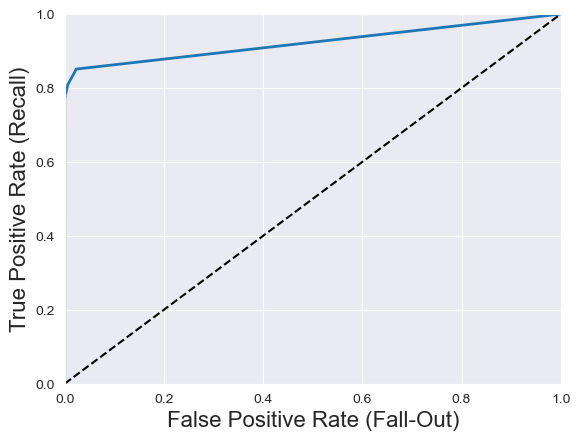

ROC AUC score: 0.9230539770006502

[[56646     5]
 [   24    70]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9778    0.9886     56651
           1     0.0590    0.8404    0.1103        94

    accuracy                         0.9775     56745
   macro avg     0.5294    0.9091    0.5495     56745
weighted avg     0.9982    0.9775    0.9872     56745




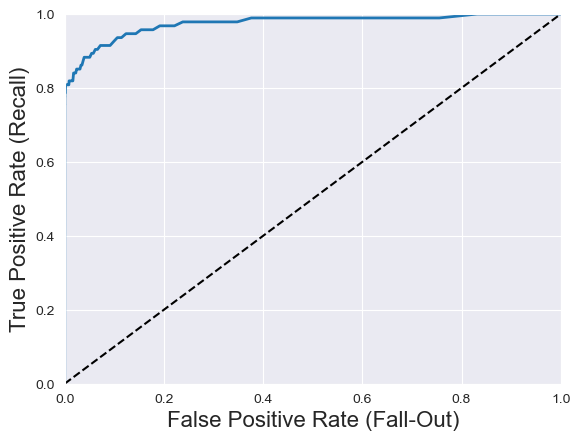

ROC AUC score: 0.9745147312942966

[[55392  1259]
 [   15    79]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.8667    0.5532    0.6753        94

    accuracy                         0.9991     56745
   macro avg     0.9330    0.7765    0.8374     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


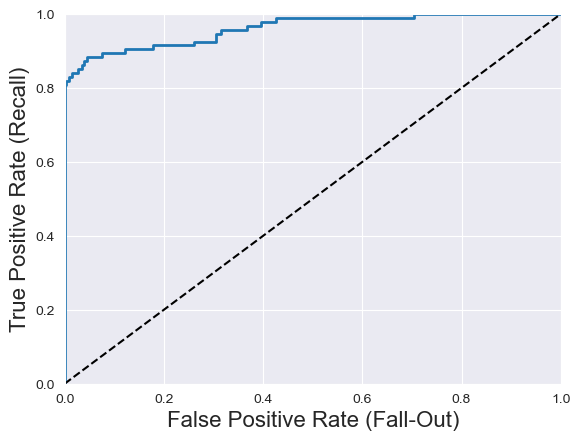

ROC AUC score: 0.9612733357695513

[[56643     8]
 [   42    52]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56651
           1     0.9500    0.6064    0.7403        94

    accuracy                         0.9993     56745
   macro avg     0.9747    0.8032    0.8700     56745
weighted avg     0.9993    0.9993    0.9992     56745




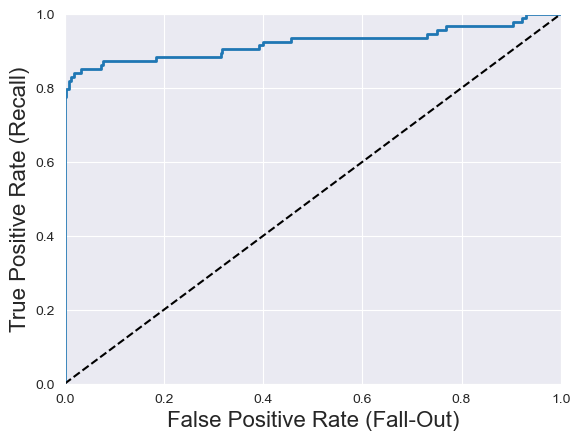

ROC AUC score: 0.9222077167517277

[[56648     3]
 [   37    57]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9296    0.7021    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9645    0.8510    0.8999     56745
weighted avg     0.9994    0.9994    0.9994     56745




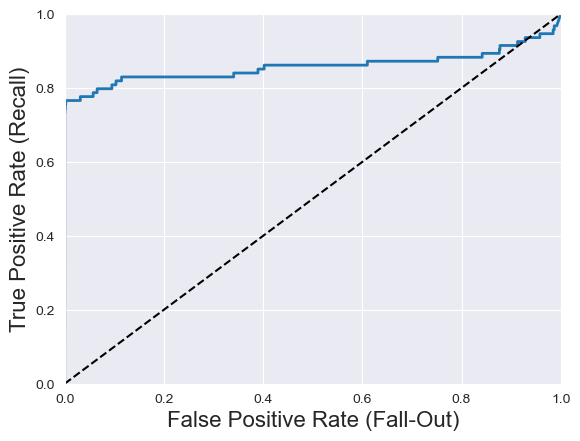

ROC AUC score: 0.8582926744077305

[[56646     5]
 [   28    66]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




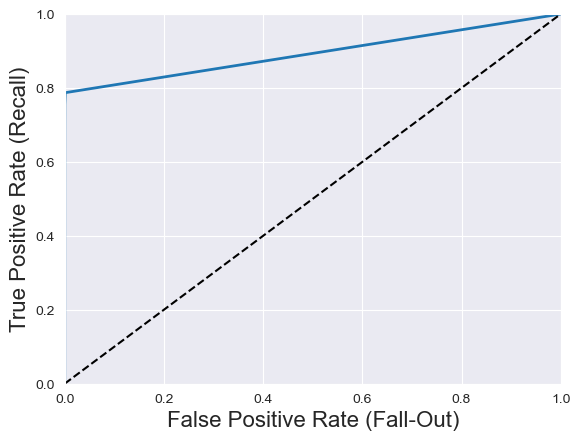

ROC AUC score: 0.8934599377975713

[[56645     6]
 [   28    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9616    0.9803     56651
           1     0.0329    0.7872    0.0632        94

    accuracy                         0.9613     56745
   macro avg     0.5163    0.8744    0.5217     56745
weighted avg     0.9980    0.9613    0.9787     56745




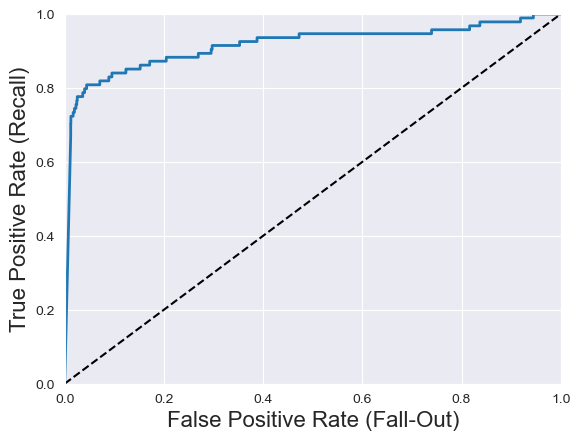

ROC AUC score: 0.9159003409077678

[[54476  2175]
 [   20    74]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8267    0.6596    0.7337        94

    accuracy                         0.9992     56745
   macro avg     0.9131    0.8297    0.8667     56745
weighted avg     0.9991    0.9992    0.9992     56745




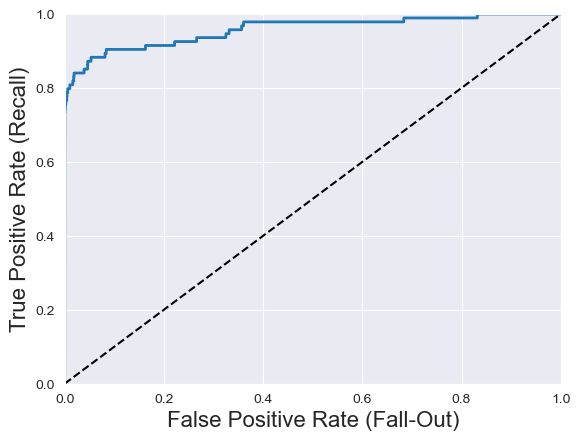

ROC AUC score: 0.9576944990173129

[[56638    13]
 [   32    62]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9655    0.9823     56651
           1     0.0360    0.7766    0.0688        94

    accuracy                         0.9652     56745
   macro avg     0.5178    0.8711    0.5256     56745
weighted avg     0.9980    0.9652    0.9808     56745




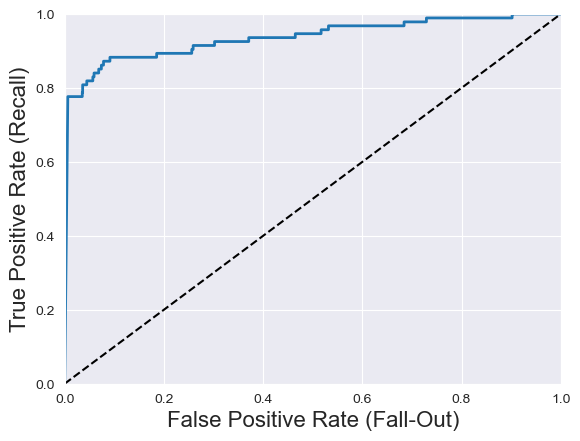

ROC AUC score: 0.9361073981530061

[[54697  1954]
 [   21    73]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8734    0.7340    0.7977        94

    accuracy                         0.9994     56745
   macro avg     0.9365    0.8669    0.8987     56745
weighted avg     0.9993    0.9994    0.9994     56745




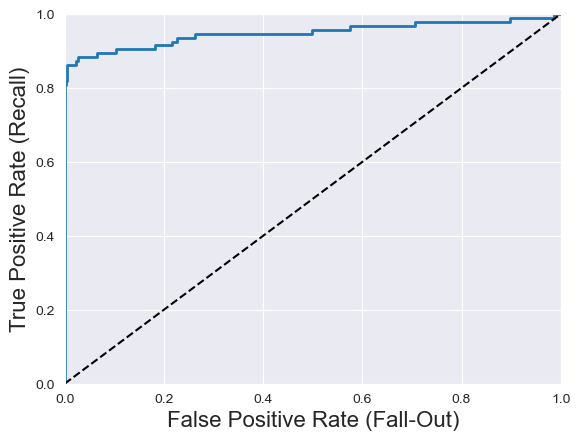

ROC AUC score: 0.948995097643391

[[56641    10]
 [   25    69]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9429    0.7021    0.8049        94

    accuracy                         0.9994     56745
   macro avg     0.9712    0.8510    0.9023     56745
weighted avg     0.9994    0.9994    0.9994     56745




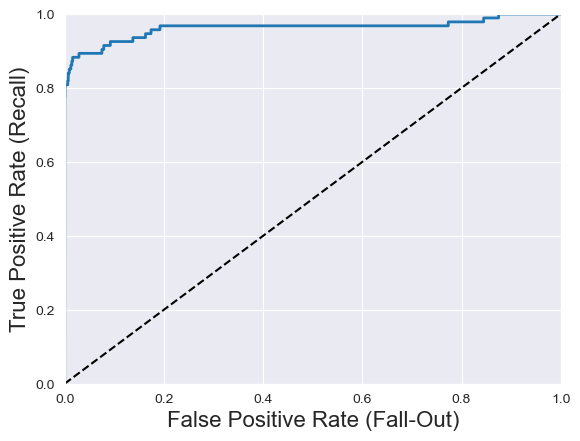

ROC AUC score: 0.9626704679679277

[[56647     4]
 [   28    66]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9178    0.7128    0.8024        94

    accuracy                         0.9994     56745
   macro avg     0.9587    0.8563    0.9011     56745
weighted avg     0.9994    0.9994    0.9994     56745




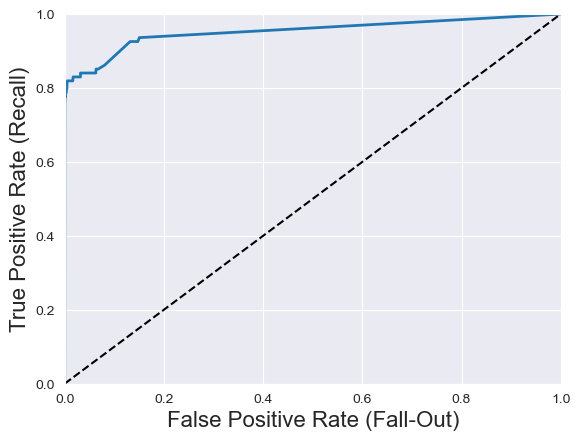

ROC AUC score: 0.9527514866125064

[[56645     6]
 [   27    67]]

Stored 'eval_dict_hours_log_pruned' (dict)


In [58]:
eval_dict_hours_log_pruned = model_tester(X_train=X_train_pruned, y_train=y_train,\
                                                       X_val=X_val_pruned, y_val=y_val)
%store eval_dict_hours_log_pruned

In [59]:
eval_df_hour_log_pruned = pd.DataFrame(data=eval_dict_hours_log_pruned.values(), index=eval_dict_hours_log_pruned.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [60]:
eval_df_hour_log_pruned

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.872296    0.933333  0.744681  0.828402                5   
brf_clf            0.909101    0.059043  0.840426  0.110335             1259   
lr_clf             0.776525    0.866667  0.553191  0.675325                8   
svc_rbf_clf        0.803165    0.950000  0.606383  0.740260                3   
svc_ploy_clf       0.851020    0.929577  0.702128  0.800000                5   
knn_clf            0.851011    0.916667  0.702128  0.795181                6   
gnb_clf            0.874421    0.032904  0.787234  0.063167             2175   
ada_clf            0.829672    0.826667  0.659574  0.733728               13   
qda_clf            0.871052    0.036014  0.776596  0.068835             1954   
mlp_clf            0.866933    0.873418  0.734043  0.797688               10   
xgb_clf            0.851029    0.942857  0.702128  0.804878                4   
xgbrf_clf          0.856330    0.917808  0.712766  0.802395                6   

              false_negatives  train_time  test_time  
rf_clf                     24  109.899122   0.387089  
brf_clf                    15    2.873723   0.283064  
lr_clf                     42    1.225279   0.009002  
svc_rbf_clf                37  843.441691  10.016361  
svc_ploy_clf               28  104.561649   0.690157  
knn_clf                    28    0.050012   6.377222  
gnb_clf                    20    0.122028   0.049011  
ada_clf                    32   42.929753   0.446101  
qda_clf                    21    0.260060   0.061013  
mlp_clf                    25   19.096933   0.036009  
xgb_clf                    28    7.461455   0.027006  
xgbrf_clf                  27    8.865017   0.028007

In [61]:
eval_df_hour_log_pruned - eval_df_hour_log

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.000000    0.000000  0.000000  0.000000                0   
brf_clf            0.000627    0.002975  0.000000  0.005212              -71   
lr_clf            -0.010621    0.022917 -0.021277 -0.008220               -2   
svc_rbf_clf        0.000000    0.000000  0.000000  0.000000                0   
svc_ploy_clf      -0.005310    0.011769 -0.010638 -0.002395               -1   
knn_clf            0.000000    0.000000  0.000000  0.000000                0   
gnb_clf            0.009732    0.006339  0.010638  0.011795             -500   
ada_clf            0.000000    0.000000  0.000000  0.000000                0   
qda_clf           -0.001965    0.005283 -0.010638  0.009683             -380   
mlp_clf           -0.005310    0.009220 -0.010638 -0.002312               -1   
xgb_clf           -0.000009   -0.013665  0.000000 -0.004938                1   
xgbrf_clf          0.005319    0.001142  0.010638  0.007214                0   

              false_negatives  train_time  test_time  
rf_clf                      0    8.832268   0.002001  
brf_clf                     0   -0.046942  -0.006002  
lr_clf                      2   -0.219050  -0.002001  
svc_rbf_clf                 0  -14.541850  -0.525038  
svc_ploy_clf                1  -10.302592  -0.162038  
knn_clf                     0   -0.004000  -0.596875  
gnb_clf                    -1   -0.027006  -0.008002  
ada_clf                     0   -1.250015  -0.080019  
qda_clf                     1   -0.055012  -0.021006  
mlp_clf                     1   -4.052673  -0.007001  
xgb_clf                     0   -1.110203  -0.017004  
xgbrf_clf                  -1   -0.282064  -0.006001

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Even if we remove the features with the lowest mutual information, the models do not perform better, and the training and prediction time does not decrease significantly.

### 6.8 Summary of exploring dataset preparation options

In [239]:
X_train = X_train_hour_amt_robust_log.copy()
X_val = X_val_hour_amt_robust_log.copy()

# 7. Model selection

As our goal is to find as many fraudulent transactions as possible, one of our main metric is the recall score, that is to maximize the number of fraudulent transactions found, and minimize the number of fraudulent transactions missed.

However, recall in itself is not the only important metric, as it is always possible to maximize recall, by predicting every transaction as fraudulent. By doing so, the number of false positive predictions will be extremely high. This will result in a low precision score, as most of our predictions will not correctly classify the transactions as fraudulent.

In summary, we aim to keep the false positive and the false negative predictions as low as possible, but we are mostly interested in identifying all the fraudulent transactions.

This results in that the simple f1_score is not the best metric for our use case, as it weights precision and recall evenly.\
Our preferrred metric is the fbeta_score, where we can assign a specific weight for the recall, and thus get a comparable score where recall is in the focus.

The model_tester2 function, does the same model testing as before, but it calculates the precision-; recall-; and auc score for the precision-recall curve.

### 7.1 Basic model validating

Here we are trying out the previous classifiers on the transformed dataset, but we focus primarily on recall, and then precision, and useing the fbeta_score to compare the model performances.

============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




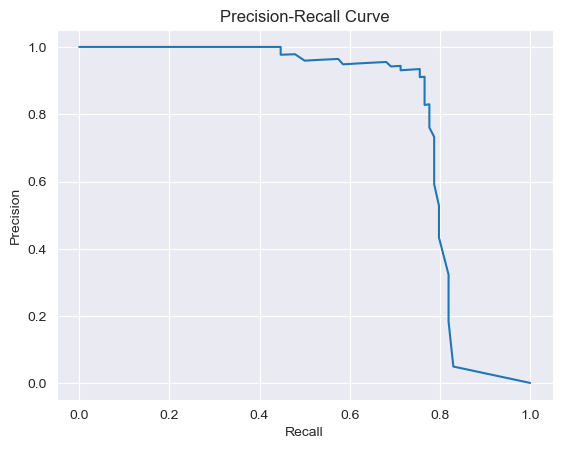

fbeta: 0.7297
AUC: 0.788
[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9998    0.9772    0.9883     56651
           1     0.0589    0.8617    0.1103        94

    accuracy                         0.9770     56745
   macro avg     0.5293    0.9194    0.5493     56745
weighted avg     0.9982    0.9770    0.9869     56745




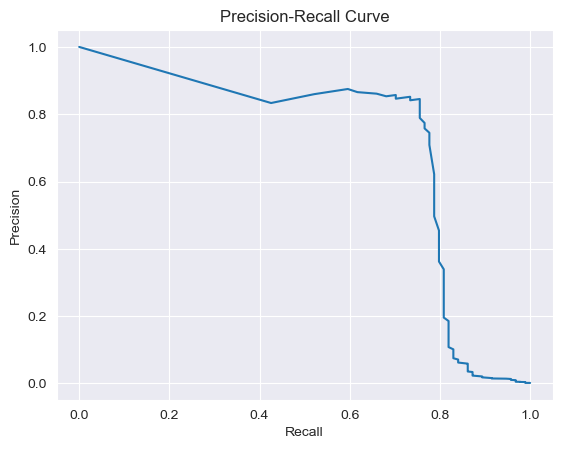

fbeta: 0.5654
AUC: 0.712
[[55357  1294]
 [   13    81]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     56651
           1     0.8438    0.5745    0.6835        94

    accuracy                         0.9991     56745
   macro avg     0.9215    0.7871    0.8416     56745
weighted avg     0.9990    0.9991    0.9990     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


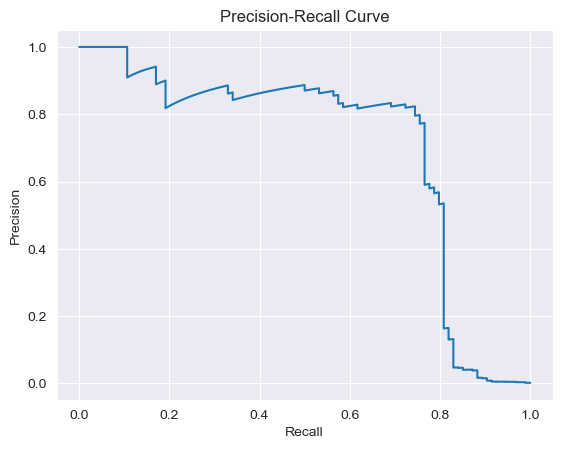

fbeta: 0.5816
AUC: 0.703
[[56641    10]
 [   40    54]]

============ knn_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




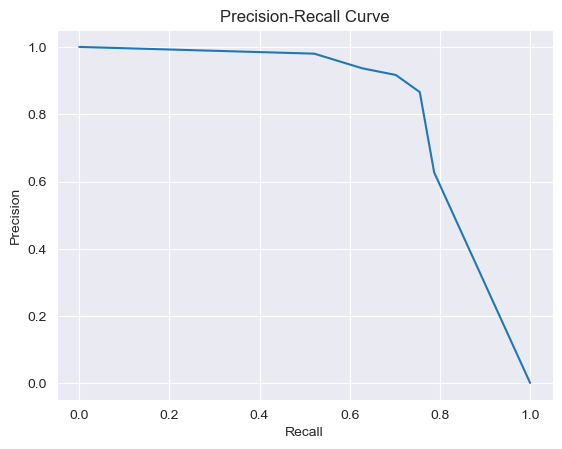

fbeta: 0.7085
AUC: 0.825
[[56645     6]
 [   28    66]]

============ gnb_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9528    0.9756     56651
           1     0.0266    0.7766    0.0514        94

    accuracy                         0.9525     56745
   macro avg     0.5131    0.8647    0.5135     56745
weighted avg     0.9980    0.9525    0.9741     56745




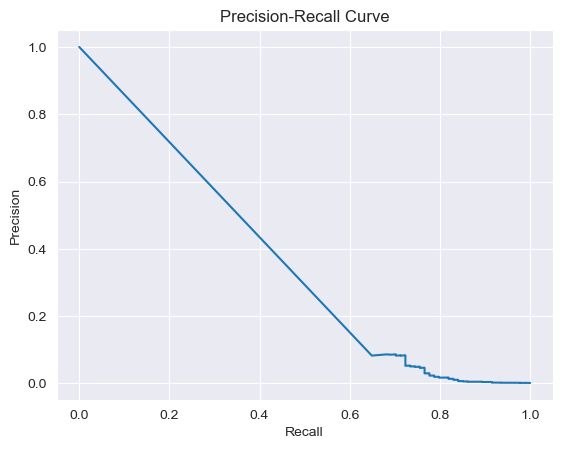

fbeta: 0.3723
AUC: 0.362
[[53976  2675]
 [   21    73]]

============ ada_clf ============
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56651
           1     0.8267    0.6596    0.7337        94

    accuracy                         0.9992     56745
   macro avg     0.9131    0.8297    0.8667     56745
weighted avg     0.9991    0.9992    0.9992     56745




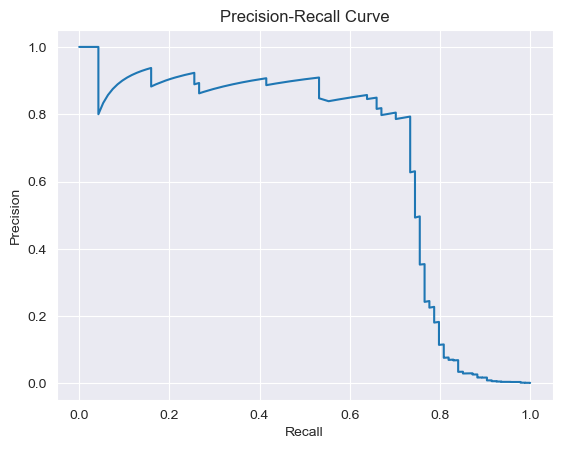

fbeta: 0.6647
AUC: 0.677
[[56638    13]
 [   32    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0     0.9996    0.9588    0.9788     56651
           1     0.0307    0.7872    0.0592        94

    accuracy                         0.9585     56745
   macro avg     0.5152    0.8730    0.5190     56745
weighted avg     0.9980    0.9585    0.9773     56745




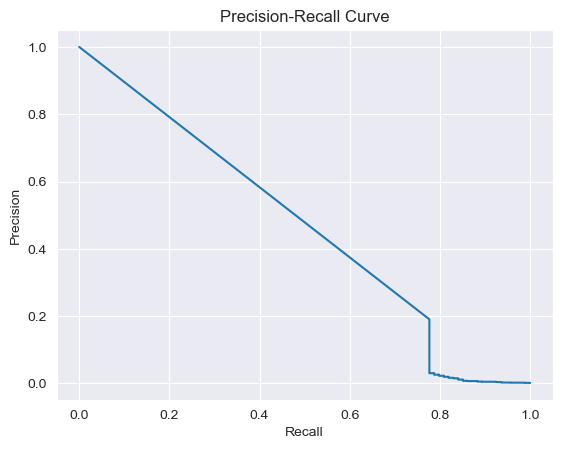

fbeta: 0.4044
AUC: 0.464
[[54317  2334]
 [   20    74]]

============ mlp_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9054    0.7128    0.7976        94

    accuracy                         0.9994     56745
   macro avg     0.9525    0.8563    0.8987     56745
weighted avg     0.9994    0.9994    0.9994     56745




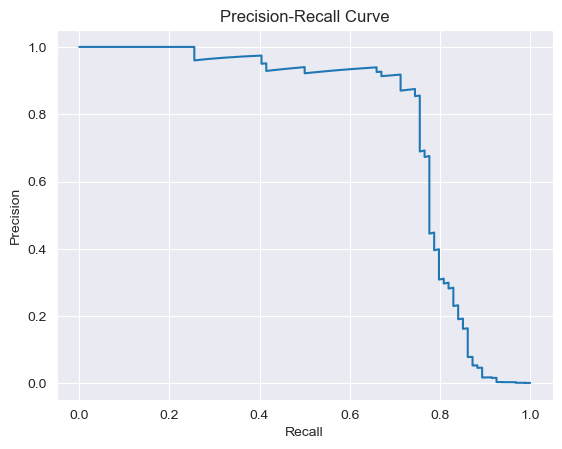

fbeta: 0.7186
AUC: 0.765
[[56644     7]
 [   27    67]]

============ xgb_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9565    0.7021    0.8098        94

    accuracy                         0.9995     56745
   macro avg     0.9780    0.8510    0.9048     56745
weighted avg     0.9994    0.9995    0.9994     56745




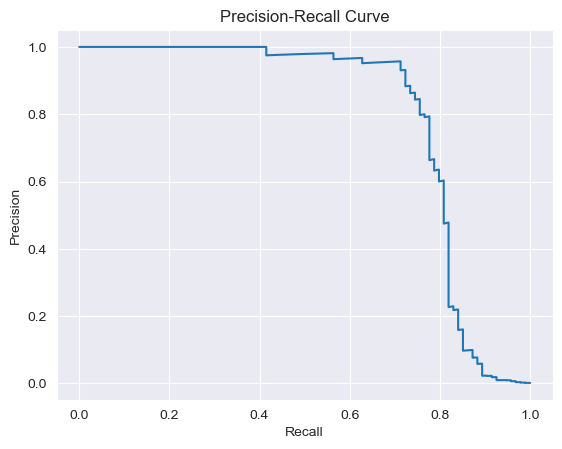

fbeta: 0.7094
AUC: 0.794
[[56648     3]
 [   28    66]]

============ xgbrf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9167    0.7021    0.7952        94

    accuracy                         0.9994     56745
   macro avg     0.9581    0.8510    0.8974     56745
weighted avg     0.9994    0.9994    0.9994     56745




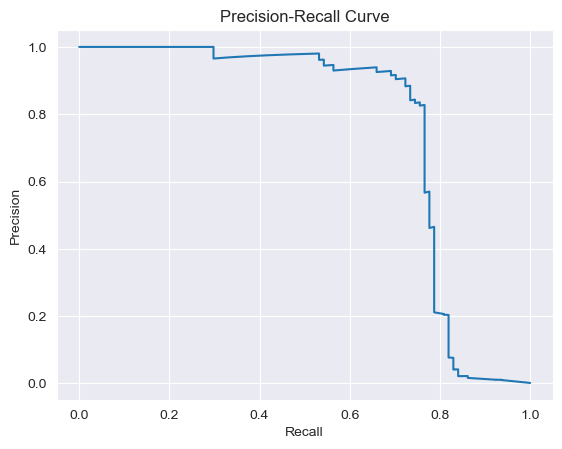

fbeta: 0.7085
AUC: 0.761
[[56645     6]
 [   28    66]]

Stored 'eval_dict_new' (dict)


In [63]:
eval_dict_new = model_tester2(X_train=X_train, y_train=y_train,\
                              X_val=X_val, y_val=y_val)
%store eval_dict_new

In [65]:
recall_precision_for_vanilla_models = {}

for key, values in eval_dict_new.items():
    recall_precision_for_vanilla_models[key] = values[9:]

In [66]:
selected_vanilla_dict = {}

for key, values in eval_dict_new.items():
    selected_vanilla_dict[key] = values[:9]

eval_df_new = pd.DataFrame(data=selected_vanilla_dict.values(), index=selected_vanilla_dict.keys(), \
                          columns=['fbeta', 'bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

eval_df_new

fbeta  bal_acc_score  precisions   recalls        f1  \
rf_clf     0.729674       0.861658    0.931507  0.723404  0.787513   
brf_clf    0.565369       0.919430    0.058909  0.861702  0.711872   
lr_clf     0.581607       0.787146    0.843750  0.574468  0.702885   
knn_clf    0.708505       0.851011    0.916667  0.702128  0.825129   
gnb_clf    0.372303       0.864688    0.026565  0.776596  0.361788   
ada_clf    0.664742       0.829672    0.826667  0.659574  0.676609   
qda_clf    0.404372       0.873017    0.030731  0.787234  0.464493   
mlp_clf    0.718647       0.856321    0.905405  0.712766  0.765450   
xgb_clf    0.709384       0.851037    0.956522  0.702128  0.794348   
xgbrf_clf  0.708505       0.851011    0.916667  0.702128  0.761083   

           false_positives  false_negatives  train_time  test_time  
rf_clf                   5               26  105.234922   0.393090  
brf_clf               1294               13    2.920282   0.290066  
lr_clf                  10               40    1.430329   0.011003  
knn_clf                  6               28    0.055012   7.017597  
gnb_clf               2675               21    0.135031   0.051012  
ada_clf                 13               32   43.737645   0.540123  
qda_clf               2334               20    0.288065   0.079018  
mlp_clf                  7               27   15.140447   0.045011  
xgb_clf                  3               28    7.875398   0.029006  
xgbrf_clf                6               28    8.870609   0.032007

In [201]:
eval_df_new.sort_values('fbeta')

fbeta  bal_acc_score  precisions   recalls        f1  \
gnb_clf    0.372303       0.864688    0.026565  0.776596  0.361788   
qda_clf    0.404372       0.873017    0.030731  0.787234  0.464493   
brf_clf    0.565369       0.919430    0.058909  0.861702  0.711872   
lr_clf     0.581607       0.787146    0.843750  0.574468  0.702885   
ada_clf    0.664742       0.829672    0.826667  0.659574  0.676609   
knn_clf    0.708505       0.851011    0.916667  0.702128  0.825129   
xgbrf_clf  0.708505       0.851011    0.916667  0.702128  0.761083   
xgb_clf    0.709384       0.851037    0.956522  0.702128  0.794348   
mlp_clf    0.718647       0.856321    0.905405  0.712766  0.765450   
rf_clf     0.729674       0.861658    0.931507  0.723404  0.787513   

           false_positives  false_negatives  train_time  test_time  
gnb_clf               2675               21    0.135031   0.051012  
qda_clf               2334               20    0.288065   0.079018  
brf_clf               1294               13    2.920282   0.290066  
lr_clf                  10               40    1.430329   0.011003  
ada_clf                 13               32   43.737645   0.540123  
knn_clf                  6               28    0.055012   7.017597  
xgbrf_clf                6               28    8.870609   0.032007  
xgb_clf                  3               28    7.875398   0.029006  
mlp_clf                  7               27   15.140447   0.045011  
rf_clf                   5               26  105.234922   0.393090

### 7.2 Models with class_weight hyperparameter

There are several classification models in scikit-learn with a class_weight hyperparameter, which penalizes the model by a weight multiplier, if it makes a mistake on a spcific class prediction. A higher class_weight for Class 1 (fraudulent transaction) would result in a higher penalty for the model, when it misclassifies a fraudulent transaction.

We created yet another function to test the following models with different class_weights:
- RandomForestClassifier
- BalancedRandomForestClassifier
- LogisticRegression

============ {0: 10, 1: 1} ============
============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




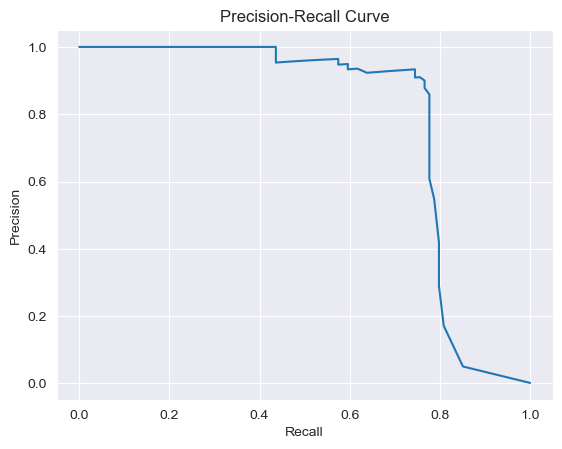

fbeta: 0.7297
AUC: 0.778
[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9997    0.9625    0.9808     56651
           1     0.0359    0.8404    0.0688        94

    accuracy                         0.9623     56745
   macro avg     0.5178    0.9015    0.5248     56745
weighted avg     0.9981    0.9623    0.9793     56745




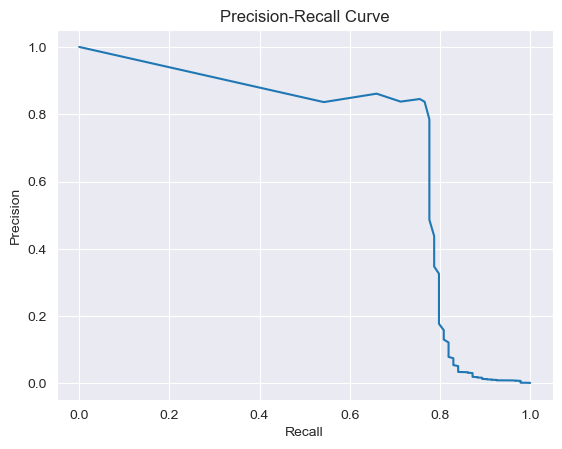

fbeta: 0.4511
AUC: 0.711
[[54527  2124]
 [   15    79]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9989    1.0000    0.9995     56651
           1     0.9444    0.3617    0.5231        94

    accuracy                         0.9989     56745
   macro avg     0.9717    0.6808    0.7613     56745
weighted avg     0.9989    0.9989    0.9987     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


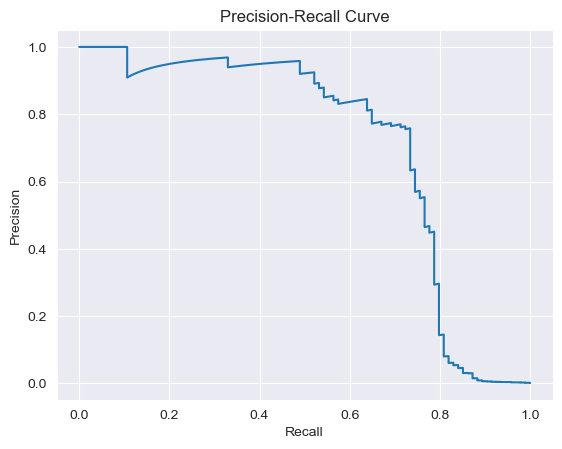

fbeta: 0.3705
AUC: 0.710
[[56649     2]
 [   60    34]]

============ {0: 1, 1: 10} ============
============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9306    0.7128    0.8072        94

    accuracy                         0.9994     56745
   macro avg     0.9650    0.8563    0.9035     56745
weighted avg     0.9994    0.9994    0.9994     56745




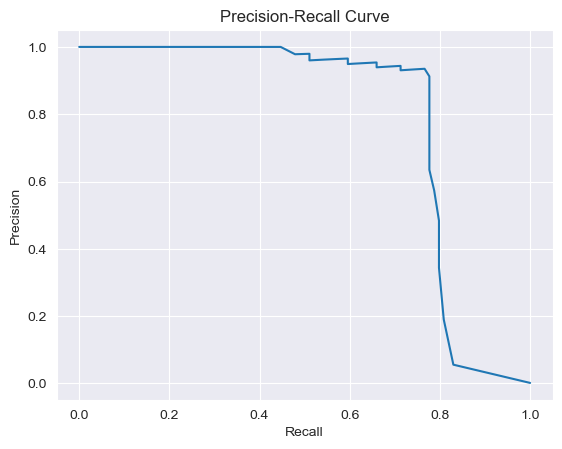

fbeta: 0.7192
AUC: 0.784
[[56646     5]
 [   27    67]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9997    0.9830    0.9913     56651
           1     0.0739    0.8191    0.1356        94

    accuracy                         0.9827     56745
   macro avg     0.5368    0.9011    0.5634     56745
weighted avg     0.9982    0.9827    0.9898     56745




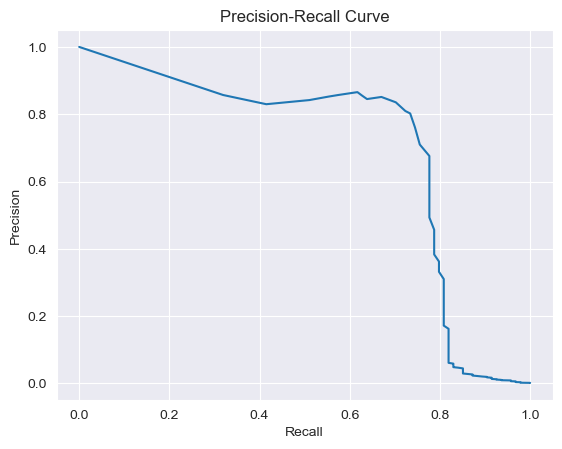

fbeta: 0.5902
AUC: 0.695
[[55686   965]
 [   17    77]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     56651
           1     0.7579    0.7660    0.7619        94

    accuracy                         0.9992     56745
   macro avg     0.8788    0.8828    0.8808     56745
weighted avg     0.9992    0.9992    0.9992     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


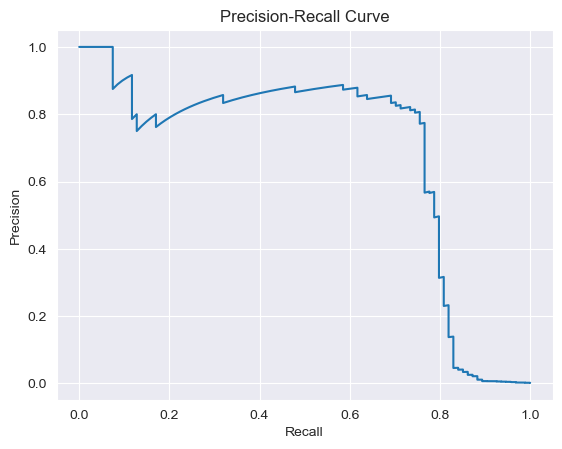

fbeta: 0.7656
AUC: 0.686
[[56628    23]
 [   22    72]]

============ {0: 0.9, 1: 0.1} ============
============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




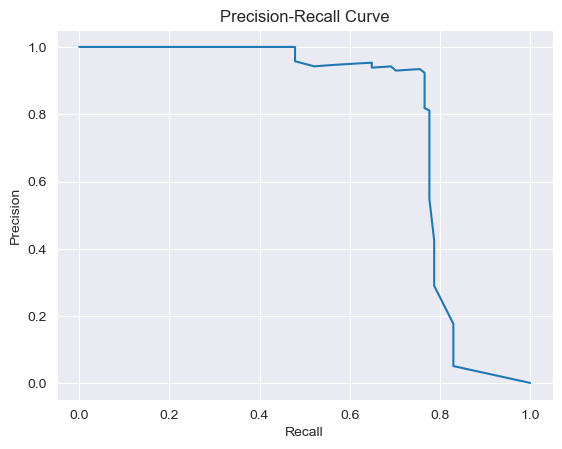

fbeta: 0.7297
AUC: 0.778
[[56646     5]
 [   26    68]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9998    0.9613    0.9802     56651
           1     0.0357    0.8617    0.0685        94

    accuracy                         0.9612     56745
   macro avg     0.5177    0.9115    0.5243     56745
weighted avg     0.9982    0.9612    0.9787     56745




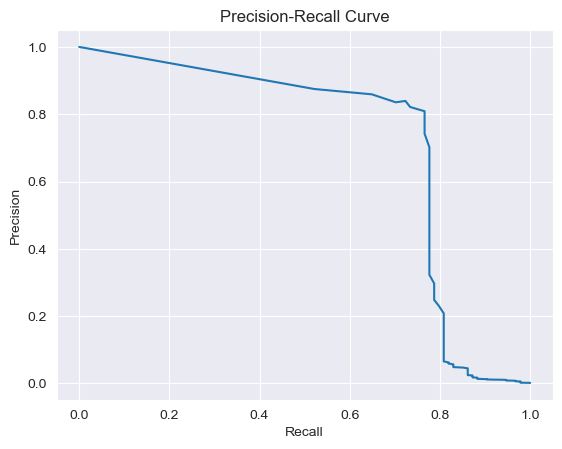

fbeta: 0.4556
AUC: 0.717
[[54460  2191]
 [   13    81]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9988    1.0000    0.9994     56651
           1     0.9600    0.2553    0.4034        94

    accuracy                         0.9987     56745
   macro avg     0.9794    0.6277    0.7014     56745
weighted avg     0.9987    0.9987    0.9984     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


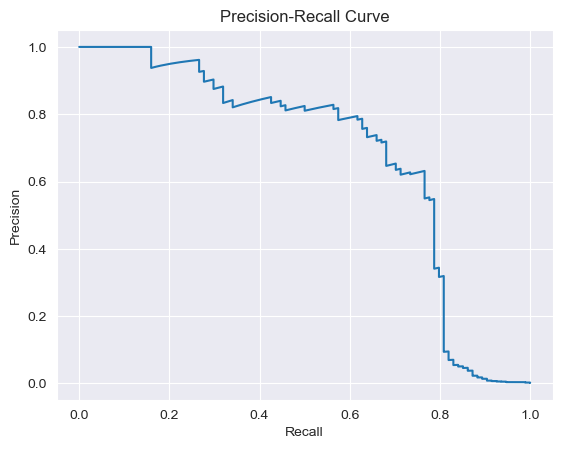

fbeta: 0.2627
AUC: 0.678
[[56650     1]
 [   70    24]]

============ {0: 0.1, 1: 0.9} ============
============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9429    0.7021    0.8049        94

    accuracy                         0.9994     56745
   macro avg     0.9712    0.8510    0.9023     56745
weighted avg     0.9994    0.9994    0.9994     56745




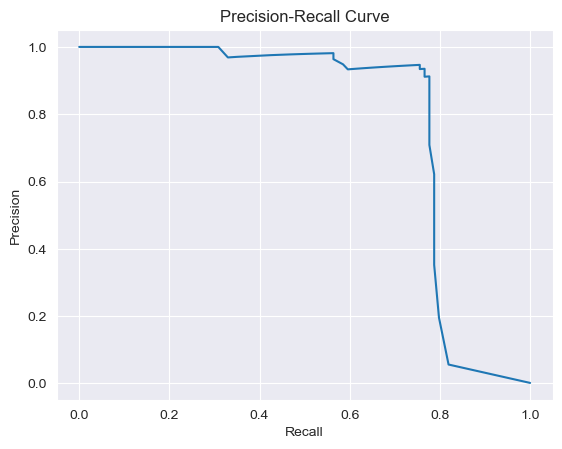

fbeta: 0.7091
AUC: 0.776
[[56647     4]
 [   28    66]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9997    0.9846    0.9921     56651
           1     0.0811    0.8191    0.1475        94

    accuracy                         0.9843     56745
   macro avg     0.5404    0.9019    0.5698     56745
weighted avg     0.9982    0.9843    0.9907     56745




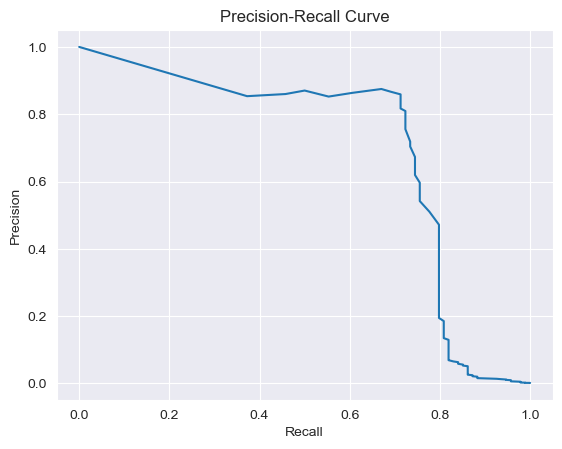

fbeta: 0.6067
AUC: 0.698
[[55778   873]
 [   17    77]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     56651
           1     0.7849    0.7766    0.7807        94

    accuracy                         0.9993     56745
   macro avg     0.8923    0.8881    0.8902     56745
weighted avg     0.9993    0.9993    0.9993     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


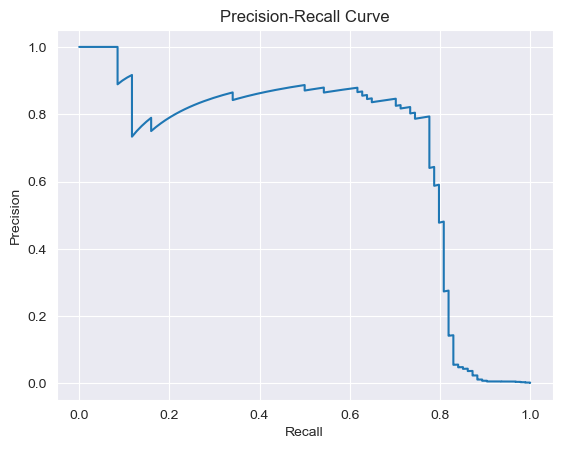

fbeta: 0.7769
AUC: 0.693
[[56631    20]
 [   21    73]]

Stored 'result_weights' (dict)


In [67]:
result_weights = model_tester3(X_train, y_train, X_val, y_val)
%store result_weights

In [68]:
recall_precision_for_class_weight_models = {}

for key, values in result_weights.items():
    recall_precision_for_class_weight_models[key] = values[9:]

In [69]:
selected_dict = {}

for key, values in result_weights.items():
    selected_dict[key] = values[:9]
    
result_weights_df = pd.DataFrame(data=selected_dict.values(), index=selected_dict.keys(), \
                          columns=['fbeta', 'bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

result_weights_df.sort_values('fbeta')

fbeta  bal_acc_score  precisions   recalls  \
lr_clf 0: 0.9/ 1: 0.1   0.262737       0.627651    0.960000  0.255319   
lr_clf 0: 10/ 1: 1      0.370495       0.680833    0.944444  0.361702   
brf_clf 0: 10/ 1: 1     0.451131       0.901466    0.035860  0.840426   
brf_clf 0: 0.9/ 1: 0.1  0.455647       0.911513    0.035651  0.861702   
brf_clf 0: 1/ 1: 10     0.590212       0.901057    0.073896  0.819149   
brf_clf 0: 0.1/ 1: 0.9  0.606667       0.901869    0.081053  0.819149   
rf_clf 0: 0.1/ 1: 0.9   0.709091       0.851029    0.942857  0.702128   
rf_clf 0: 1/ 1: 10      0.719240       0.856339    0.930556  0.712766   
rf_clf 0: 10/ 1: 1      0.729674       0.861658    0.931507  0.723404   
rf_clf 0: 0.9/ 1: 0.1   0.729674       0.861658    0.931507  0.723404   
lr_clf 0: 1/ 1: 10      0.765644       0.882776    0.757895  0.765957   
lr_clf 0: 0.1/ 1: 0.9   0.776914       0.888121    0.784946  0.776596   

                              f1  false_positives  false_negatives  \
lr_clf 0: 0.9/ 1: 0.1   0.678283                1               70   
lr_clf 0: 10/ 1: 1      0.709973                2               60   
brf_clf 0: 10/ 1: 1     0.711303             2124               15   
brf_clf 0: 0.9/ 1: 0.1  0.717300             2191               13   
brf_clf 0: 1/ 1: 10     0.695119              965               17   
brf_clf 0: 0.1/ 1: 0.9  0.698277              873               17   
rf_clf 0: 0.1/ 1: 0.9   0.775903                4               28   
rf_clf 0: 1/ 1: 10      0.784241                5               27   
rf_clf 0: 10/ 1: 1      0.778338                5               26   
rf_clf 0: 0.9/ 1: 0.1   0.777933                5               26   
lr_clf 0: 1/ 1: 10      0.685564               23               22   
lr_clf 0: 0.1/ 1: 0.9   0.692664               20               21   

                        train_time  test_time  
lr_clf 0: 0.9/ 1: 0.1     1.482337   0.012002  
lr_clf 0: 10/ 1: 1        1.433326   0.012003  
brf_clf 0: 10/ 1: 1       2.916664   0.350079  
brf_clf 0: 0.9/ 1: 0.1    2.962673   0.349079  
brf_clf 0: 1/ 1: 10       2.983683   0.282062  
brf_clf 0: 0.1/ 1: 0.9    2.926666   0.305070  
rf_clf 0: 0.1/ 1: 0.9    98.173628   0.393090  
rf_clf 0: 1/ 1: 10       90.750024   0.368085  
rf_clf 0: 10/ 1: 1      116.040344   0.412116  
rf_clf 0: 0.9/ 1: 0.1   121.534414   0.443102  
lr_clf 0: 1/ 1: 10        1.489339   0.013003  
lr_clf 0: 0.1/ 1: 0.9     1.487120   0.012003

### 7.3 Basic model validating with balanced datasets

Another commonly used method for dealing with unbalanced datasets is to balance out the datasets by either under-; or oversampling.

Undersampling means to reduce the number of the majority class to the number of minority class observations.

Oversampling means to increase the number of minority class observations by either duplicating the minority observations (RandomOverSampler strategy) or by generating new observations based on the existing minority observations (SMOTEC/SMOTECNC stretegy)

For our project, we choose the oversampling method, as we felt that in case of undersampling, we would have a very small training dataset to work with: y_train only has 284 fraudulent transactions, so out training dataset would only have 568 observations.

#### 7.3.1 RandomOverSampler strategy

In [70]:
# RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

# Now we can fit the sampler
X_ros_train, y_ros_train = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_ros_train).items()))

[(0, 169951), (1, 169951)]


============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9324    0.7340    0.8214        94

    accuracy                         0.9995     56745
   macro avg     0.9660    0.8670    0.9106     56745
weighted avg     0.9994    0.9995    0.9994     56745




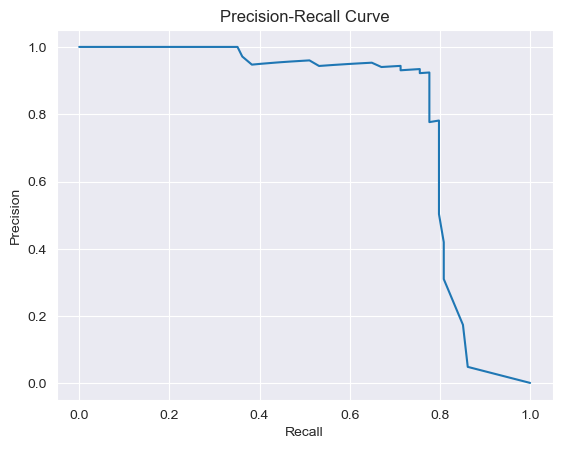

fbeta: 0.7401
AUC: 0.791
[[56646     5]
 [   25    69]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9315    0.7234    0.8144        94

    accuracy                         0.9995     56745
   macro avg     0.9655    0.8617    0.9070     56745
weighted avg     0.9994    0.9995    0.9994     56745




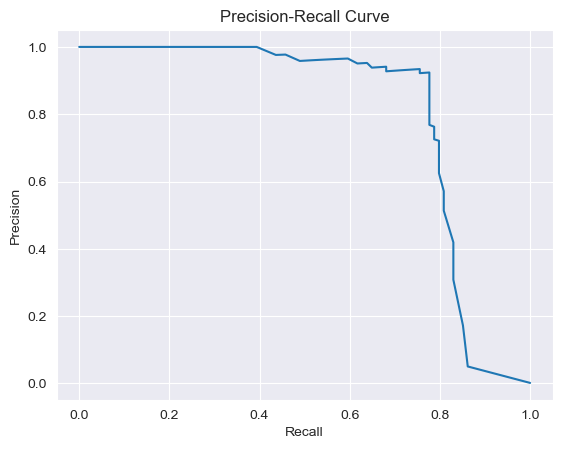

fbeta: 0.7297
AUC: 0.801
[[56646     5]
 [   26    68]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9723    0.9858     56651
           1     0.0480    0.8404    0.0908        94

    accuracy                         0.9721     56745
   macro avg     0.5238    0.9064    0.5383     56745
weighted avg     0.9982    0.9721    0.9844     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


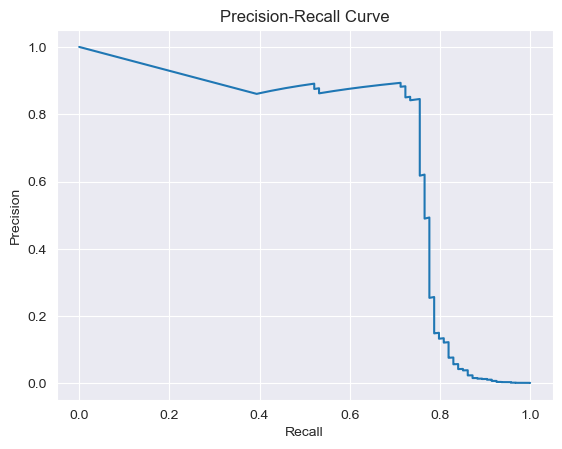

fbeta: 0.5139
AUC: 0.705
[[55083  1568]
 [   15    79]]

============ knn_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9995    0.9996     56651
           1     0.7327    0.7872    0.7590        94

    accuracy                         0.9992     56745
   macro avg     0.8662    0.8934    0.8793     56745
weighted avg     0.9992    0.9992    0.9992     56745




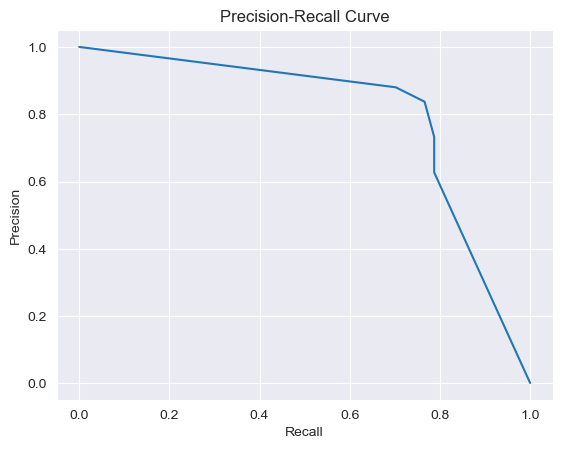

fbeta: 0.7850
AUC: 0.798
[[56624    27]
 [   20    74]]

============ gnb_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9413    0.9696     56651
           1     0.0218    0.7872    0.0424        94

    accuracy                         0.9411     56745
   macro avg     0.5107    0.8643    0.5060     56745
weighted avg     0.9980    0.9411    0.9681     56745




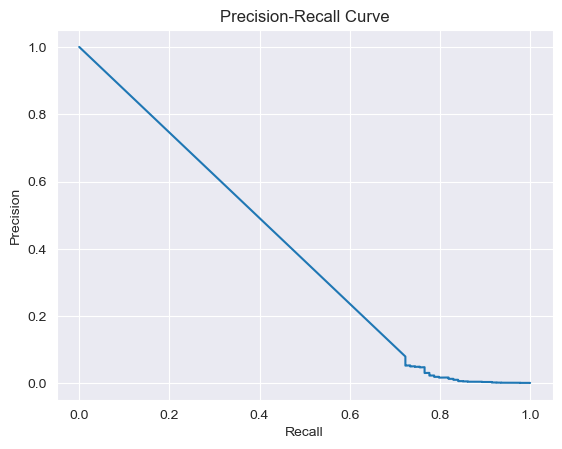

fbeta: 0.3348
AUC: 0.395
[[53328  3323]
 [   20    74]]

============ ada_clf ============
              precision    recall  f1-score   support

           0     0.9998    0.9889    0.9943     56651
           1     0.1132    0.8511    0.1998        94

    accuracy                         0.9887     56745
   macro avg     0.5565    0.9200    0.5970     56745
weighted avg     0.9983    0.9887    0.9930     56745




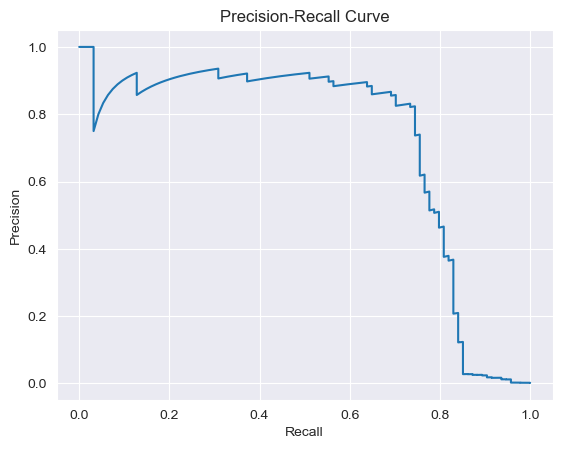

fbeta: 0.6804
AUC: 0.718
[[56024   627]
 [   14    80]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0     0.9996    0.9582    0.9785     56651
           1     0.0303    0.7872    0.0584        94

    accuracy                         0.9579     56745
   macro avg     0.5150    0.8727    0.5184     56745
weighted avg     0.9980    0.9579    0.9770     56745




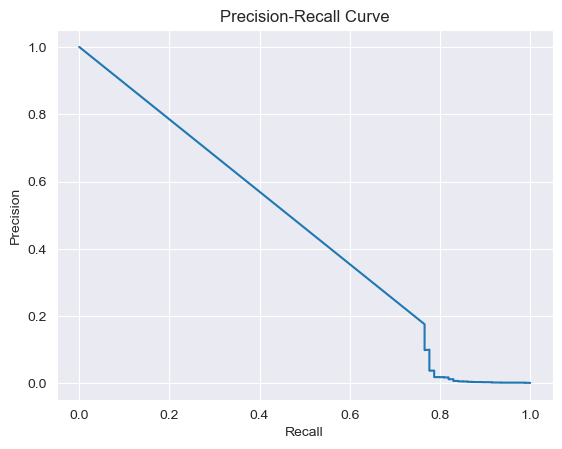

fbeta: 0.4016
AUC: 0.453
[[54284  2367]
 [   20    74]]

============ mlp_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8372    0.7660    0.8000        94

    accuracy                         0.9994     56745
   macro avg     0.9184    0.8829    0.8998     56745
weighted avg     0.9993    0.9994    0.9994     56745




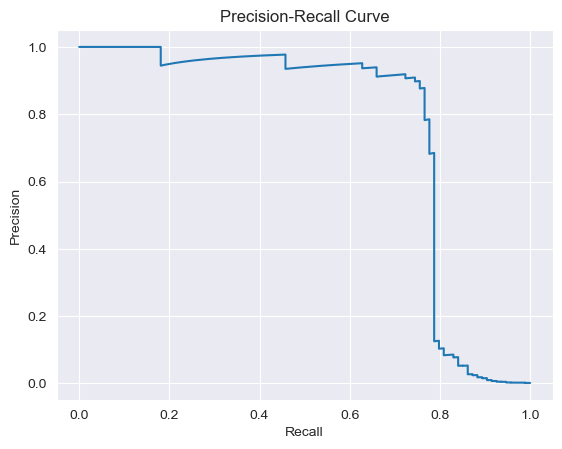

fbeta: 0.7685
AUC: 0.758
[[56637    14]
 [   22    72]]

============ xgb_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9333    0.7447    0.8284        94

    accuracy                         0.9995     56745
   macro avg     0.9665    0.8723    0.9141     56745
weighted avg     0.9995    0.9995    0.9995     56745




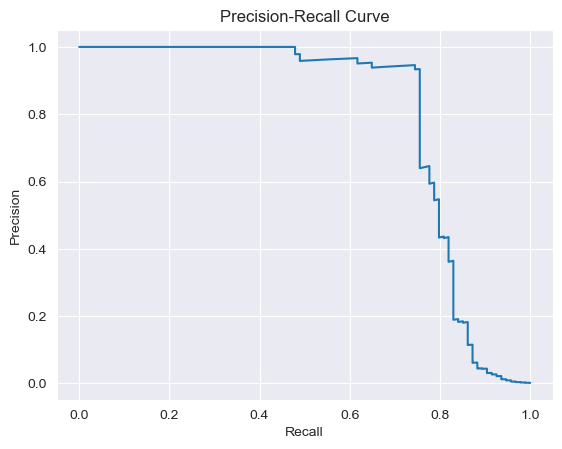

fbeta: 0.7505
AUC: 0.791
[[56646     5]
 [   24    70]]

============ xgbrf_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9946    0.9971     56651
           1     0.1995    0.8085    0.3200        94

    accuracy                         0.9943     56745
   macro avg     0.5996    0.9016    0.6586     56745
weighted avg     0.9984    0.9943    0.9960     56745




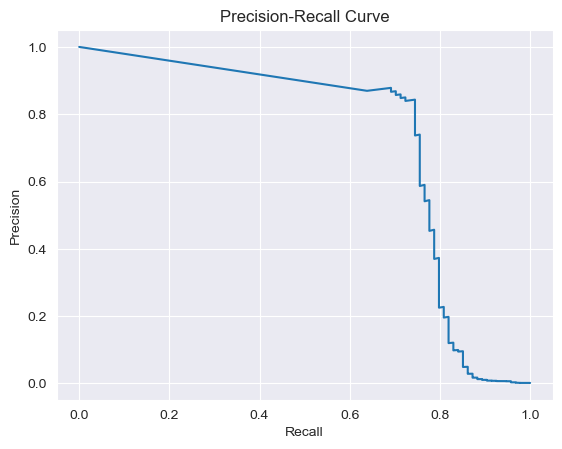

fbeta: 0.7235
AUC: 0.727
[[56346   305]
 [   18    76]]

Stored 'results_ros' (dict)


In [71]:
results_ros = model_tester2(X_ros_train, y_ros_train, X_val, y_val)
%store results_ros

In [72]:
selected_dict = {}

for key, values in results_ros.items():
    selected_dict[key] = values[:9]

results_ros_df = pd.DataFrame(data=selected_dict.values(), index=selected_dict.keys(), \
                          columns=['fbeta', 'bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

results_ros_df

fbeta  bal_acc_score  precisions   recalls        f1  \
rf_clf     0.740099       0.866977    0.932432  0.734043  0.791081   
brf_clf    0.729674       0.861658    0.931507  0.723404  0.801381   
lr_clf     0.513885       0.906374    0.047966  0.840426  0.705072   
knn_clf    0.784986       0.893379    0.732673  0.787234  0.798396   
gnb_clf    0.334783       0.864288    0.021784  0.787234  0.394842   
ada_clf    0.680406       0.919998    0.113154  0.851064  0.718364   
qda_clf    0.401586       0.872726    0.030315  0.787234  0.453241   
mlp_clf    0.768473       0.882855    0.837209  0.765957  0.758352   
xgb_clf    0.750515       0.872296    0.933333  0.744681  0.791480   
xgbrf_clf  0.723544       0.901563    0.199475  0.808511  0.726752   

           false_positives  false_negatives  train_time  test_time  
rf_clf                   5               25   86.192606   0.321073  
brf_clf                  5               26  135.998011   0.443101  
lr_clf                1568               15    4.005912   0.012003  
knn_clf                 27               20    0.108025  15.544538  
gnb_clf               3323               20    0.309069   0.056015  
ada_clf                627               14   60.437392   0.517118  
qda_clf               2367               20    0.605137   0.075017  
mlp_clf                 14               22   22.402688   0.045010  
xgb_clf                  5               24   13.315141   0.032007  
xgbrf_clf              305               18   12.832921   0.033008

#### 7.3.2 SMOTECNC strategy

In [73]:
hour_indexes = [i for i, x in enumerate(X_train.columns) if x.startswith('hour')]

# SMOTENC
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(random_state=0, categorical_features=hour_indexes)

# Now we can fit the sampler
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

print(sorted(Counter(y_smote_train).items()))

[(0, 169951), (1, 169951)]


============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9231    0.7660    0.8372        94

    accuracy                         0.9995     56745
   macro avg     0.9613    0.8829    0.9185     56745
weighted avg     0.9995    0.9995    0.9995     56745




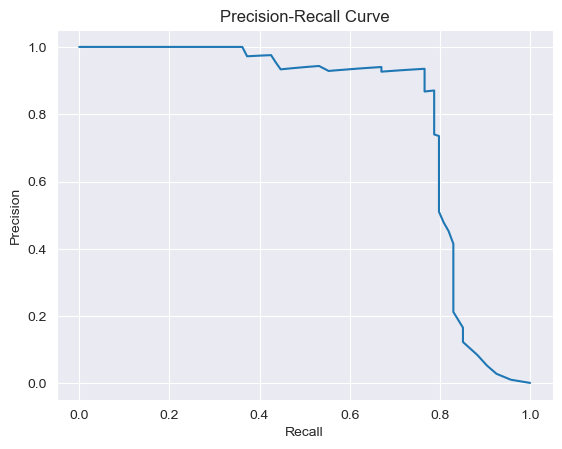

fbeta: 0.7710
AUC: 0.794
[[56645     6]
 [   22    72]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9342    0.7553    0.8353        94

    accuracy                         0.9995     56745
   macro avg     0.9669    0.8776    0.9175     56745
weighted avg     0.9995    0.9995    0.9995     56745




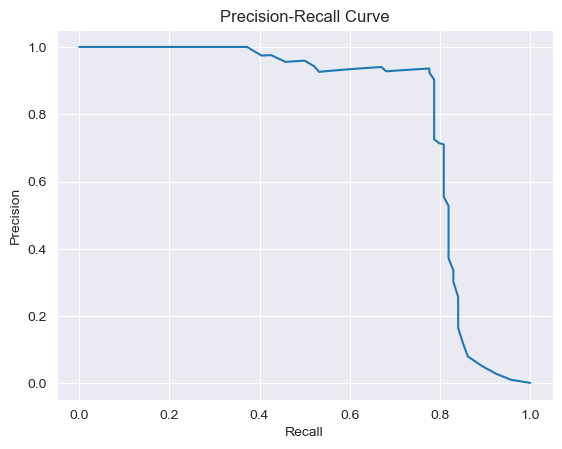

fbeta: 0.7609
AUC: 0.799
[[56646     5]
 [   23    71]]

============ lr_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9988    0.9992     56651
           1     0.5182    0.7553    0.6147        94

    accuracy                         0.9984     56745
   macro avg     0.7589    0.8771    0.8070     56745
weighted avg     0.9988    0.9984    0.9986     56745




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


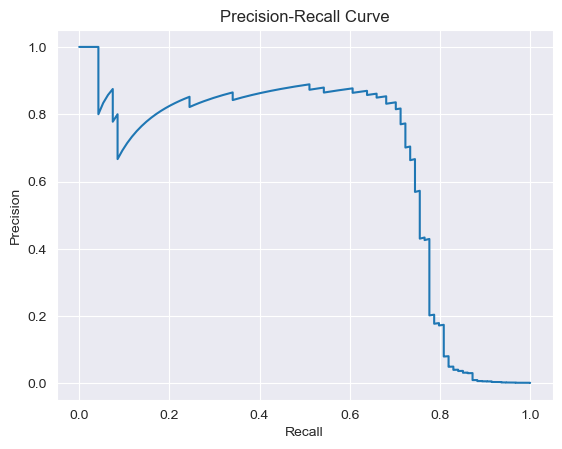

fbeta: 0.7423
AUC: 0.653
[[56585    66]
 [   23    71]]

============ knn_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9971    0.9984     56651
           1     0.3222    0.8191    0.4625        94

    accuracy                         0.9968     56745
   macro avg     0.6609    0.9081    0.7304     56745
weighted avg     0.9986    0.9968    0.9975     56745




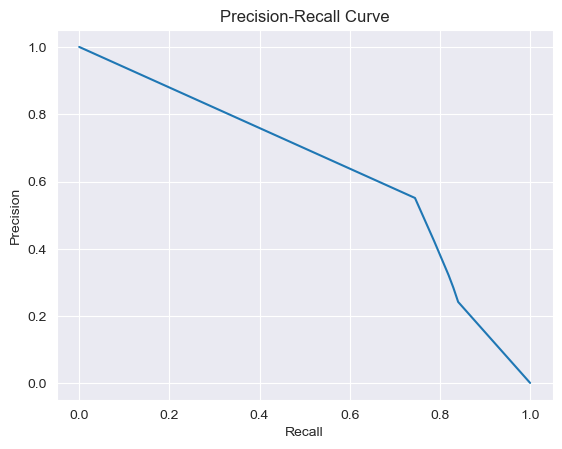

fbeta: 0.7733
AUC: 0.636
[[56489   162]
 [   17    77]]

============ gnb_clf ============
              precision    recall  f1-score   support

           0     0.9991    0.8281    0.9056     56651
           1     0.0053    0.5532    0.0105        94

    accuracy                         0.8277     56745
   macro avg     0.5022    0.6907    0.4581     56745
weighted avg     0.9975    0.8277    0.9041     56745




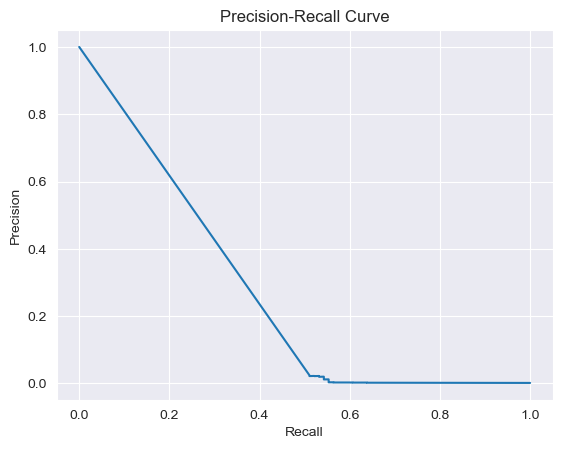

fbeta: 0.1114
AUC: 0.263
[[46915  9736]
 [   42    52]]

============ ada_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9917    0.9957     56651
           1     0.1376    0.7979    0.2347        94

    accuracy                         0.9914     56745
   macro avg     0.5686    0.8948    0.6152     56745
weighted avg     0.9982    0.9914    0.9944     56745




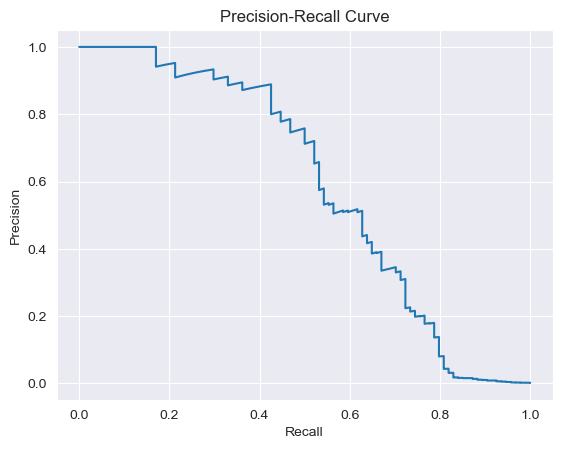

fbeta: 0.6736
AUC: 0.585
[[56181   470]
 [   19    75]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0     0.9992    0.9871    0.9931     56651
           1     0.0639    0.5319    0.1142        94

    accuracy                         0.9863     56745
   macro avg     0.5316    0.7595    0.5536     56745
weighted avg     0.9977    0.9863    0.9917     56745




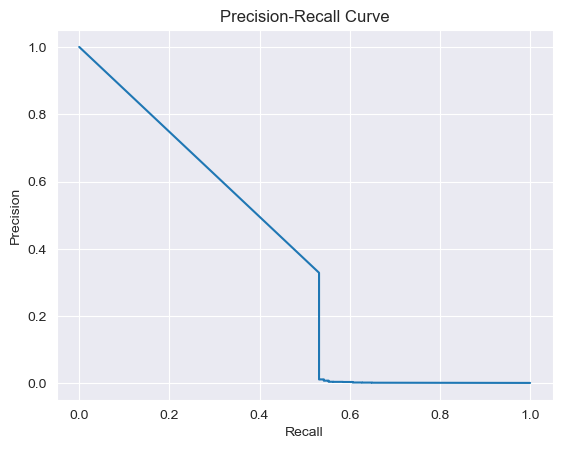

fbeta: 0.4151
AUC: 0.355
[[55919   732]
 [   44    50]]

============ mlp_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9997     56651
           1     0.8718    0.7234    0.7907        94

    accuracy                         0.9994     56745
   macro avg     0.9357    0.8616    0.8952     56745
weighted avg     0.9993    0.9994    0.9993     56745




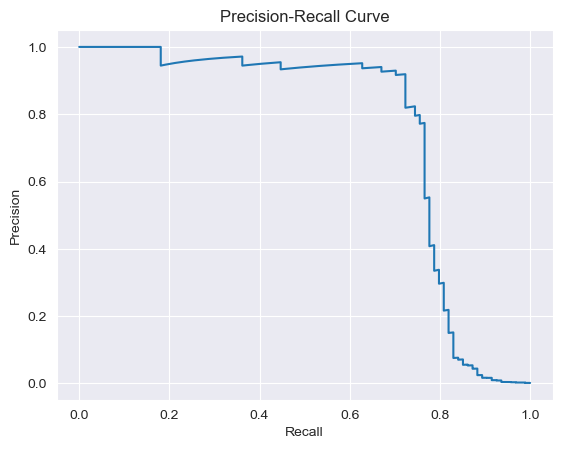

fbeta: 0.7282
AUC: 0.754
[[56641    10]
 [   26    68]]

============ xgb_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56651
           1     0.8235    0.7447    0.7821        94

    accuracy                         0.9993     56745
   macro avg     0.9116    0.8722    0.8909     56745
weighted avg     0.9993    0.9993    0.9993     56745




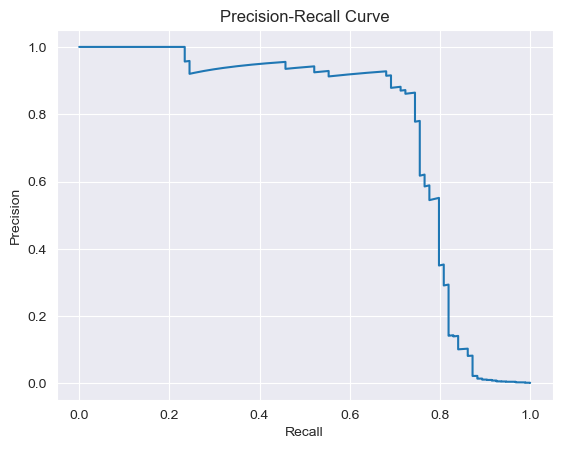

fbeta: 0.7474
AUC: 0.754
[[56636    15]
 [   24    70]]

============ xgbrf_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9880    0.9938     56651
           1     0.1042    0.8404    0.1854        94

    accuracy                         0.9878     56745
   macro avg     0.5520    0.9142    0.5896     56745
weighted avg     0.9982    0.9878    0.9925     56745




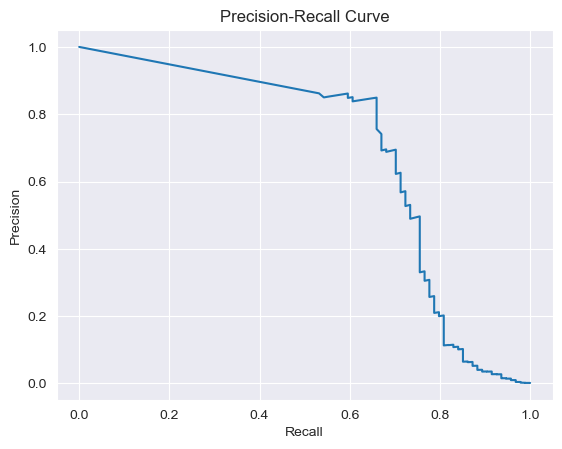

fbeta: 0.6609
AUC: 0.685
[[55972   679]
 [   15    79]]

Stored 'results_smote' (dict)


In [74]:
results_smote = model_tester2(X_smote_train, y_smote_train, X_val, y_val)
%store results_smote

In [75]:
selected_dict = {}

for key, values in results_smote.items():
    selected_dict[key] = values[:9]

results_smote_df = pd.DataFrame(data=selected_dict.values(), index=selected_dict.keys(), \
                          columns=['fbeta', 'bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

results_smote_df

fbeta  bal_acc_score  precisions   recalls        f1  \
rf_clf     0.771005       0.882926    0.923077  0.765957  0.794366   
brf_clf    0.760923       0.877615    0.934211  0.755319  0.798907   
lr_clf     0.742260       0.877077    0.518248  0.755319  0.652929   
knn_clf    0.773272       0.908145    0.322176  0.819149  0.635679   
gnb_clf    0.111386       0.690666    0.005313  0.553191  0.263244   
ada_clf    0.673575       0.894788    0.137615  0.797872  0.585187   
qda_clf    0.415070       0.759497    0.063939  0.531915  0.354664   
mlp_clf    0.728171       0.861614    0.871795  0.723404  0.754459   
xgb_clf    0.747433       0.872208    0.823529  0.744681  0.754301   
xgbrf_clf  0.660875       0.914220    0.104222  0.840426  0.685466   

           false_positives  false_negatives  train_time  test_time  
rf_clf                   6               22  197.830829   0.435099  
brf_clf                  5               23  218.101517   0.449102  
lr_clf                  66               23    2.965675   0.011003  
knn_clf                162               17    0.106025  13.505888  
gnb_clf               9736               42    0.271061   0.048011  
ada_clf                470               19   92.924616   0.524119  
qda_clf                732               44    0.584133   0.076017  
mlp_clf                 10               26   28.865277   0.045010  
xgb_clf                 15               24   21.906600   0.033008  
xgbrf_clf              679               15   20.082252   0.035009

### 7.4 Summary of model selection

# 8. Hyperparameter tuning

- choose smote (gave generally better results) - best of smote fbeta
- choose the ones with best recall (for possible use in voting)

- Katarzyna models
- Mark models

Takes time dont run it, load excel results, load in ros_ada model

# 8. Hyperparameter tuning

Based on the model selection results, we made the following decisions:\
- The SMOTENC sampling strategy gave the highest average model performance (fbeta_score), and we decided to go further with the best performing models on the SMOTENC-balanced dataset.
- As we want to try out VotingClassifier, we decided to include models in the selection, where the number of false negatives is very low, but the false positives are high. We also wanted to see, if it is possible to keep the low number of false negatives, and reduce the number of dalse positives.

To divide the tasks, and to fasten up the training time, we splitted up the models between eachother:
- Katarzyna: 
    - MLP model on the unbalanced dataset
    - RandomForestClassifier with class_weight (0:10 - 1:1)
    - BalancedRandomForestClassifier with class_weight (0:0.1 - 1:0.9)
    - AdaBoostClassifier on RandomOverSample balanced dataset
    - RandomForestClassifier on SMOTENC balanced dataset
    - BalancedRandomForestClassifier on SMOTENC balanced dataset
    
- Márk:
    - KNN model on SMOTENC balanced dataset
    - LogisticRegression model on SMOTENC balanced dataset
    - MLP model on SMOTENC balanced dataset
    - AdaBoostClassifier model on SMOTENC balanced dataset
    - XGB model on SMOTENC balanced dataset
    - XGBRF model on SMOTENC balanced dataset

### Katarzyna's part

In [9]:
def model_tune(model, model_name, search_type, param_dist, X_train, y_train, 
                      X_val, y_val, cv=5, n_iter=None, beta=5):
    
    scorer = make_scorer(fbeta_score, beta=beta)
    
    results = dict()
    print(f"Training {model_name} model...")
        
    if search_type == "Grid":
        search = GridSearchCV(model, param_dist, cv=cv, n_jobs=-1, scoring=scorer, verbose=3, return_train_score = True)
    elif search_type == "Randomized":
        search = RandomizedSearchCV(model, param_dist, cv=cv, n_jobs=-1, n_iter=n_iter, scoring=scorer, verbose=3,\
                                    return_train_score = True, random_state=0)   
    else:
        raise ValueError("Invalid search type!")
        
    start_time = time.time()
    search.fit(X_train, y_train)
    end_time = time.time()
    avg_train_time = (end_time - start_time) / len(search.cv_results_['params'])
    
    test_start_time = time.time()
    y_pred = search.predict(X_val)
    test_end_time = time.time()
    test_time = test_end_time - test_start_time
    
    best_estimator = search.best_estimator_
    best_params = search.best_params_
    cv_details = search.cv_results_
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
            
    # balanced accuracy score
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)

    # Recall -Precision plot
    y_prob = search.predict_proba(X_val)[:, 1]
    precision_prob, recall_prob, threshold_prob = precision_recall_curve(y_val, y_prob)
    plt.plot(recall_prob, precision_prob)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Precision and recall to include in the results
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)    

    # Fbeta metric    
    fbeta =fbeta_score(y_val, y_pred, average='binary', beta=beta, pos_label=1)
    print('fbeta: %.4f' % fbeta, end='\n')

    # AUC under the Recall-Precision 
    auc_score = auc(recall_prob, precision_prob)
    print('AUC: %.3f' % auc_score, end='\n')

    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    
    results[model_name] = [fbeta, bal_acc_score, precision, recall, auc_score, conf_mtr[0,1], conf_mtr[1,0], \
                           avg_train_time, test_time]
        
    
    print(f"\nBest params for {model_name}: {best_params}\n")
    print(f"Best train fbeta for {model_name}: {search.best_score_}\n")
    print(f"Best test fbeta for {model_name}: {fbeta}\n")
            
    return results, best_estimator, best_params, cv_details

In [8]:
amount_scaler = RobustScaler()
clean_train_hour_log = DataCleaner(hour=True, feature_to_drop=[], labels=True, \
                          amount_scaler=amount_scaler, time_scaler=None, amount_log=True)

In [9]:
X_train_hour_amt_robust_log, y_train = clean_train_hour_log.fit_transform(raw_train)

In [11]:
X_val_hour_amt_robust_log, y_val = clean_train_hour_log.transform(raw_val)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint, uniform

hour_indexes = [i for i, x in enumerate(X_train_hour_amt_robust_log.columns) if x.startswith('hour')]
smote = SMOTENC(categorical_features = hour_indexes, random_state=42)
ftwo_scorer = make_scorer(fbeta_score, beta=5)

#-------------------- brf_clf 0: 0.1/ 1: 0.9

brf_class = BalancedRandomForestClassifier(class_weight={0 : 0.1, 1 : 0.9}, random_state=0)

params_brf_class = {'n_estimators': [100, 250, 300],
                  'max_depth': [ None], # 5, 10,
                  'min_samples_split': [2], #, 5, 10
                  'min_samples_leaf': [1], #, 2, 4
                  'max_features': ["sqrt", "log2"],
                  'criterion': ['entropy', 'gini']
                 }

#-------------------- rf_clf 0: 10/ 1: 1

rf_class = RandomForestClassifier(class_weight={0 : 10, 1 : 1}, random_state=0)

params_rf_class = {'n_estimators': [200, 250, 270],
                  'max_depth': [ None], # 5, 10,
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'max_features': ["sqrt", "log2"],
                  'criterion': ['entropy', 'gini']
                 }


#----------------------smotenc brf_clf --------------------------------

brf_clf = BalancedRandomForestClassifier(random_state=0)
smoteb = SMOTENC(categorical_features = hour_indexes, random_state=42)

smote_brf = Pipeline([('sampling', smoteb),
                      ('brf', brf_clf)])

params_smote_brf = {'brf__n_estimators': [200, 250],
                    #'brf__max_depth': [5, 10, None],
                    'brf__min_samples_split': [2, 5, 10],
                    'brf__min_samples_leaf': [1, 2, 4],
                    'brf__max_features': ["sqrt", "log2"],
                    'brf__criterion': ['gini', 'entropy'],
                    'sampling__k_neighbors': [5, 7, 10]}

#----------------------smotenc rf_clf --------------------------------

rf_clf = RandomForestClassifier(random_state=0)
smoter = SMOTENC(categorical_features = hour_indexes, random_state=42)

smote_rf = Pipeline([('sampling', smoter),
                     ('rf', rf_clf)])

params_smote_rf = {'rf__n_estimators': [200, 250],
                   #'rf__max_depth': [5, 10, None],
                   'rf__min_samples_split': [2, 5, 10],
                   'rf__min_samples_leaf': [1, 2, 4],
                   'rf__max_features': ["sqrt", "log2"],
                   'rf__criterion': ['gini', 'entropy'],
                   'sampling__k_neighbors': [5, 7, 10]}

#----------------------ros_ada --------------------------------

#dtc = DecisionTreeClassifier(random_state=0)
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0))

ros = RandomOverSampler(random_state=0)

ros_ada = Pipeline([('sampling', ros),
                    ('classifier', ada_clf)])


params_ros_ada = {'classifier__base_estimator__max_depth': [1, 2],
                  'classifier__base_estimator__min_samples_split': [2, 5, 10],
                  'classifier__base_estimator__min_samples_leaf': [1, 2, 4],
                  'classifier__base_estimator__max_features': ["sqrt", "log2"],
                  'classifier__base_estimator__criterion': ['gini', 'entropy'],
                  'classifier__n_estimators': [100, 200, 500],
                  'classifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

# In case of AdaBoost if we want to tune the base_estimator's hyperparameters we need to marke them with base_estimator__.

# #-------------------- mlp_baseline

# mlp_clf = MLPClassifier(random_state=0)

# params_mlp_clf= {'hidden_layer_sizes': randint(10, 200),
#            'activation': ['relu', 'tanh', 'logistic'],
#            'solver': ['adam', 'sgd', 'lbfgs'],
#            'alpha': uniform(0.0001, 0.1),
#            'learning_rate': ['constant', 'invscaling', 'adaptive'],
#            'learning_rate_init': uniform(0.001, 0.5),
#            'max_iter': randint(100, 500),
#            'early_stopping': [True, False],
#            'validation_fraction': uniform(0.1, 0.4)}


#-------------------- mlp_ baseline with more than one layer

mlp_layer = MLPClassifier(random_state=0)

params__mlp_layer = {
                    'hidden_layer_sizes': [
                        (50,),
                        (100,),
                        (150,),
                        (50, 50),
                        (100, 50),
                        (100, 100),
                        (50, 30, 10),
                        (100, 50, 20)
                    ],
                    'activation': ['relu', 'tanh', 'logistic'],
                    'tol': [1e-4, 1e-3, 1e-2],
                    'solver': ['adam', 'sgd', 'lbfgs'],
                   'alpha': uniform(0.0001, 0.1),
                   'learning_rate': ['constant', 'invscaling', 'adaptive'],
                   'learning_rate_init': uniform(0.001, 0.5),
                   'max_iter': randint(100, 500),
                   'early_stopping': [True, False],
                   'validation_fraction': uniform(0.1, 0.4)}

**ADABoost**
(meta-estimator)
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights to each of the training samples. Initially, those weights are all set to 
, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

In [16]:
model_names = ['brf_class', 'smote_brf', 'smote_rf', 'ros_ada']
models = [brf_class, smote_brf, smote_rf, ros_ada]
params = [params_brf_class, params_smote_brf, params_smote_rf, params_ros_ada ]

In [17]:
from sklearn.model_selection import KFold

# cv-fold for GridSearchCV (NOTE: if we go with class_weight models StratifiedKfold needs to be used)



Training brf_class model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

           0     0.9997    0.9874    0.9935     56651
           1     0.0973    0.8191    0.1740        94

    accuracy                         0.9871     56745
   macro avg     0.5485    0.9033    0.5838     56745
weighted avg     0.9982    0.9871    0.9922     56745




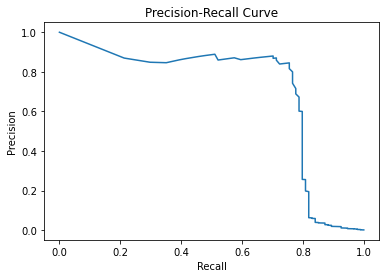

fbeta: 0.6374
AUC: 0.706
[[55937   714]
 [   17    77]]


Best params for brf_class: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 270}

Best train fbeta for brf_class: 0.6995414514166649

Best test fbeta for brf_class: 0.6373766316459727

           parameter value
0          criterion  gini
1          max_depth  None
2       max_features  log2
3   min_samples_leaf     1
4  min_samples_split     2
5       n_estimators   270
           fbeta_val  balanced_accuracy  precision    recall  auc_score  \
brf_class   0.637377           0.903273   0.097345  0.819149   0.706471   

           False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
brf_class              714               17       16.510934   1.081509  


In [177]:
k_fold_cw = KFold(n_splits=5, shuffle=True, random_state=0)
#n_iter = 100
try:
    results_brf_class, best_brf_class, best_params_brf_class, cv_details_brf_class = model_tune(models[0], model_names[0], 
                                                                     'Grid', params[0], X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold_cw, beta=5) #n_iter=NOne,
    best_params_brf_class_df = pd.DataFrame(best_params_brf_class, index=[0]).T.reset_index()
    best_params_brf_class_df.columns = ['parameter', 'value']
    print(best_params_brf_class_df)
    
    results_brf_class_df = pd.DataFrame(data=results_brf_class.values(), index=results_brf_class.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
    results_brf_class_df


except:
    pass


In [ ]:
model_path = os.path.join('models', 'best_rf_class.joblib')
dump(best_rf_class, model_path)

Training smote_brf model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8810    0.7872    0.8315        94

    accuracy                         0.9995     56745
   macro avg     0.9403    0.8935    0.9156     56745
weighted avg     0.9995    0.9995    0.9995     56745




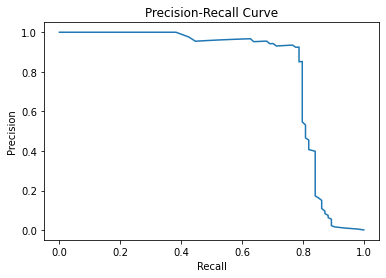

fbeta: 0.7905
AUC: 0.805
[[56641    10]
 [   20    74]]


Best params for smote_brf: {'sampling__k_neighbors': 10, 'brf__n_estimators': 200, 'brf__min_samples_split': 2, 'brf__min_samples_leaf': 1, 'brf__max_features': 'log2', 'brf__criterion': 'entropy'}

Best train fbeta for smote_brf: 0.839939018995163

Best test fbeta for smote_brf: 0.7904683648315531

                parameter    value
0   sampling__k_neighbors       10
1       brf__n_estimators      200
2  brf__min_samples_split        2
3   brf__min_samples_leaf        1
4       brf__max_features     log2
5          brf__criterion  entropy
           fbeta_val  Precision    Recall  Balanced_accuracy  auc_score  \
smote_brf   0.790468   0.893529  0.880952           0.787234   0.805114   

           False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
smote_brf               10               20      628.831252   1.173768  


In [31]:
n_iter = 10
k_fold = KFold(n_splits=5, shuffle=False)
try:
    results_smote_brf, best_smote_brf, best_params_smote_brf, cv_details_smote_brf = model_tune(models[1], model_names[1], 
                                                                     'Randomized', params[1], X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold, n_iter=n_iter, beta=5)

    best_params_smote_brf_df = pd.DataFrame(best_params_smote_brf, index=[0]).T.reset_index()
    best_params_smote_brf_df.columns = ['parameter', 'value']
    print(best_params_smote_brf_df)
    results_smote_brf_df = pd.DataFrame(data=results_smote_brf.values(), index=results_smote_brf.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
    print(results_smote_brf_df)
    
except:
    pass

In [ ]:
model_path = os.path.join('models', 'best_smote_brf.joblib')
dump(best_smote_brf, model_path)

Training smote_rf model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8588    0.7766    0.8156        94

    accuracy                         0.9994     56745
   macro avg     0.9292    0.8882    0.9077     56745
weighted avg     0.9994    0.9994    0.9994     56745




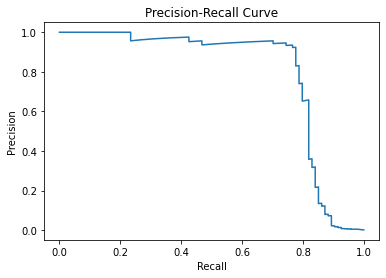

fbeta: 0.7795
AUC: 0.797
[[56639    12]
 [   21    73]]


Best params for smote_rf: {'sampling__k_neighbors': 5, 'rf__n_estimators': 250, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy'}

Best train fbeta for smote_rf: 0.8356659916095847

Best test fbeta for smote_rf: 0.7794661190965092

               parameter    value
0  sampling__k_neighbors        5
1       rf__n_estimators      250
2  rf__min_samples_split        5
3   rf__min_samples_leaf        4
4       rf__max_features     sqrt
5          rf__criterion  entropy
          fbeta_val  Precision    Recall  Balanced_accuracy  auc_score  \
smote_rf   0.779466   0.888192  0.858824           0.776596   0.797237   

          False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
smote_rf               12               21      589.436599   1.285987  


In [32]:
n_iter = 10
k_fold = KFold(n_splits=5, shuffle=False)

try:
    results_smote_rf, best_smote_rf, best_params_smote_rf, cv_details_smote_rf = model_tune(models[2], model_names[2], 
                                                                     'Randomized', params[2], X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold, n_iter=n_iter, beta=5)

    best_params_smote_rf_df = pd.DataFrame(best_params_smote_rf, index=[0]).T.reset_index()
    best_params_smote_rf_df.columns = ['parameter', 'value']
    print(best_params_smote_rf_df)
    results_smote_rf_df = pd.DataFrame(data=results_smote_rf.values(), index=results_smote_rf.keys(),\
                      columns=columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
    print(results_smote_rf_df)
except:
    pass

In [ ]:
model_path = os.path.join('models', 'best_smote_rf.joblib')
dump(best_smote_rf, model_path)

Training ros_ada model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994     56651
           1     0.5938    0.8085    0.6847        94

    accuracy                         0.9988     56745
   macro avg     0.7967    0.9038    0.8420     56745
weighted avg     0.9990    0.9988    0.9989     56745




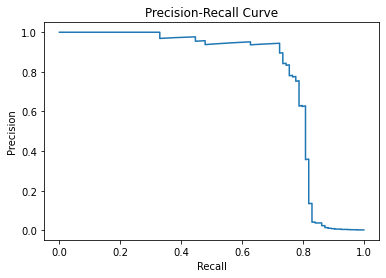

fbeta: 0.7974
AUC: 0.778
[[56599    52]
 [   18    76]]


Best params for ros_ada: {'classifier__n_estimators': 500, 'classifier__learning_rate': 0.1, 'classifier__base_estimator__min_samples_split': 10, 'classifier__base_estimator__min_samples_leaf': 2, 'classifier__base_estimator__max_features': 'log2', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__criterion': 'gini'}

Best train fbeta for ros_ada: 0.8338265681750036

Best test fbeta for ros_ada: 0.7974172719935432

                                       parameter value
0                       classifier__n_estimators   500
1                      classifier__learning_rate   0.1
2  classifier__base_estimator__min_samples_split    10
3   classifier__base_estimator__min_samples_leaf     2
4       classifier__base_estimator__max_features  log2
5          classifier__base_estimator__max_depth     2
6          classifier__base_estimator__criterion  gini
         fbeta_val  balanced_accuracy  precision    recall  

In [48]:
n_iter = 30
k_fold = KFold(n_splits=5, shuffle=False)

try:
    results_ros_ada, best_ros_ada, best_params_ros_ada, cv_details_ros_ada = model_tune(models[3], model_names[3], 
                                                                     'Randomized', params[3], X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold, n_iter=n_iter, beta=5)

    best_params_ros_ada_df = pd.DataFrame(best_params_ros_ada, index=[0]).T.reset_index()
    best_params_ros_ada_df.columns = ['parameter', 'value']
    print(best_params_ros_ada_df)
    results_ros_ada_df = pd.DataFrame(data=results_ros_ada.values(), index=results_ros_ada.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
    print(results_ros_ada_df)
except:
    pass

In [ ]:
model_path = os.path.join('models', 'best_ros_ada.joblib')
dump(best_ros_ada, model_path)

Training mlp_layer model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\katar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid featur

              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56651
           1     0.8235    0.7447    0.7821        94

    accuracy                         0.9993     56745
   macro avg     0.9116    0.8722    0.8909     56745
weighted avg     0.9993    0.9993    0.9993     56745




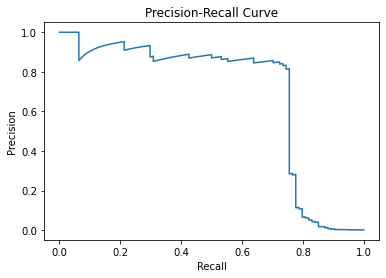

fbeta: 0.7474
AUC: 0.687
[[56636    15]
 [   24    70]]


Best params for mlp_layer: {'activation': 'tanh', 'alpha': 0.0558368791323917, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.04927480491372904, 'max_iter': 384, 'solver': 'adam', 'tol': 0.01, 'validation_fraction': 0.12214972816847919}

Best train fbeta for mlp_layer: 0.7903115079893287

Best test fbeta for mlp_layer: 0.7474332648870636

             parameter     value
0           activation      tanh
1                alpha  0.055837
2       early_stopping      True
3   hidden_layer_sizes       100
4        learning_rate  constant
5   learning_rate_init  0.049275
6             max_iter       384
7               solver      adam
8                  tol      0.01
9  validation_fraction   0.12215


fbeta_val  balanced_accuracy  precision    recall  auc_score  \
mlp_layer   0.747433           0.872208   0.823529  0.744681   0.686984   

           False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
mlp_layer               15               24       39.437345   0.337995

In [139]:
n_iter = 50
k_fold = KFold(n_splits=5, shuffle=False)

results_mlp_layer, best_mlp_layer, best_params_mlp_layer, cv_details_mlp_layer = model_tune(mlp_layer, 'mlp_layer', 
                                                                     'Randomized', params__mlp_layer, X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold, n_iter=n_iter, beta=5)

best_params_mlp_layer_df = pd.DataFrame(best_params_mlp_layer, index=[0]).T.reset_index()
best_params_mlp_layer_df.columns = ['parameter', 'value']
print(best_params_mlp_layer_df)
results_mlp_layer_df = pd.DataFrame(data=results_mlp_layer.values(), index=results_mlp_layer.keys(),\
                  columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
results_mlp_layer_df


In [ ]:
model_path = os.path.join('models', 'best_mlp_layer.joblib')
dump(best_mlp_layer, model_path)

Training rf_class model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.9333    0.7447    0.8284        94

    accuracy                         0.9995     56745
   macro avg     0.9665    0.8723    0.9141     56745
weighted avg     0.9995    0.9995    0.9995     56745




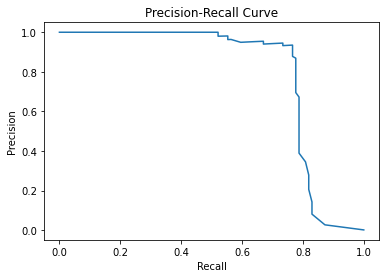

fbeta: 0.7505
AUC: 0.788
[[56646     5]
 [   24    70]]


Best params for rf_class: {'n_estimators': 270, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}

Best train fbeta for rf_class: 0.7498974146344947

Best test fbeta for rf_class: 0.7505154639175258

           parameter    value
0       n_estimators      270
1  min_samples_split        2
2   min_samples_leaf        1
3       max_features     sqrt
4          max_depth     None
5          criterion  entropy
          fbeta_val  balanced_accuracy  precision    recall  auc_score  \
rf_class   0.750515           0.872296   0.933333  0.744681   0.787943   

          False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
rf_class                5               24      238.594345   1.090115  


In [138]:
k_fold_cw = KFold(n_splits=5, shuffle=True, random_state=0)
n_iter = 20
try:
    results_rf_class, best_rf_class, best_params_rf_class, cv_details_rf_class = model_tune(rf_class, 'rf_class', 
                                                                     'Randomized', params_rf_class, X_train_hour_amt_robust_log, y_train, 
                                                                     X_val_hour_amt_robust_log, y_val, cv=k_fold_cw, n_iter=n_iter, beta=5)
    best_params_rf_class_df = pd.DataFrame(best_params_rf_class, index=[0]).T.reset_index()
    best_params_rf_class_df.columns = ['parameter', 'value']
    print(best_params_rf_class_df)
    
    results_rf_class_df = pd.DataFrame(data=results_rf_class.values(), index=results_rf_class.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
    print(results_rf_class_df)


except:
    pass


In [ ]:
model_path = os.path.join('models', 'best_rf_class.joblib')
dump(best_rf_class, model_path)

In [83]:
results_smote_brf_df.columns = ['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time']
results_smote_rf_df.columns = ['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time']
#results_ros_ada_df.columns = ['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time']

In [140]:
# join the two dataframes with prefixes for the columns with the same name
search_concat_df = pd.concat([results_brf_class_df, results_smote_brf_df, results_smote_rf_df, results_ros_ada_df, results_mlp_layer_df, results_rf_class_df],  sort=False)
#search_concat_df.columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])

# print the joined dataframe
search_concat_df

fbeta_val  balanced_accuracy  precision    recall  auc_score  \
brf_class   0.637783           0.903290   0.097592  0.819149   0.702109   
smote_brf   0.790468           0.893529   0.880952  0.787234   0.805114   
smote_rf    0.779466           0.888192   0.858824  0.776596   0.797237   
ros_ada     0.797417           0.903796   0.593750  0.808511   0.777767   
mlp_layer   0.747433           0.872208   0.823529  0.744681   0.686984   
rf_class    0.750515           0.872296   0.933333  0.744681   0.787943   

           False_Positives  False_Negatives  Avg_Train_Time  Test_Time  
brf_class              712               17       17.717573   0.853636  
smote_brf               10               20      628.831252   1.173768  
smote_rf                12               21      589.436599   1.285987  
ros_ada                 52               18      204.735990   6.234252  
mlp_layer               15               24       39.437345   0.337995  
rf_class                 5               24      238.594345   1.090115

### VOTING 3 BEST FBETA

In [30]:
hour_indexes = [i for i, x in enumerate(X_train_hour_amt_robust_log.columns) if x.startswith('hour')]


### ----------------- ros_ada -----------------------------

ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, 
                                                                   max_features='log2',
                                                                   min_samples_leaf=2,
                                                                   min_samples_split=10,
                                                                   random_state=0), 
                             n_estimators = 500,
                             learning_rate = 0.1)

ros = RandomOverSampler(random_state=0)

ros_ada = Pipeline([('sampling', ros),
                    ('classifier', ada_clf)])

### ------------------- smote_brf --------------------------------

smotea = SMOTENC(categorical_features = hour_indexes,
                 k_neighbors=10,
                 random_state=42)

brf_clf = BalancedRandomForestClassifier(n_estimators=200,
                                         min_samples_split=2,
                                         min_samples_leaf=1,
                                         max_features='log2',
                                         criterion='entropy',
                                         random_state=0)


smote_brf = Pipeline([('sampling', smotea),
                      ('brf', brf_clf)])


### ------------------- smote_rf --------------------------------

smoteb = SMOTENC(categorical_features = hour_indexes,
                 k_neighbors=5,
                 random_state=42)

rf_clf = BalancedRandomForestClassifier(n_estimators=250,
                                         min_samples_split=5,
                                         min_samples_leaf=4,
                                         max_features='sqrt',
                                         criterion='entropy',
                                         random_state=0)


smote_rf = Pipeline([('sampling', smoteb),
                      ('brf', rf_clf)])


In [31]:
voting_3best_fbeta_soft = VotingClassifier(
                            estimators=[('ros_ada', ros_ada),
                                        ('smote_brf', smote_brf ), 
                                        ('smote_rf', smote_rf )],
                             voting='soft')

============ voting_3best_fbeta_soft ============
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8690    0.7766    0.8202        94

    accuracy                         0.9994     56745
   macro avg     0.9343    0.8882    0.9100     56745
weighted avg     0.9994    0.9994    0.9994     56745




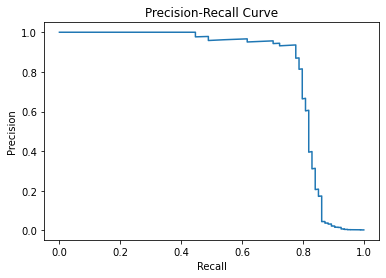

fbeta: 0.7798
AUC: 0.807
[[56640    11]
 [   21    73]]



In [32]:
results_voting_3best_fbeta_soft, voting_3best_fbeta_soft, y_prob_voting_3best_fbeta_soft = model_tester3(voting_3best_fbeta_soft, 'voting_3best_fbeta_soft', 
                                                                                                         X_train_hour_amt_robust_log, y_train, 
                                                                                                         X_val_hour_amt_robust_log, y_val)

In [55]:
%store results_voting_3best_fbeta_soft

Stored 'results_voting_3best_fbeta_soft' (dict)


In [56]:
%store y_prob_voting_3best_fbeta_soft

Stored 'y_prob_voting_3best_fbeta_soft' (ndarray)


In [57]:
results_voting_3best_fbeta_soft_df = pd.DataFrame(data=results_voting_3best_fbeta_soft.values(), index=results_voting_3best_fbeta_soft.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
results_voting_3best_fbeta_soft_df

fbeta_val  balanced_accuracy  precision    recall  \
voting_3best_fbeta_soft   0.779786           0.888201   0.869048  0.776596   

                         auc_score  False_Positives  False_Negatives  \
voting_3best_fbeta_soft   0.807352               11               21   

                         Avg_Train_Time  Test_Time  
voting_3best_fbeta_soft     1341.127286  10.527442

In [58]:
model_path = os.path.join('models', 'voting_3best_fbeta_soft.joblib')
dump(voting_3best_fbeta_soft, model_path)

['models\\voting_3best_fbeta_soft.joblib']

In [33]:
voting_3best_fbeta_hard = VotingClassifier(
                            estimators=[('ros_ada', ros_ada),
                                        ('smote_brf', smote_brf ), 
                                        ('smote_rf', smote_rf )],
                            voting='hard')

In [35]:
#results_voting_3best_fbeta_hard, voting_3best_fbeta_hard, y_prob_voting_3best_fbeta_hard = model_tester3(voting_3best_fbeta_hard, 'voting_3best_fbeta_hard', 
#                                                                                                         X_train_hour_amt_robust_log, y_train, 
#                                                                                                         X_val_hour_amt_robust_log, y_val)

# VOTING 5 BEST RECALL

In [47]:
hour_indexes = [i for i, x in enumerate(X_train_hour_amt_robust_log.columns) if x.startswith('hour')]


### ----------------- ros_ada -----------------------------

ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, 
                                                                   max_features='log2',
                                                                   min_samples_leaf=2,
                                                                   min_samples_split=10,
                                                                   random_state=0), 
                             n_estimators = 500,
                             learning_rate = 0.1)

ros = RandomOverSampler(random_state=0)

ros_ada = Pipeline([('sampler', ros),
                    ('classifier', ada_clf)])


### ----------------- brf_class -----------------------------
brf_class = BalancedRandomForestClassifier(class_weight={0 : 0.1, 1 : 0.9}, 
                                           criterion='gini',
                                           max_depth=None,
                                           max_features='log2',
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           n_estimators=270,
                                           random_state=0)

### ----------------- smote_xgbrf -----------------------------
base_score = y_train.sum()/len(y_train)

smotex = SMOTENC(categorical_features = hour_indexes,
                 k_neighbors=3,
                 random_state=42)

xgbrf_clf = xgb.XGBRFClassifier(base_score=base_score,
                                booster='gbtree',
                                eval_metric=make_scorer(fbeta_score, beta=5),
                                grow_policy='lossguide',
                                learning_rate=0.0331490191902074,
                                max_depth=13,
                                max_leaves=3,
                                n_estimators=147,
                                n_jobs=-1,
                                random_state=42,
                                reg_alpha=0.9700720455986775,
                                reg_lambda=0.5945228435042452,
                                verbosity=1)

smote_xgbrf = Pipeline([('sampler', smotex),
                        ('classifier', xgbrf_clf)])


### ----------------- smote_lr -----------------------------

smotelr = SMOTENC(categorical_features = hour_indexes,
                 k_neighbors=10,
                 random_state=42)

lr_clf=LogisticRegression(C=6.400295578564125,
                          l1_ratio=0.5451795862194609,
                          penalty='l2',
                          random_state=42,
                          n_jobs=-1,
                          solver='saga',
                          verbose=1)

smote_lr = Pipeline([('sampler', smotelr),
                      ('classifier', lr_clf)])

### ----------------- KNN -----------------------------

smoteknn = SMOTENC(categorical_features = hour_indexes,
                 k_neighbors=10,
                 random_state=0)

knn_clf = KNeighborsClassifier(leaf_size=38,
                               metric='l1',
                               n_neighbors=6,
                               weights='distance')

smote_knn = Pipeline([('sampler', smoteknn),
                       ('classifier', knn_clf)])

In [48]:
voting_5best_recall_soft = VotingClassifier(
                            estimators=[('ros_ada', ros_ada),
                                        ('brf_class', brf_class), 
                                        ('smote_xgbrf', smote_xgbrf),
                                        ('smote_lr', smote_lr),
                                        ('smote_knn', smote_knn)],
                            voting='soft')

============ voting_5best_recall_soft ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   43.4s finished


              precision    recall  f1-score   support

           0     0.9997    0.9962    0.9979     56651
           1     0.2610    0.8191    0.3959        94

    accuracy                         0.9959     56745
   macro avg     0.6304    0.9077    0.6969     56745
weighted avg     0.9985    0.9959    0.9969     56745




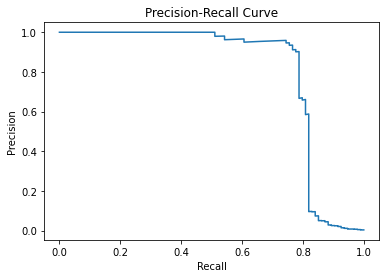

fbeta: 0.7569
AUC: 0.801
[[56433   218]
 [   17    77]]



In [49]:
results_voting_5best_recall_soft, voting_5best_recall_soft, y_prob_voting_5best_recall_soft = model_tester3(voting_5best_recall_soft, 'voting_5best_recall_soft', 
                                                                                                         X_train_hour_amt_robust_log, y_train, 
                                                                                                         X_val_hour_amt_robust_log, y_val)

In [50]:
%store results_voting_5best_recall_soft

Stored 'results_voting_5best_recall_soft' (dict)


In [51]:
%store y_prob_voting_5best_recall_soft

Stored 'y_prob_voting_5best_recall_soft' (ndarray)


In [52]:
results_voting_5best_recall_soft_df = pd.DataFrame(data=results_voting_5best_recall_soft.values(), index=results_voting_5best_recall_soft.keys(),\
                      columns=['fbeta_val', 'balanced_accuracy', 'precision', 'recall', 'auc_score', 'False_Positives', 'False_Negatives', 'Avg_Train_Time', 'Test_Time'])
results_voting_5best_recall_soft_df

fbeta_val  balanced_accuracy  precision    recall  \
voting_5best_recall_soft     0.7569            0.90765   0.261017  0.819149   

                          auc_score  False_Positives  False_Negatives  \
voting_5best_recall_soft   0.801133              218               17   

                          Avg_Train_Time   Test_Time  
voting_5best_recall_soft      621.484973  2785.77668

In [54]:
model_path = os.path.join('models', 'voting_5best_recall_soft.joblib')
dump(voting_5best_recall_soft, model_path)

['models\\voting_5best_recall_soft.joblib']

In [60]:
voting_concat_df = pd.concat([results_voting_3best_fbeta_soft_df, results_voting_5best_recall_soft_df])

In [61]:
voting_concat_df.to_excel('voting_results.xlsx', index=True)

### Márk's part

In [ ]:
# categorical columns
hour_indexes = [i for i, x in enumerate(X_train_hour_amt_robust_log.columns) if x.startswith('hour')]

# scorer for GridSearchCV
ftwo_scorer = make_scorer(fbeta_score, beta=5)

# cv-fold for GridSearchCV (NOTE: if we go with class_weight models StratifiedKfold needs to be used)
k_fold = KFold(n_splits=5, shuffle=False)

def grid_serach(params, clf, n_iter=10):
    # categorical columns
    hour_indexes = [i for i, x in enumerate(X_train_hour_amt_robust_log.columns) if x.startswith('hour')]    
    # scorer for GridSearchCV
    ftwo_scorer = make_scorer(fbeta_score, beta=5)    
    # cv-fold for GridSearchCV (NOTE: if we go with class_weight models StratifiedKfold needs to be used)
    k_fold = KFold(n_splits=5, shuffle=False)
    
    
    imba_pipeline = imbalanced_pipeline([('smotenc', SMOTENC(random_state=42, categorical_features=hour_indexes)), 
                              ('clf', clf)])
    grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=params, n_iter=n_iter, cv=k_fold, scoring=ftwo_scorer,\
                            return_train_score=True, verbose=True, n_jobs=8)
    
    start_time = time.time()
    grid_imba.fit(X_train_hour_amt_robust_log, y_train)
    fit_time = time.time() - start_time
    
    start_time = time.time()
    predict_bal = grid_imba.best_estimator_.predict(X_val_hour_amt_robust_log)
    predict_time = time.time() - start_time
    
    start_time = time.time()
    predict_bal_proba = grid_imba.best_estimator_.predict_proba(X_val_hour_amt_robust_log)[:, 1]
    proba_time = time.time() - start_time
    
    precision_prob, recall_prob, threshold_prob = precision_recall_curve(y_val, predict_bal_proba)
    plt.plot(recall_prob, precision_prob)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    auc_score = auc(recall_prob, precision_prob)
    conf_mtr = confusion_matrix(y_val, predict_bal)
    
    eval_bal = {'fbeta':fbeta_score(y_val, predict_bal, beta=5), 'bal_acc_score':balanced_accuracy_score(y_val, predict_bal),\
                   'precision':precision_score(y_val, predict_bal), 'recall':recall_score(y_val, predict_bal),\
                   'auc_score':auc_score, 'false_positive':conf_mtr[0,1], 'false_negative':conf_mtr[1,0],\
                   'train_time':fit_time, 'predict_time':predict_time, 'proba_time': proba_time}
    return eval_bal, predict_bal, predict_bal_proba, grid_imba.best_params_, precision_prob, recall_prob, threshold_prob

# KNN

In [ ]:
knn_params = {
    'clf__leaf_size': randint(10,50),
    'clf__metric': ['minkowski', 'l1', 'l2'],
    'clf__n_neighbors': randint(3,12),
    'clf__weights': ['uniform', 'distance'],
    'smotenc__k_neighbors': randint(7,18),
    'smotenc__sampling_strategy': ['minority']
}

knn_clf = KNeighborsClassifier() #proba

In [ ]:
knn_eval_bal = grid_serach(knn_params, knn_clf, n_iter=10)
%store knn_eval_bal

In [ ]:
knn_clf_eval, knn_clf_predict, knn_clf_proba, knn_clf_params, knn_clf_pr, knn_clf_re, knn_clf_th = knn_eval_bal

In [ ]:
knn_clf_eval_df = pd.DataFrame(data=knn_clf_eval.values(), index=knn_clf_eval.keys(), columns=['KNN'])
knn_clf_eval_df

In [ ]:
knn_clf_params

# Logistic regression

In [ ]:
lr_params = {
    'clf__penalty':['l2','l1'],
    'clf__C': uniform(0.1,10),
    'clf__l1_ratio': uniform(0.1,1),
    'smotenc__k_neighbors': randint(3,12),
    'smotenc__sampling_strategy': ['minority']
}

lr_clf = LogisticRegression(random_state=42, n_jobs=-1, solver='saga', verbose=1)

In [ ]:
lr_eval_bal = grid_serach(lr_params, lr_clf, n_iter=10)
%store lr_eval_bal

In [ ]:
lr_clf_eval, lr_clf_predict, lr_clf_proba, lr_clf_params, lr_clf_pr, lr_clf_re, lr_clf_th = lr_eval_bal

In [ ]:
lr_clf_eval_df = pd.DataFrame(data=lr_clf_eval.values(), index=lr_clf_eval.keys(), columns=['Logistic Regression'])
lr_clf_eval_df

In [ ]:
lr_clf_params

# XGB

In [ ]:
xgb_params = {
    'clf__booster': ['gbtree', 'gblinear', 'dart'],
    'clf__grow_policy': ['depthwise', 'lossguide'],
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__max_depth': randint(3,10),
    'clf__max_leaves': randint(0,50),
    'clf__n_estimators': randint(50,200),
    'clf__n_jobs': [4],
    'clf__random_state': [42],
    'clf__reg_alpha': uniform(0,1),
    'clf__reg_lambda': uniform(0,1),
    'clf__verbosity': [1],
    'smotenc__k_neighbors': randint(3,12),
    'smotenc__sampling_strategy': ['minority']
}

In [ ]:
base_score = y_train.sum()/len(y_train)
xgb_clf = xgb.XGBClassifier(base_score=base_score)

In [ ]:
xgb_eval_bal = grid_serach(xgb_params, xgb_clf, n_iter=25)
%store xgb_eval_bal

In [ ]:
xgb_clf_eval, xgb_clf_predict, xgb_clf_proba, xgb_clf_params, xgb_clf_pr, xgb_clf_re, xgb_clf_th = xgb_eval_bal

In [ ]:
xgb_clf_eval_df = pd.DataFrame(data=xgb_clf_eval.values(), index=xgb_clf_eval.keys(), columns=['XGB'])
xgb_clf_eval_df

In [ ]:
xgb_clf_params

# XGBRF

In [ ]:
xgbrf_params = {
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__reg_lambda': uniform(0,1),
    'clf__booster': ['gbtree', 'gblinear', 'dart'],
    'clf__eval_metric': [ftwo_scorer],
    'clf__grow_policy': ['depthwise', 'lossguide'],
    'clf__max_depth': randint(3,5,10),
    'clf__max_leaves': randint(0,50),
    'clf__n_estimators': randint(50,200),
    'clf__n_jobs': [4],
    'clf__random_state': [42],
    'clf__reg_alpha': uniform(0,1),
    'clf__verbosity': [1],
    'smotenc__k_neighbors': randint(3,12),
    'smotenc__sampling_strategy': ['minority']
}

In [ ]:
base_score = y_train.sum()/len(y_train)
xgbrf_clf = xgb.XGBRFClassifier(base_score=base_score)

In [ ]:
xgbrf_eval = grid_serach(xgbrf_params, xgbrf_clf, n_iter=25)
%store xgbrf_eval

In [ ]:
xgbrf_clf_eval, xgbrf_clf_pred, xgbrf_clf_proba, xgbrf_clf_params, xgbrf_clf_pr, xgbrf_clf_re, xgbrf_clf_th = xgbrf_eval

In [ ]:
xgbrf_clf_eval_df = pd.DataFrame(data=xgbrf_clf_eval.values(), index=xgbrf_clf_eval.keys(), columns=['XGBRF'])
xgbrf_clf_eval_df

In [ ]:
xgbrf_clf_params

# ADA

In [ ]:
ada_params = {
    'clf__algorithm': ['SAMME', 'SAMME.R'],    
    'clf__learning_rate': uniform(0,5),
    'clf__n_estimators': randint(50,200),
    'smotenc__k_neighbors': randint(3,12),
    'smotenc__sampling_strategy': ['minority']
}

In [ ]:
ada_clf = AdaBoostClassifier(random_state=42)

In [ ]:
ada_eval = grid_serach(ada_params, ada_clf, n_iter=10)
%store ada_eval

In [ ]:
ada_clf_eval, ada_clf_pred, ada_clf_proba, ada_clf_params, ada_clf_pr, ada_clf_re, ada_clf_th = ada_eval

In [ ]:
ada_clf_eval_df = pd.DataFrame(data=ada_clf_eval.values(), index=ada_clf_eval.keys(), columns=['ADA'])
ada_clf_eval_df

In [ ]:
ada_clf_params

# MLP

In [ ]:
mlp_params = {
    'clf__activation': ['relu', 'logistic'],
    'clf__alpha': uniform(0.0001,0.99),
    'clf__epsilon': uniform(0.00000001,0.001),
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__max_iter': randint(100,250),
    'clf__momentum': uniform(0,1),
    'clf__solver': ['adam', 'sgd'],
    'clf__warm_start': [True, False],
    'smotenc__k_neighbors': randint(3,12),
    'smotenc__sampling_strategy': ['minority']
}

In [ ]:
mlp_clf = MLPClassifier(random_state=42, verbose=True)

In [ ]:
mlp_eval = grid_serach(mlp_params, mlp_clf, n_iter=25)
%store mlp_eval

In [ ]:
mlp_clf_eval, mlp_clf_pred, mlp_clf_proba, mlp_clf_params, mlp_clf_pr, mlp_clf_re, mlp_clf_th = mlp_eval

In [ ]:
mlp_clf_eval_df = pd.DataFrame(data=mlp_clf_eval.values(), index=mlp_clf_eval.keys(), columns=['MLP'])
mlp_clf_eval_df

In [ ]:
mlp_clf_params

### 8.1 Summary of hyperparameter tuning

As we ran the hyperparameter tuning on different machines, and it takes a lot of time to run them here again, we refrained to show the results here imported from an excel file that we created based on our findings.

In [77]:
hyperparameter_tuning_results = pd.read_excel('balanced_dataset_results_UPDATED.xlsx', sheet_name='import')
hyperparameter_tuning_results

Unnamed: 0     fbeta  bal_acc_score  precision    recall  \
0                    ros_ada  0.797417       0.903796   0.593750  0.808511   
1                  smote_brf  0.790468       0.893529   0.880952  0.787234   
2    voting_3best_fbeta_soft  0.779786       0.888201   0.869048  0.776596   
3                   smote_rf  0.779466       0.888192   0.858824  0.776596   
4        Logistic Regression  0.774424       0.898115   0.446429  0.797872   
5                        KNN  0.764114       0.902843   0.322034  0.808511   
6                        MLP  0.763795       0.892779   0.437870  0.787234   
7   voting_5best_recall_soft  0.756900       0.907650   0.261017  0.819149   
8                   rf_class  0.750515       0.872296   0.933333  0.744681   
9                  mlp_layer  0.747433       0.872208   0.823529  0.744681   
10                       ADA  0.729068       0.876680   0.390110  0.755319   
11                       XGB  0.712329       0.871149   0.341463  0.744681   
12                 brf_class  0.637783       0.903290   0.097592  0.819149   
13                     XGBRF  0.534292       0.912620   0.051847  0.851064   

    auc_score  false_positive  false_negative    train_time  predict_time  
0    0.777767              52              18    204.735990      6.234252  
1    0.805114              10              20    628.831252      1.173768  
2    0.807352              11              21   1341.127286     10.527442  
3    0.797237              12              21    589.436599      1.285987  
4    0.692947              93              19    797.833751      0.013004  
5    0.631093             160              18   6471.183148     74.701642  
6    0.742676              95              20   4459.932710      0.078017  
7    0.801133             218              17    621.484973   2785.776680  
8    0.787943               5              24    238.594345      1.090115  
9    0.686984              15              24     39.437345      0.337995  
10   0.712393             111              23   3029.172641      1.028234  
11   0.564444             135              24  36006.675770      0.061014  
12   0.702109             712              17     17.717573      0.853636  
13   0.698080            1463              14   2829.560365      0.152035

# 9. Model testing

WRITE CLEAR STEPS FOR THE CELLS / BLOCKS

As the dataframe shows, the AdaBoostClassifier model on the balanced dataset using RandomOverSample gave the best fbeta_score, so we choose this model.

The hyperparameters are stored, and now we will retrain the model, but this time using the whole training set, plus the validation dataset, so we will have more data to train the model on.

In [187]:
best_params_ada_ros = {'classifier__n_estimators': 500,\
                       'classifier__learning_rate': 0.1,\
                       'classifier__base_estimator__min_samples_split': 10,\
                       'classifier__base_estimator__min_samples_leaf': 2,\
                       'classifier__base_estimator__max_features': 'log2',\
                       'classifier__base_estimator__max_depth': 2, \
                       'classifier__base_estimator__criterion': 'gini'}

In [118]:
# raw train and validation data combined
X_train_final = pd.concat([raw_train, raw_val], axis=0)
y_train_final = X_train_final.pop('Class')

In [123]:
# dataset-preprocessing
scaler = RobustScaler()
clean_data_final = DataCleaner1(hour=True, amount_scaler=scaler, amount_log = True)

# dataset-balancing
ros_final = RandomOverSampler(random_state=42)

# model
clr_final = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, estimator=DecisionTreeClassifier(min_samples_split= 10,\
                                                                                                     min_samples_leaf= 2,\
                                                                                                     max_features= 'log2',\
                                                                                                     max_depth= 2, \
                                                                                                     criterion= 'gini',\
                                                                                                     random_state=42))

In [126]:
# transform_pipeline = Pipeline([('datacleaner', clean_data_final),
#                            ('sampling', ros_final)])

In [ ]:
# final_pipeline = Pipeline([('transform',transform_pipeline),
#                            ('classifier', clr_final)])

In [129]:
final_pipeline = imbalanced_pipeline([('datacleaner', clean_data_final),
                                      ('sampling', ros_final),
                                      ('classifier', clr_final)])

In [137]:
ftwo_scorer = make_scorer(fbeta_score, beta=5)
k_fold = KFold(n_splits=5, shuffle=False)
cv_final_train = cross_val_score(final_pipeline, X_train_final, y_train_final, scoring=ftwo_scorer, cv=k_fold)

In [138]:
cv_final_train

array([0.86092715, 0.85119048, 0.82223287, 0.80981595, 0.78234704])

In [132]:
final_pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('datacleaner',
                 DataCleaner1(amount_log=True, amount_scaler=RobustScaler())),
                ('sampling', RandomOverSampler(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                     max_features='log2',
                                                                     min_samples_leaf=2,
                                                                     min_samples_split=10,
                                                                     random_state=42),
                                    learning_rate=0.1, n_estimators=500))])

In [276]:
X_test = raw_test.copy()
y_test = X_test.pop('Class')

In [277]:
y_pred_final = final_pipeline.predict(X_test)

In [278]:
fbeta_final = fbeta_score(y_test, y_pred_final, beta =5)
print(f'The FBeta score for the final model is: {fbeta_final}')

The FBeta score for the final model is: 0.8347689898198905


In [ ]:
y_prob_final = final_pipeline.predict_proba(X_test)

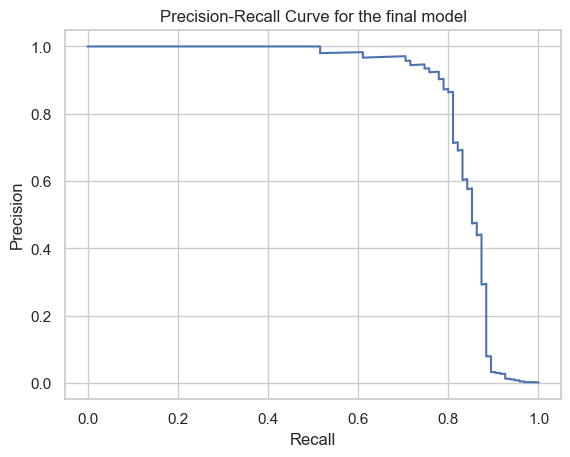

In [279]:
precision_final, recall_final, threshold_final = precision_recall_curve(y_test, y_prob_final[:,1])
plt.plot(recall_final, precision_final)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for the final model')
plt.show()

In [151]:
auc_score_final = auc(recall_final, precision_final)
conf_mtr_final = confusion_matrix(y_test, y_pred_final)

In [152]:
auc_score_final

0.839788043320955

<AxesSubplot: >

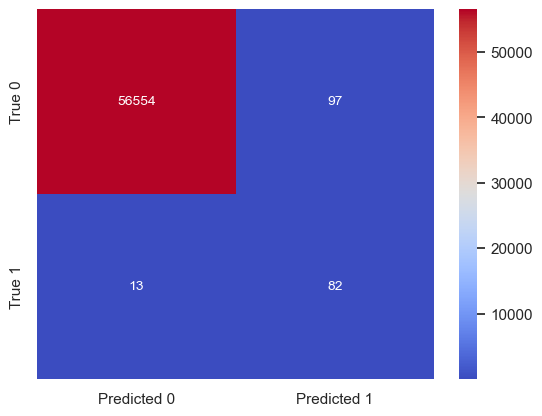

In [281]:
sns.heatmap(conf_mtr_final, annot=True, fmt="d", annot_kws={"size": 10}, cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])

In [156]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.46      0.86      0.60        95

    accuracy                           1.00     56746
   macro avg       0.73      0.93      0.80     56746
weighted avg       1.00      1.00      1.00     56746



# 10. Decision threshold tuning

In order to use the threshold tuning strategy, we will do the following steps:
- Using the 'full' training dataset, we run a cross_val_predict method, and return the cross validated probabilities for each training observation.
- Using the predicted probabilities, we can use the model_threshold_finder function to find the threshold that would return the highest FBeta score for this 'full' train dataset.
- We predict the probabilities for the observations in the test dataset.
- Using the threshold we found before, we 'translate' the test datasets probabilities to predictions.
- We compare the results for the standard predictions and the threshold tuned predictions.

In [160]:
cv_prob_final = cross_val_predict(final_pipeline, X_train_final, y_train_final, cv=k_fold, n_jobs=8, verbose=3, method='predict_proba')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.8min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  4.6min finished


In [314]:
# threshold from full train
threshold_prefinal, fbeta_prefinal2, yhat_prefinal = model_threshold_finder(y_train_final, cv_prob_final)

Best Fbeta Threshold=0.501622, F-Score=0.825


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       0.59      0.84      0.69       378

    accuracy                           1.00    226980
   macro avg       0.79      0.92      0.84    226980
weighted avg       1.00      1.00      1.00    226980



[[226378    224]
 [    61    317]]




In [181]:
# test results with threshold from train
y_pred_final_thr = np.where(y_prob_final[:,1]>=threshold_prefinal, 1, 0)
conf_mtr_final_thr = confusion_matrix(y_test, y_pred_final_thr)

In [183]:
# test results with threshold from train
conf_mtr_final_thr

array([[55970,   681],
       [   11,    84]], dtype=int64)

In [184]:
print(classification_report(y_test, y_pred_final_thr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.11      0.88      0.20        95

    accuracy                           0.99     56746
   macro avg       0.55      0.94      0.59     56746
weighted avg       1.00      0.99      0.99     56746



In [185]:
# standard test prediciton results
conf_mtr_final

array([[56554,    97],
       [   13,    82]], dtype=int64)

In [186]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.46      0.86      0.60        95

    accuracy                           1.00     56746
   macro avg       0.73      0.93      0.80     56746
weighted avg       1.00      1.00      1.00     56746



### 10.1 Summary of decision threshold tuning

SUMMARY

# 11. Results and project evaluation

EVALUATION

# Points of improvement:
- Using cross_validation instead of the validation set
- More time on hyperparameter tuning (gridsearch)
- Different beta value for fbeta_score (ex.: 2)

### Saving precision, recall, threshold for the final training cross-validated probabilities for use in the Streamlit application

In [302]:
np.savez("y_train_prob_data.npz", y_train_final=y_train_final, cv_prob_final=cv_prob_final)

In [312]:
np.savez("y_test_prob_data.npz", y_test_final=y_test, y_prob_final=y_prob_final)